In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import normaltest
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import pmdarima as pm
from pmdarima.arima.stationarity import ADFTest
from pmdarima.arima.utils import nsdiffs
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import grangercausalitytests
import statistics
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.vector_ar.vecm import VECM, select_order
from statsmodels.tsa.vector_ar.vecm import coint_johansen

%matplotlib inline

In [2]:
covid_mit = pd.read_csv('../data/latest_Europe_Central_Asia.csv')

In [3]:
ind = covid_mit[covid_mit['countryname'] == 'Note: '].index[0]
covid_mit.drop(covid_mit.index[ind], inplace=True)
#covid_mit[covid_mit['countryname'] == 'Note: ']

In [4]:
covid_mit.head()

countryname countrycode               region        date  \
0     Albania         ALB  Europe_Central_Asia  20200828.0   
1     Albania         ALB  Europe_Central_Asia  20200828.0   
2     Albania         ALB  Europe_Central_Asia  20200828.0   
3     Albania         ALB  Europe_Central_Asia  20200828.0   
4     Albania         ALB  Europe_Central_Asia  20200907.0   

                          policytype  policyvalue flag new_level prev_level  \
0                 C1: School closing          3.0    1        3G         2G   
1           C3: Cancel public events          2.0    1        2G         2G   
2     C4: Restrictions on gatherings          4.0    1        4G         4G   
3  C8: International travel controls          1.0    .        1.         2.   
4              C2: Workplace closing          2.0    1        2G         2G   

                                               notes  
0  'Pre-university schools will re-open on Septem...  
1  Large gatherings continue to be banned and cin...  
2  Large gatherings continue to be banned and cin...  
3  'There are no quarantine requirements for inco...  
4  Following an uptick in cases, Albanian authori...

In [ ]:
covid_mit['countryname'].describe()

In [ ]:
fig = plt.figure(figsize=(20,10))
fig.suptitle('Number of unique policies per country')
covid_mit.groupby('countryname')['policytype'].nunique().plot(kind='bar', color='m')
fig.savefig('unique_policies_per_country' + ".png", format='png', bbox_inches = 'tight')

In [ ]:
fig = plt.figure(figsize=(20,10))
fig.suptitle('Number of policies per country')
covid_mit.groupby('countryname')['policytype'].count().plot(kind='bar', color='m')
fig.savefig('policies_per_country' + ".png", format='png', bbox_inches = 'tight')

In [ ]:
covid_mit.groupby('policytype')['countryname'].nunique()

In [ ]:
fig = plt.figure()
fig.suptitle('Number of unique countries that apply the policy')
covid_mit.groupby('policytype')['countryname'].nunique().plot(kind='bar', color='m')
fig.savefig('countries_per_policies' + ".png", format='png', bbox_inches = 'tight')

In [ ]:
covid_mit.groupby('countryname')['policytype'].nunique()

In [ ]:
df = covid_mit.groupby('countryname')['policytype'].nunique().reset_index()
df['uniq_policy'] = df['policytype']
df = df.drop(['policytype'], axis=1)

In [ ]:
fig = px.choropleth(df,
                    locations="countryname", 
                    color='uniq_policy',
                    locationmode = 'country names')
fig.update_layout(
    title_text = 'Number of unique policies per country',
    geo_scope='europe',
)
fig.show()

In [ ]:
covid_cases = pd.read_csv('../data/cases_country.csv')
covid_cases.head()

In [ ]:
df['confirmed'] = ""

In [ ]:
for country in df['countryname']:
    conf = covid_cases['Confirmed'][covid_cases['Country_Region'] == country]
    mask = df['countryname'] == country 
    if conf.empty: 
        df.loc[mask,'confirmed'] = "Empty"
    else:
        df.loc[mask,'confirmed'] = str(conf.values[0])

In [ ]:
mask = df['confirmed'] == "Empty"
for country in df['countryname'].loc[mask]:
    if country == 'Czech Republic':
        conf = covid_cases['Confirmed'][covid_cases['Country_Region'] == 'Czechia']
    if country == 'Slovak Republic':
        conf = covid_cases['Confirmed'][covid_cases['Country_Region'] == 'Slovakia']
    if country == 'Kyrgyz Republic':
        conf = covid_cases['Confirmed'][covid_cases['Country_Region'] == 'Kyrgyzstan']
    if country == 'Greenland':
        conf = pd.Series(14) #No entry in the dataset, checked on the 20th of Semptember
    if country == 'Turkmenistan':
        conf = pd.Series(0) #Not given
    mask = df['countryname'] == country
    df.loc[mask, 'confirmed'] = str(conf.values[0]) 

In [ ]:
df['confirmed'] = df['confirmed'].astype(float)

In [ ]:
df.sort_values(by=['confirmed'], ascending=False)

In [ ]:
fig = px.choropleth(df,
                    locations="countryname", 
                    color='confirmed',
                    locationmode = 'country names')
fig.update_layout(
    title_text = 'Number of confirmed COVID-19 cases per country',
    geo_scope='europe',
)
fig.show()

In [ ]:
pop_den = pd.read_csv("../data/API_EN.POP.DNST.csv")

In [ ]:
pop_den.loc[pop_den['Country Name'] == 'Kosovo', '2018'] = pop_den[pop_den['Country Name'] == 'Kosovo']['2017']
pop_den.loc[pop_den['Country Name'] == 'Russian Federation', 'Country Name'] = "Russia"

In [ ]:
pop_den = pop_den[['Country Name', '2018']]
pop_den.head()

In [ ]:
pop_den['Population Density 2018'] = pop_den['2018']
pop_den = pop_den.drop(['2018'], axis=1)
pop_den.head()

In [ ]:
df['Pop_Den_2018'] = ""

In [ ]:
for country in df['countryname']:
    conf = pop_den['Population Density 2018'][pop_den['Country Name'] == country]
    mask = df['countryname'] == country 
    if conf.empty: 
        df.loc[mask,'Pop_Den_2018'] = "Empty"
    else:
        df.loc[mask,'Pop_Den_2018'] = str(conf.values[0])

In [ ]:
df.sort_values(by=['Pop_Den_2018'], ascending=False)

In [ ]:
df['Pop_Den_2018'] = df['Pop_Den_2018'].astype(float)

In [ ]:
fig = px.choropleth(df,
                    locations="countryname", 
                    color='Pop_Den_2018',
                    locationmode = 'country names')
fig.update_layout(
    title_text = 'Population Density per country',
    geo_scope='europe',
)
fig.show()

In [ ]:
income_country = pd.read_csv("../data/country_income_labels.csv")

In [ ]:
income_country.head()

In [ ]:
income_country.loc[income_country['TableName'] == 'Russian Federation', 'TableName'] = "Russia"

In [ ]:
income_country = income_country[['TableName', 'IncomeGroup']]
income_country.head()

In [ ]:
df['Income_Group'] = ""

In [ ]:
for country in df['countryname']:
    conf = income_country['IncomeGroup'][income_country['TableName'] == country]
    mask = df['countryname'] == country 
    if conf.empty: 
        df.loc[mask,'Income_Group'] = "Empty"
    else:
        df.loc[mask,'Income_Group'] = str(conf.values[0])

In [ ]:
fig = plt.figure()
fig.suptitle('Number of countries in income groups')
df.groupby('Income_Group')['countryname'].count().plot(kind='bar', color='m')
fig.savefig('income_groups' + ".png", format='png', bbox_inches = 'tight')

In [ ]:
mobility = pd.read_csv("../data/Global_Mobility_Report.csv")
mobility = mobility[['country_region', 'date', 'retail_and_recreation_percent_change_from_baseline', 
                     'grocery_and_pharmacy_percent_change_from_baseline', 
                     'parks_percent_change_from_baseline', 
                     'transit_stations_percent_change_from_baseline', 
                     'workplaces_percent_change_from_baseline', 
                     'residential_percent_change_from_baseline']]

In [ ]:
mobility['date'] = pd.to_datetime(mobility['date'])
mobility.loc[mobility['country_region'] == 'Czechia', 'country_region'] = "Czech Republic"
mobility.loc[mobility['country_region'] == 'Slovakia', 'country_region'] = "Slovak Republic"

In [ ]:
mobility = mobility.dropna()

In [ ]:
mobility = mobility.groupby(['country_region','date']).mean() #TODO: Normalize for population

In [ ]:
mobility.index = pd.MultiIndex.from_tuples(mobility.index)
mobility.index.names = ['country_region', 'date']

In [ ]:
mobility = mobility.reset_index()
mobility = mobility.set_index('date')
mobility 

In [ ]:
activity_names = mobility.columns[2:]

In [ ]:
activity = 'retail_and_recreation_percent_change_from_baseline'
country = 'Zimbabwe'
y = mobility[activity][mobility['country_region'] == country]
x = mobility.index[mobility['country_region'] == country]
title = country + "_" + activity + "_2020"
fig = plt.figure(figsize=(10,5))
fig.suptitle(title)
sns.lineplot(x,y)

In [ ]:
def plot_activities_for(country):
    for activity in activity_names:
        y = mobility[mobility['country_region'] == country][activity]
        x = mobility.index[mobility['country_region'] == country]
        title = country + "_" + activity + "_2020"
        fig = plt.figure(figsize=(10,5))
        fig.suptitle(title)
        sns.lineplot(x,y)
        fig.savefig('plots/activities/' + title + ".pdf", format='pdf', bbox_inches = 'tight')
        plt.close(fig)

In [ ]:
#for country in df['countryname']:
    #plot_activities_for(country)

In [ ]:
#Albania, Andorra, Azerbajian, Cyprus, Greenland, Iceland, Kosovo, San Marino, Turkmenistan, Uzbekistan, Kyrgyz (missing)

In [ ]:
data_dict=pd.read_excel('../data/oxford.xlsx',sheet_name=None)
data_dict['index_governmentresponse'].head()

In [ ]:
for plotcountry in ["United Kingdom", 'Russia', 'Poland', 'Italy','Lithuania','France','Sweden','Spain', 'Czech Republic']:
    cases=data_dict['confirmedcases'].loc[data_dict['confirmedcases']['CountryName']==plotcountry].T
    cases.drop(index=['CountryName','CountryCode'],inplace=True)
    cases.rename(mapper={cases.columns[0]:"cases"},inplace=True,axis=1)

    plotdata=data_dict['index_governmentresponse'].loc[data_dict['index_governmentresponse']['CountryName']==plotcountry].T
    plotdata.drop(index=['CountryName','CountryCode'],inplace=True)
    plotdata.rename(mapper={plotdata.columns[0]:"responsevalue"},inplace=True,axis=1)
    plotdata=pd.concat([cases,plotdata],axis=1)
    #plotdata.head()
    plotdata.index = pd.to_datetime(plotdata.index)
    
    mob = mobility[mobility['country_region'] == plotcountry]
    plotdata = plotdata.join(mob)
    plotdata = plotdata.join(mob)
    plotdata.dropna(inplace=True)
    
    fig, main_ax = plt.subplots()
    ax2 = main_ax.twinx()
    
    rspine = ax2.spines['right']
    rspine.set_position(('axes', 1.15))
    ax2.set_frame_on(True)
    ax2.patch.set_visible(False)
    fig.subplots_adjust(right=0.7)
    
    plotdata.cases.plot(ax=main_ax,use_index=True)
    plotdata.responsevalue.plot(ax=main_ax,secondary_y=True, use_index=True, color='green')
    plotdata['residential_percent_change_from_baseline'].plot(ax=ax2, use_index=True, color='yellow')
    ax2.legend([main_ax.get_lines()[0], main_ax.right_ax.get_lines()[0], ax2.get_lines()[0]],\
           ['Number of cases (left axis)','Response value (right axis #1)', 'Residential in % (right axis #2)' ], bbox_to_anchor=(2.4, 0.5))
    plt.title(plotcountry)
    #fig.savefig('plots/combined_plots/residential_' + plotcountry + ".pdf", format='pdf', bbox_inches = 'tight')

In [ ]:
 data_dict.keys()

In [ ]:
country = "Czech Republic"
policy = "c8_internationaltravel"
prop = 'transit_stations_percent_change_from_baseline'

c1_df = data_dict[policy]
c1_df = c1_df.drop('CountryCode', axis=1)

df = c1_df[c1_df['CountryName'] == country]
df = df.T
df.drop('CountryName', inplace=True)
df.index = pd.to_datetime(df_uk.index)
df.rename(columns = {df.columns[0]:policy}, inplace = True)
mob = mobility[mobility['country_region'] == country]
df = df.join(mob)
df.dropna(inplace=True)
    
df[policy].plot(title = country + " " + policy, color='green')
df[prop].plot(secondary_y=True, use_index=True, color='yellow')

In [ ]:
first_pass = True

for plotcountry in ["United Kingdom", 'Russia', 'Poland', 'Italy','Lithuania','France','Sweden','Spain', 'Czech Republic']:
    cases=data_dict['confirmedcases'].loc[data_dict['confirmedcases']['CountryName']==plotcountry].T
    cases.drop(index=['CountryName','CountryCode'],inplace=True)
    cases.rename(mapper={cases.columns[0]:"cases"},inplace=True,axis=1)
    

    plotdata=data_dict['index_governmentresponse'].loc[data_dict['index_governmentresponse']['CountryName']==plotcountry].T
    plotdata.drop(index=['CountryName','CountryCode'],inplace=True)
    plotdata.rename(mapper={plotdata.columns[0]:"responsevalue"},inplace=True,axis=1)
    plotdata=pd.concat([cases,plotdata],axis=1)
    plotdata.index = pd.to_datetime(plotdata.index)
    
    
    mob = mobility[mobility['country_region'] == plotcountry]
    plotdata = plotdata.join(mob)
    
    for policy in ["c1_schoolclosing", "c2_workplaceclosing", "c3_cancelpublicevents", "c4_restrictionsongatherings", "c5_closepublictransport", "c6_stayathomerequirements", "c7_domestictravel", "c8_internationaltravel", "h1_publicinfocampaign", "h2_testingpolicy", "h3_contacttracing"]:
        pol = data_dict[policy]
        pol = pol.drop('CountryCode', axis=1)
        pol = pol[pol['CountryName'] == plotcountry]
        pol = pol.T
        pol = pol.drop('CountryName')
        pol.index = pd.to_datetime(pol.index)
        pol.rename(columns = {pol.columns[0]: policy}, inplace = True)
        plotdata = plotdata.join(pol)
        
    plotdata.dropna(inplace=True)
    #plotdata.to_csv('data/compiled_countries_policies_mobility.csv', mode='a', header=first_pass) #create working df
    first_pass = False

In [3]:
cases_cov = pd.read_csv('../data/compiled_countries_policies_mobility.csv', index_col=0, parse_dates=True)
cases_cov.head()

cases  responsevalue  country_region  \
2020-02-15   10.0      17.950001  United Kingdom   
2020-02-16   10.0      17.950001  United Kingdom   
2020-02-17   10.0      17.950001  United Kingdom   
2020-02-18   10.0      17.950001  United Kingdom   
2020-02-19   10.0      17.950001  United Kingdom   

            retail_and_recreation_percent_change_from_baseline  \
2020-02-15                                         -11.129794    
2020-02-16                                          -8.066421    
2020-02-17                                          10.756173    
2020-02-18                                           9.651786    
2020-02-19                                           6.800000    

            grocery_and_pharmacy_percent_change_from_baseline  \
2020-02-15                                          -5.498525   
2020-02-16                                          -6.217712   
2020-02-17                                           2.333333   
2020-02-18                                           0.398810   
2020-02-19                                          -0.875000   

            parks_percent_change_from_baseline  \
2020-02-15                          -36.775811   
2020-02-16                          -32.819188   
2020-02-17                           24.209877   
2020-02-18                           20.089286   
2020-02-19                            6.025000   

            transit_stations_percent_change_from_baseline  \
2020-02-15                                     -11.144543   
2020-02-16                                      -7.564576   
2020-02-17                                       0.290123   
2020-02-18                                      -1.880952   
2020-02-19                                      -3.580556   

            workplaces_percent_change_from_baseline  \
2020-02-15                                -3.935103   
2020-02-16                                -3.313653   
2020-02-17                               -15.496914   
2020-02-18                               -14.708333   
2020-02-19                               -14.902778   

            residential_percent_change_from_baseline  c1_schoolclosing  \
2020-02-15                                  2.365782               0.0   
2020-02-16                                  1.258303               0.0   
2020-02-17                                  2.351852               0.0   
2020-02-18                                  2.517857               0.0   
2020-02-19                                  2.672222               0.0   

            c2_workplaceclosing  c3_cancelpublicevents  \
2020-02-15                  0.0                    0.0   
2020-02-16                  0.0                    0.0   
2020-02-17                  0.0                    0.0   
2020-02-18                  0.0                    0.0   
2020-02-19                  0.0                    0.0   

            c4_restrictionsongatherings  c5_closepublictransport  \
2020-02-15                          0.0                      0.0   
2020-02-16                          0.0                      0.0   
2020-02-17                          0.0                      0.0   
2020-02-18                          0.0                      0.0   
2020-02-19                          0.0                      0.0   

            c6_stayathomerequirements  c7_domestictravel  \
2020-02-15                        0.0                0.0   
2020-02-16                        0.0                0.0   
2020-02-17                        0.0                0.0   
2020-02-18                        0.0                0.0   
2020-02-19                        0.0                0.0   

            c8_internationaltravel  h1_publicinfocampaign  h2_testingpolicy  \
2020-02-15                     0.0                    2.0               1.0   
2020-02-16                     0.0                    2.0               1.0   
2020-02-17                     0.0                    2.0               1.0   
2020-02-18                     0

--------------United Kingdom------------------


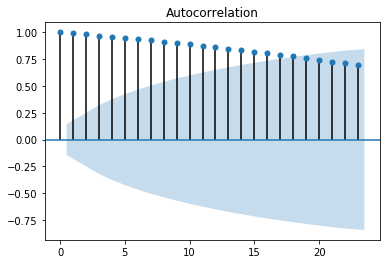

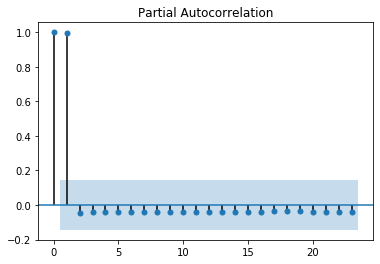

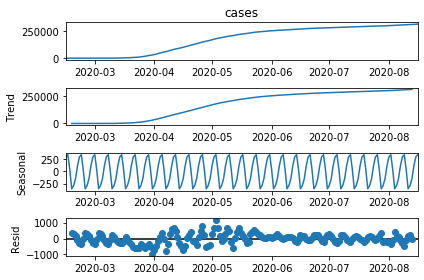

--------------Russia------------------


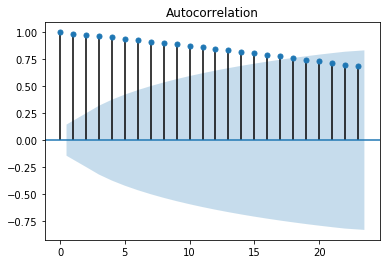

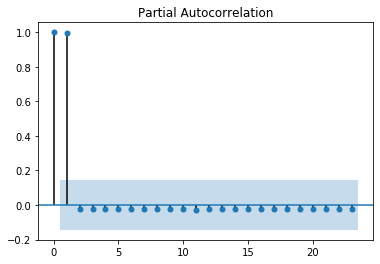

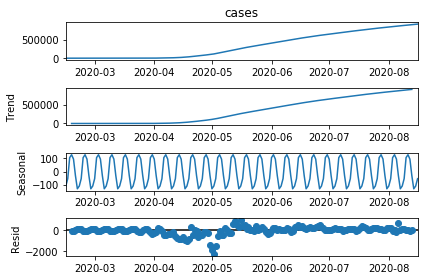

--------------Poland------------------


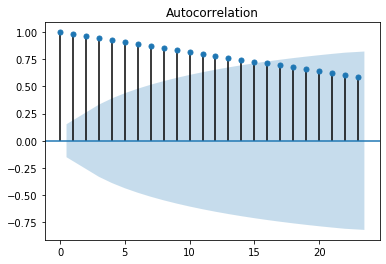

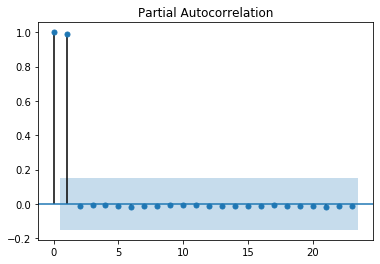

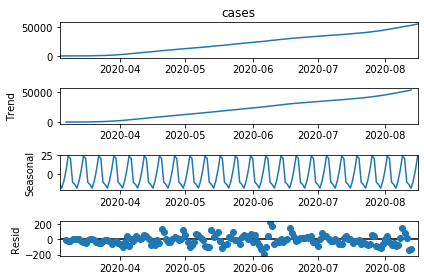

--------------Italy------------------


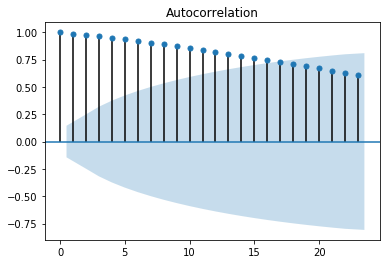

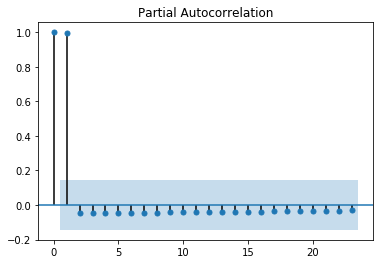

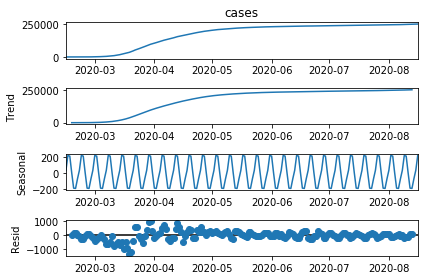

--------------Lithuania------------------


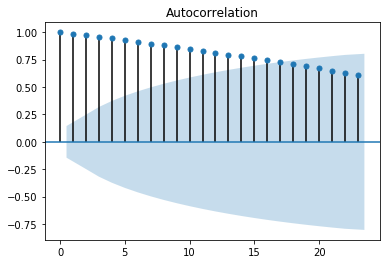

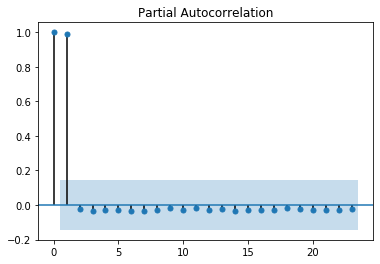

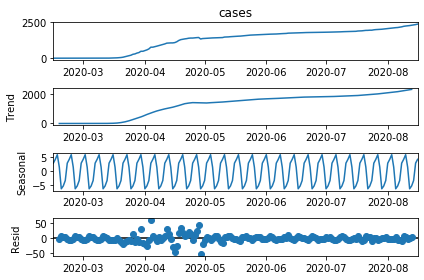

--------------France------------------


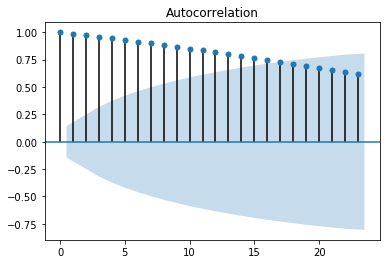

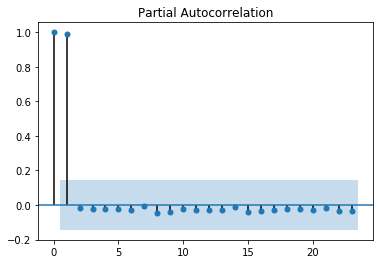

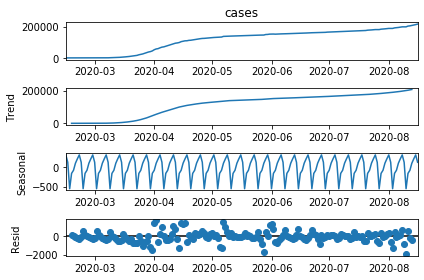

--------------Sweden------------------


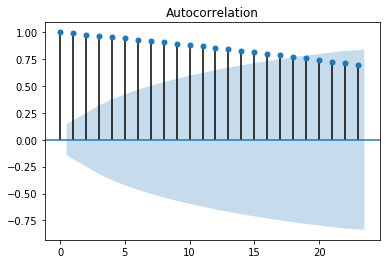

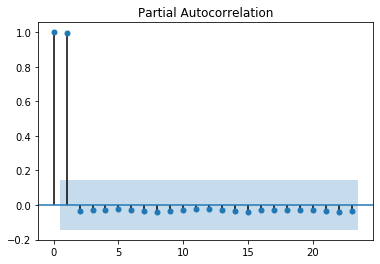

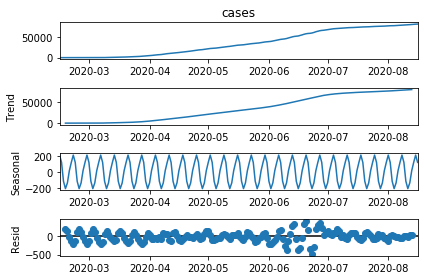

--------------Spain------------------


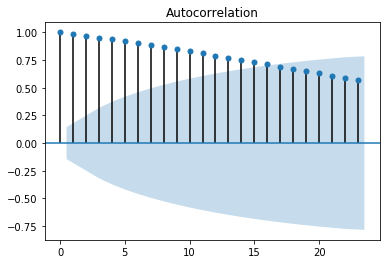

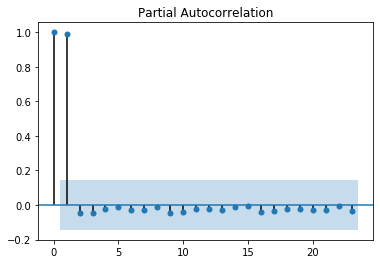

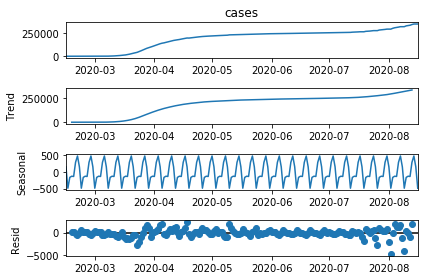

--------------Czech Republic------------------


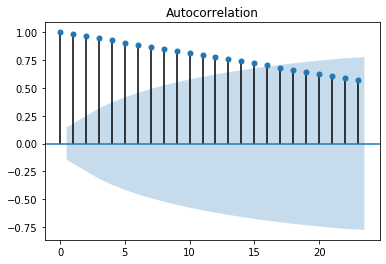

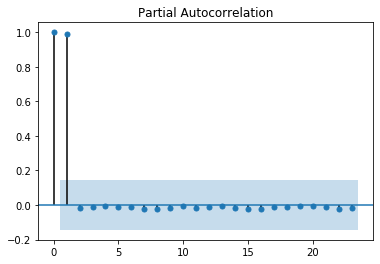

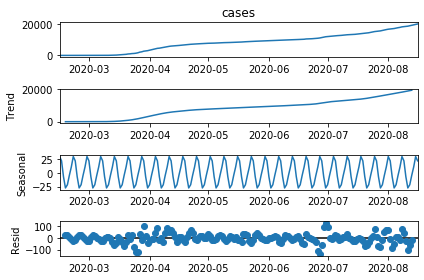

In [4]:
for country in ["United Kingdom", 'Russia', 'Poland', 'Italy','Lithuania','France','Sweden','Spain', 'Czech Republic']:
    print('--------------' + country + '------------------')
    cases_country = cases_cov.cases[cases_cov['country_region'] == country]
    plot_acf(cases_country)
    pyplot.show()
    plot_pacf(cases_country)
    pyplot.show()
    seas = seasonal_decompose(cases_country, model='additive')
    seas.plot()
    pyplot.show()

In [5]:
def sarima_cases(policy_type, mobility_type, country):
        
    cases_country = cases_cov.cases[cases_cov['country_region'] == country]
    mobil = cases_cov[mobility_type][cases_cov['country_region'] == country]
  
    split = len(cases_country) - 15
    train_cas = cases_country[:split].values.reshape(-1,1) # we will be predicting 15 days
    test_cas = cases_country[split:].values.reshape(-1,1)
    #train_cas = cases_country.values.reshape(-1,1)
        
    #forecasts_p0_m, forecasts_p2_m = sarima_mobility(country, mobility_type, policy_type) #predcit mobility first
    #forecasts_p0_m = np.asarray(forecasts_p0_m).reshape(-1,1)
    #print(forecasts_p0_m)
    #forecasts_p2_m = np.asarray(forecasts_p2_m).reshape(-1,1)
    #print(forecasts_p2_m)

    train_mob = mobil[:split].values.reshape(-1,1)
    test_mob = mobil[split:].values.reshape(-1,1)
    #train_mob = mobil.values.reshape(-1,1)
        
    adf_test = ADFTest(alpha=0.05)
    p_val, diff_needed = adf_test.should_diff(train_cas) #ADF to check if we need differencing (d)
    print(country + " is differencing needed? " + str(diff_needed))
    d = int(diff_needed)
    D = nsdiffs(train_cas, m=7, max_D=14, test='ch')
    print("Parameter D: " + str(D))
    
    m = 7 # weekly given the seasonality from the plots above, d=None, D=None -> auto_arima will search optimal

    sxmodel = pm.auto_arima(train_cas, exogenous=train_mob,
                           start_p=1, start_q=1,
                           test='adf',
                           m=m, 
                           start_P=0, seasonal=True,
                           d=None, D=None, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

    #print(sxmodel.summary(), file = open('eval/model_eval/cases/' + country + "_" + mobility_type + ".txt", "a"))

    sxmodel.fit(train_cas, exogenous = train_mob)
    forecasts = sxmodel.predict(n_periods=15, exogenous = test_mob)
    #forecasts_p0 = sxmodel.predict(n_periods=15, exogenous = forecasts_p0_m) #exogenous = forecasts_p0_m
    #forecasts_p2 = sxmodel.predict(n_periods=15, exogenous = forecasts_p2_m) #exogenous = forecasts_p2_m

    fig = plt.figure()
    plt.plot(forecasts, '--', c='blue', label = "Predictions")
    plt.plot(test_cas, c='green', label = "Actual")
    #lab = policy_type + " " + "not enforced"
    #plt.plot(forecasts_p0, '--', c='blue', label = lab)
    #lab = policy_type + " " + "enforced"
    #plt.plot(forecasts_p2, c='green', label = lab)
    plt.legend()
    plt.title(country + "_" + mobility_type)
    plt.show()
    #return forecasts_p0, forecasts_p2, forecasts_p0_m, forecasts_p2_m #return to creat VECM predictions
        #fig = sxmodel.plot_diagnostics(figsize=(7,5))
        #fig.savefig('plots/recommendations/' + country + "_" + mobility_type + "_" + policy_type + ".pdf", format='pdf', bbox_inches = 'tight')

In [6]:
mob_types = ['retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline',  'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline','workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline']
countries = ["United Kingdom", 'Russia', 'Poland', 'Italy','Lithuania','France','Sweden','Spain', 'Czech Republic']
pol_types = ["c1_schoolclosing", "c2_workplaceclosing", "c3_cancelpublicevents", "c4_restrictionsongatherings", "c5_closepublictransport", "c6_stayathomerequirements", "c7_domestictravel", "c8_internationaltravel", "h1_publicinfocampaign", "h2_testingpolicy", "h3_contacttracing"]

United Kingdom is differencing needed? False
Parameter D: 0
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=2437.736, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=2978.912, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=2387.719, Time=0.63 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=2676.850, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=3105.167, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=2490.846, Time=0.17 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=2381.334, Time=0.76 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=2422.964, Time=0.96 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=2380.028, Time=0.61 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=2435.727, Time=0.45 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=2383.469, Time=0.83 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=2416.813, Time=0.72 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=1.07 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=27

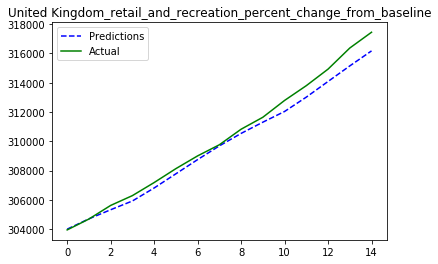

United Kingdom is differencing needed? False
Parameter D: 0
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=2437.736, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=2978.912, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=2387.719, Time=0.49 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=2676.850, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=3105.167, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=2490.846, Time=0.17 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=2381.334, Time=0.75 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=2422.964, Time=0.98 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=2380.028, Time=0.64 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=2435.727, Time=0.46 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=2383.469, Time=0.82 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=2416.813, Time=0.72 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=1.35 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=27

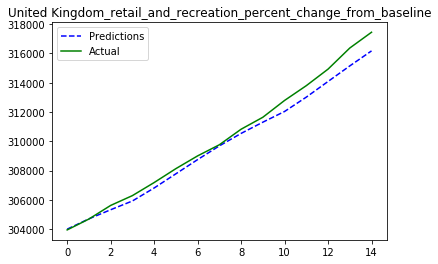

United Kingdom is differencing needed? False
Parameter D: 0
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=2437.736, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=2978.912, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=2387.719, Time=0.50 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=2676.850, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=3105.167, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=2490.846, Time=0.58 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=2381.334, Time=1.38 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=2422.964, Time=1.56 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=2380.028, Time=1.20 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=2435.727, Time=0.46 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=2383.469, Time=0.86 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=2416.813, Time=0.99 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=1.32 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=27

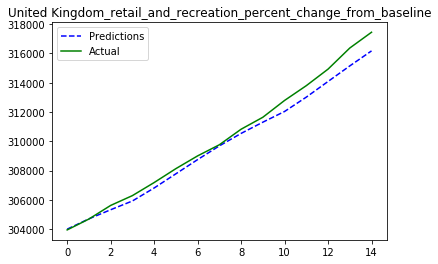

United Kingdom is differencing needed? False
Parameter D: 0
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=2437.736, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=2978.912, Time=0.28 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=2387.719, Time=0.94 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=2676.850, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=3105.167, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=2490.846, Time=0.22 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=2381.334, Time=0.87 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=2422.964, Time=1.01 sec


KeyboardInterrupt: 

In [7]:
for country in countries:
    for mobility_type in mob_types:
        for policy_type in pol_types:
            sarima_cases(policy_type, mobility_type, country)

--------------United Kingdom------------------
+++retail_and_recreation_percent_change_from_baseline+++


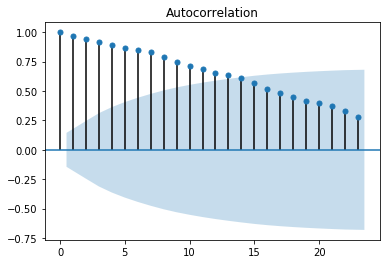

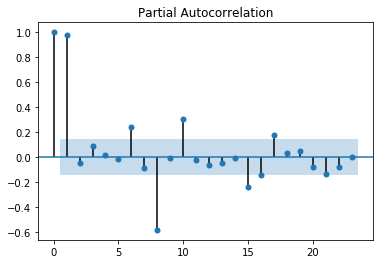

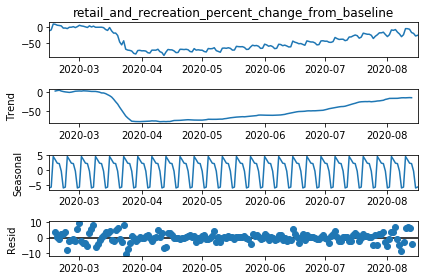

+++grocery_and_pharmacy_percent_change_from_baseline+++


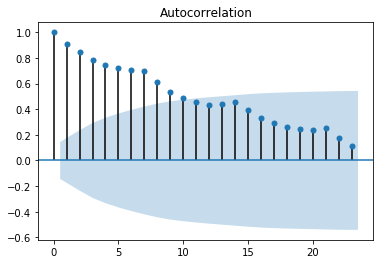

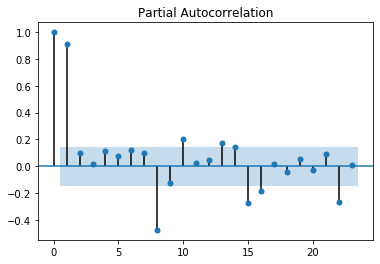

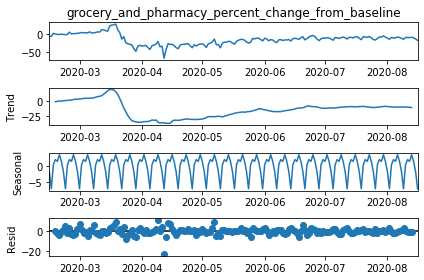

+++parks_percent_change_from_baseline+++


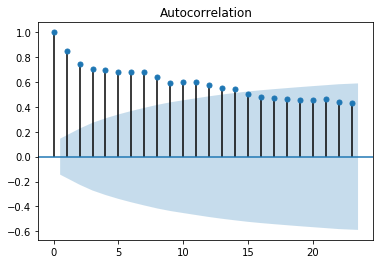

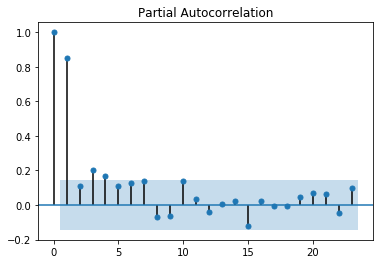

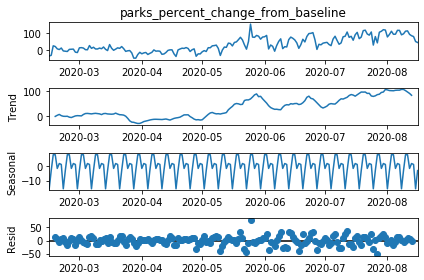

+++transit_stations_percent_change_from_baseline+++


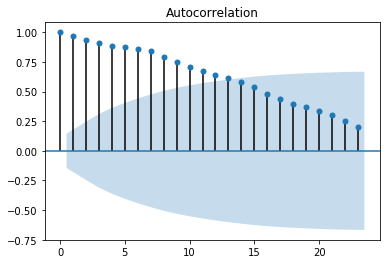

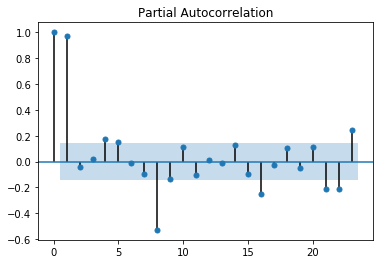

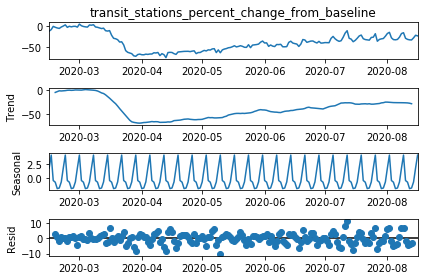

+++workplaces_percent_change_from_baseline+++


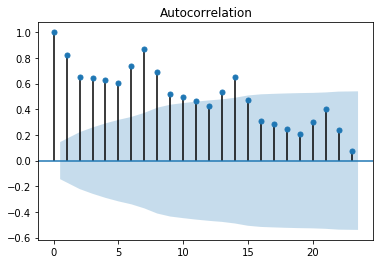

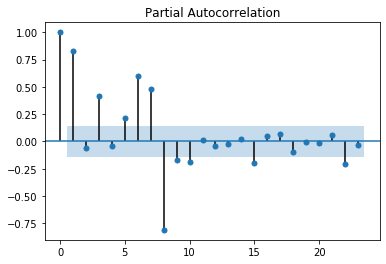

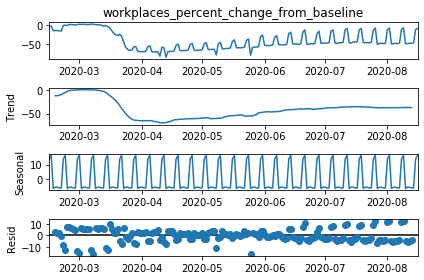

+++residential_percent_change_from_baseline+++


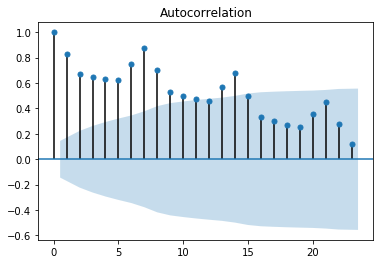

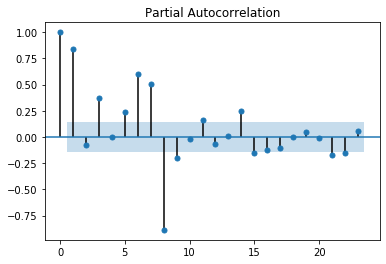

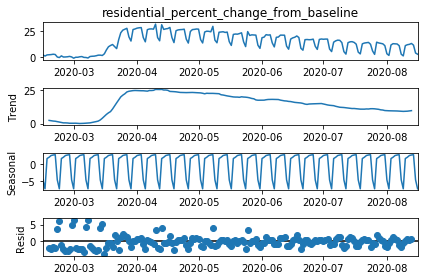

--------------Russia------------------
+++retail_and_recreation_percent_change_from_baseline+++


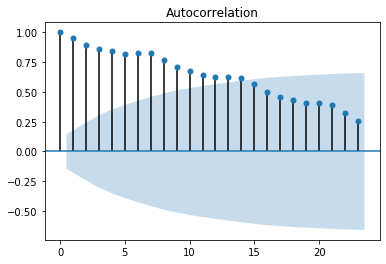

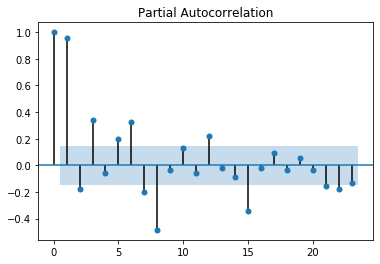

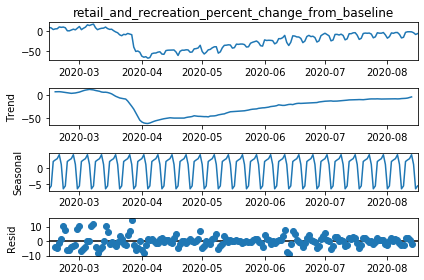

+++grocery_and_pharmacy_percent_change_from_baseline+++


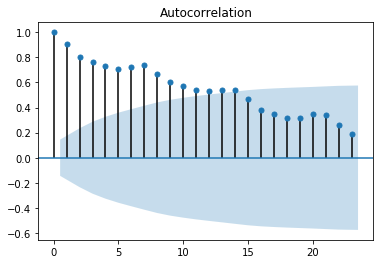

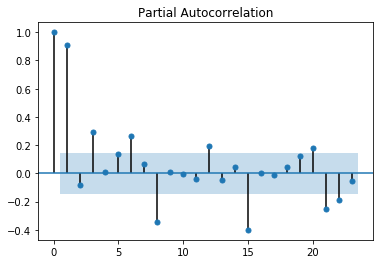

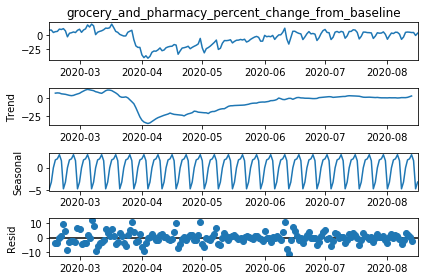

+++parks_percent_change_from_baseline+++


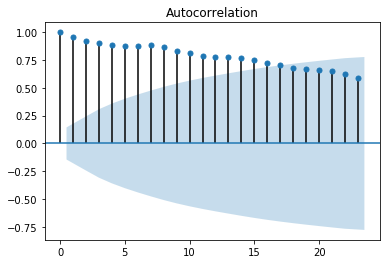

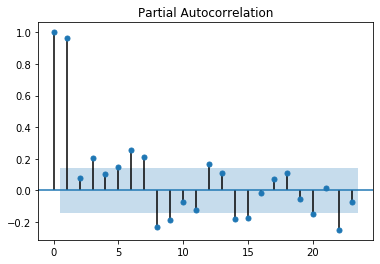

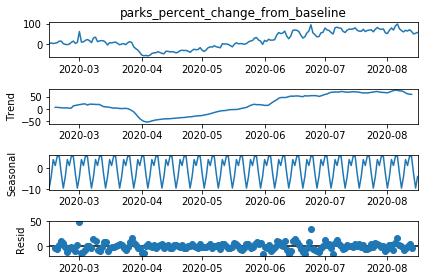

+++transit_stations_percent_change_from_baseline+++


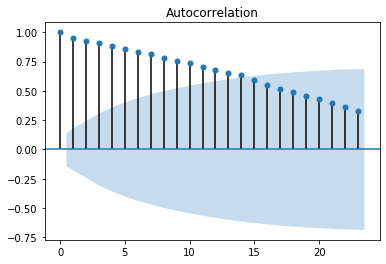

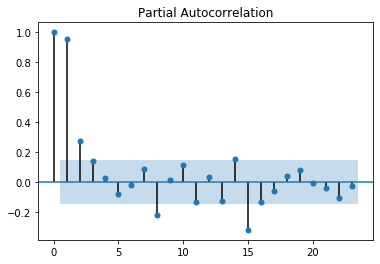

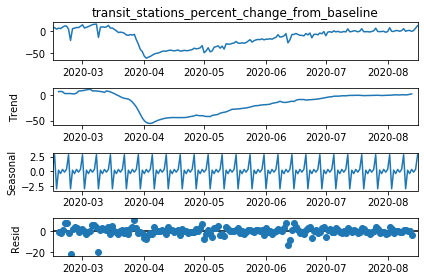

+++workplaces_percent_change_from_baseline+++


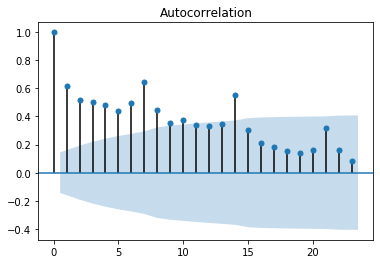

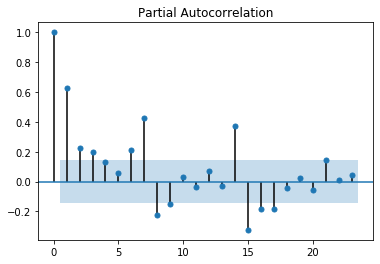

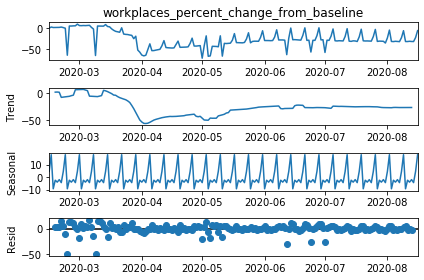

+++residential_percent_change_from_baseline+++


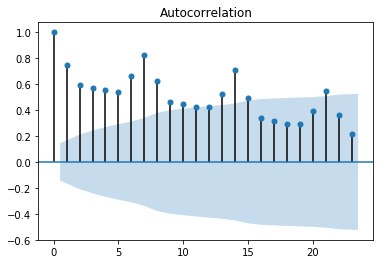

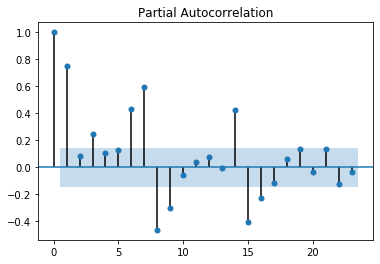

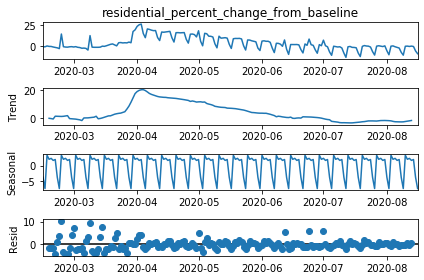

--------------Poland------------------
+++retail_and_recreation_percent_change_from_baseline+++


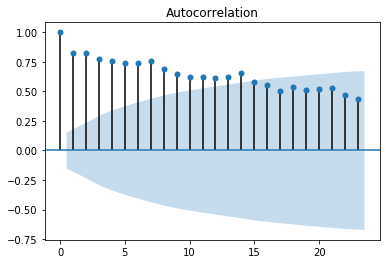

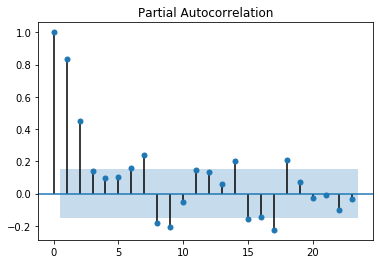

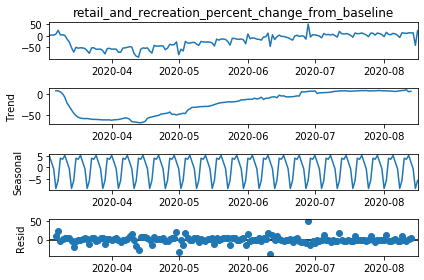

+++grocery_and_pharmacy_percent_change_from_baseline+++


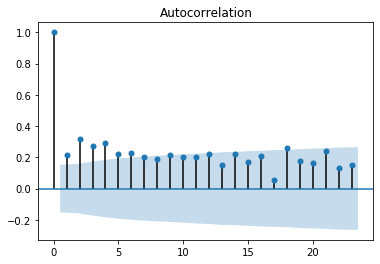

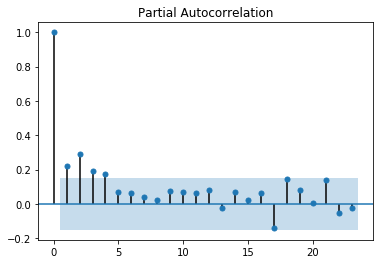

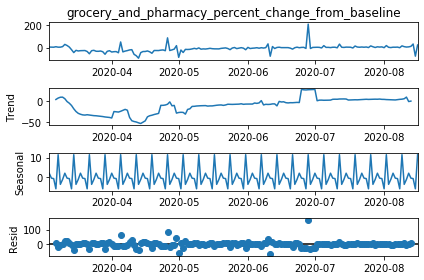

+++parks_percent_change_from_baseline+++


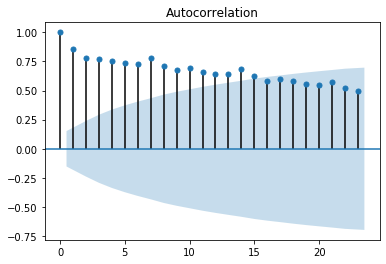

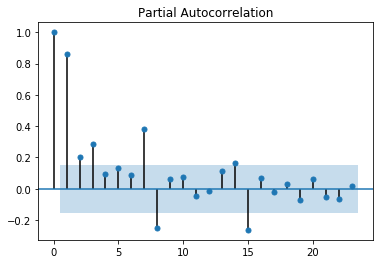

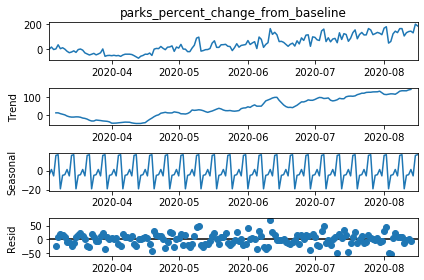

+++transit_stations_percent_change_from_baseline+++


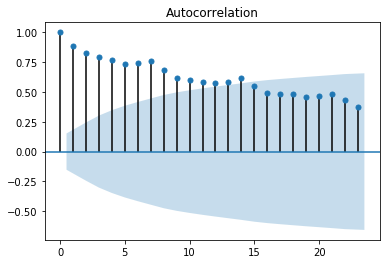

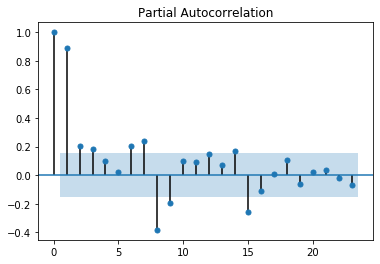

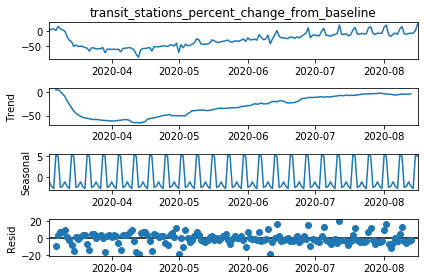

+++workplaces_percent_change_from_baseline+++


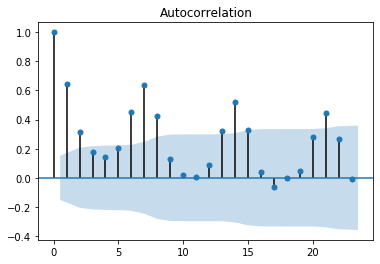

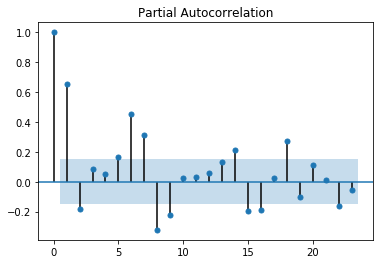

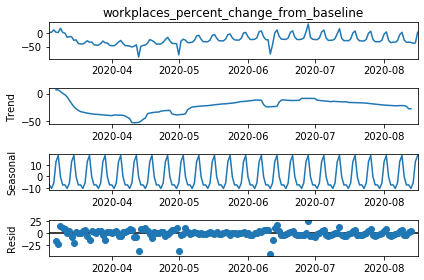

+++residential_percent_change_from_baseline+++


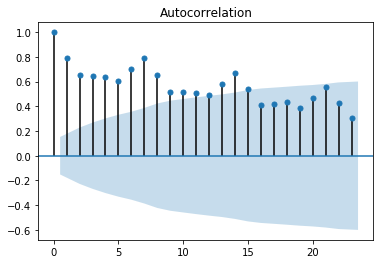

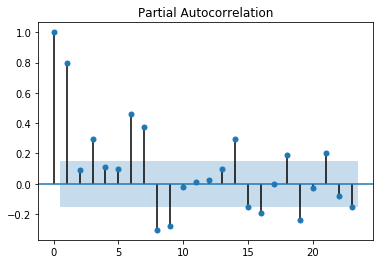

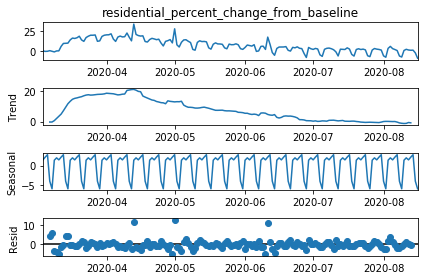

--------------Italy------------------
+++retail_and_recreation_percent_change_from_baseline+++


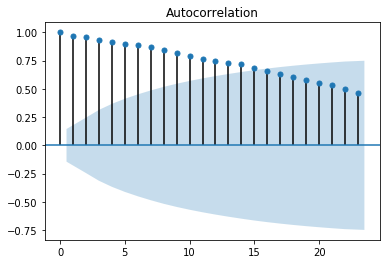

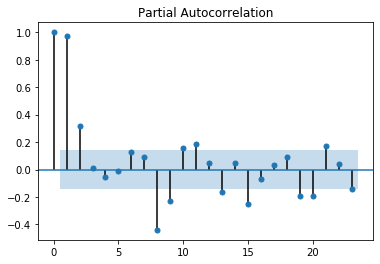

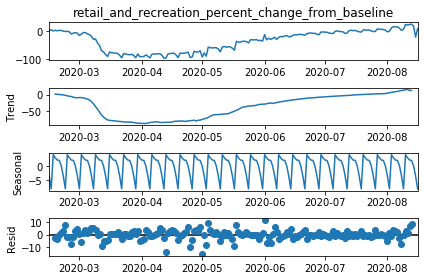

+++grocery_and_pharmacy_percent_change_from_baseline+++


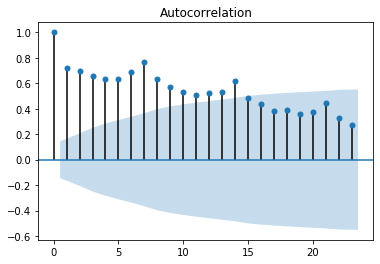

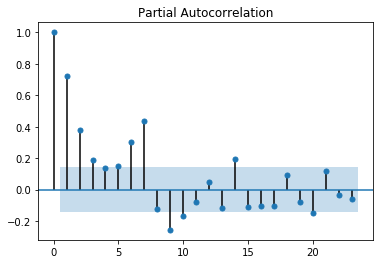

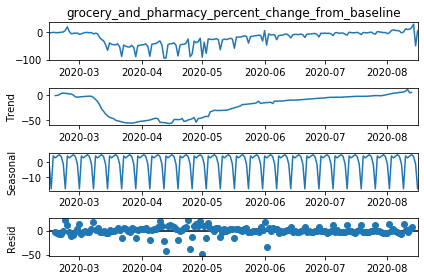

+++parks_percent_change_from_baseline+++


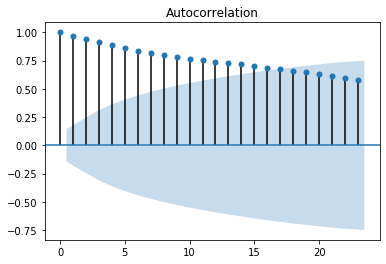

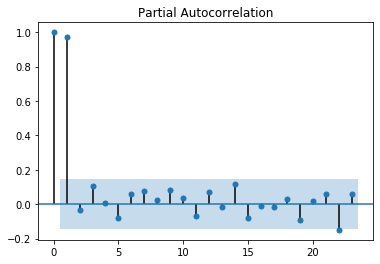

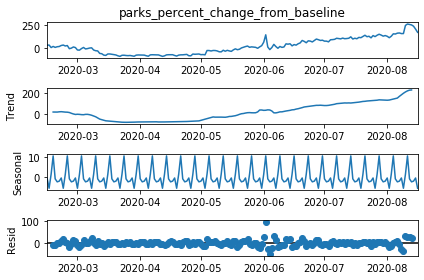

+++transit_stations_percent_change_from_baseline+++


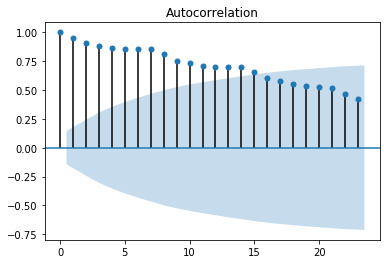

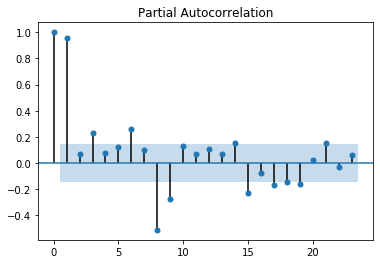

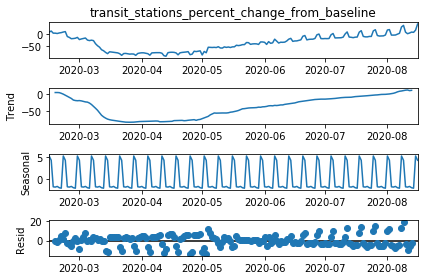

+++workplaces_percent_change_from_baseline+++


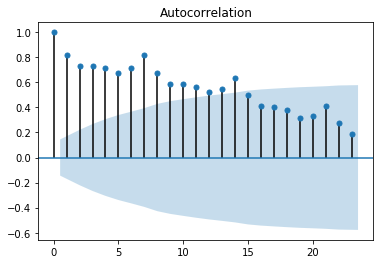

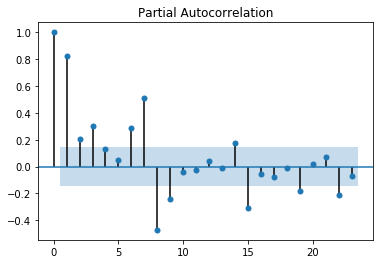

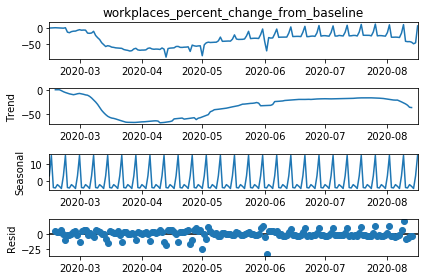

+++residential_percent_change_from_baseline+++


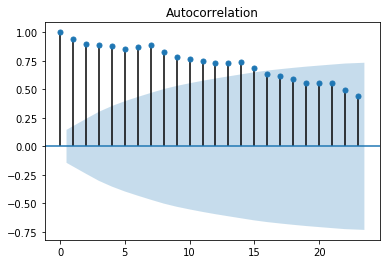

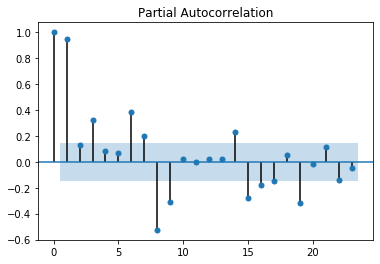

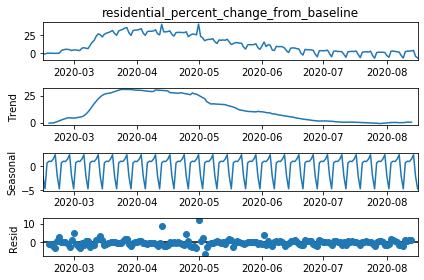

--------------Lithuania------------------
+++retail_and_recreation_percent_change_from_baseline+++


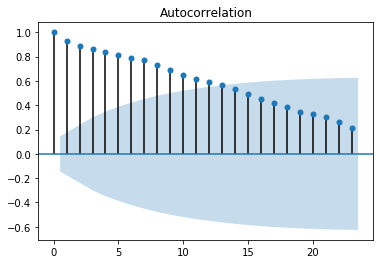

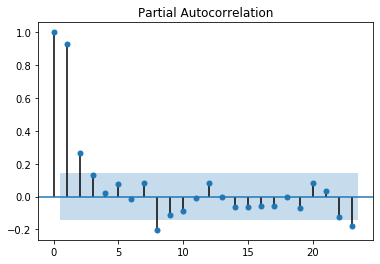

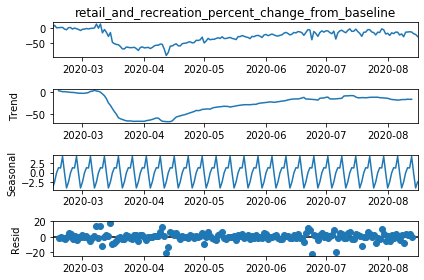

+++grocery_and_pharmacy_percent_change_from_baseline+++


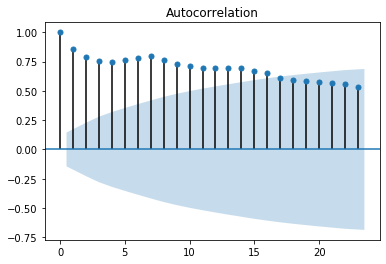

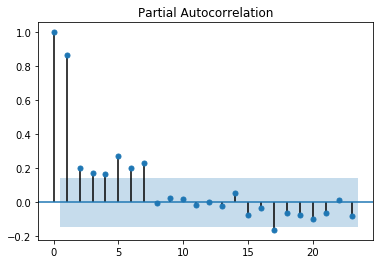

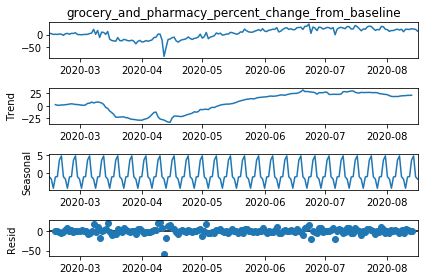

+++parks_percent_change_from_baseline+++


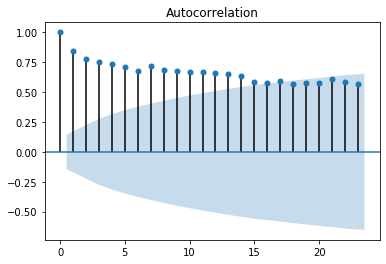

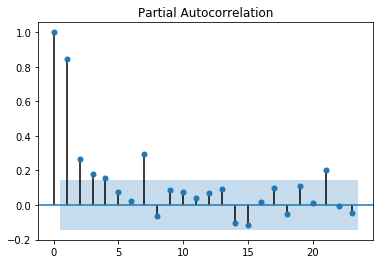

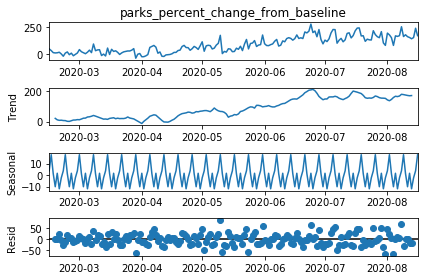

+++transit_stations_percent_change_from_baseline+++


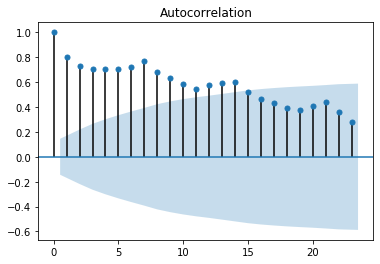

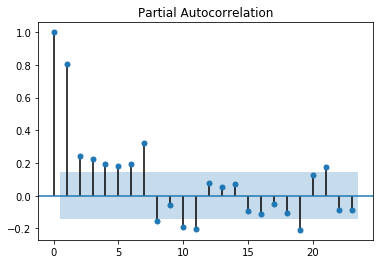

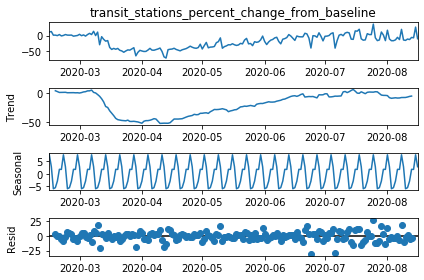

+++workplaces_percent_change_from_baseline+++


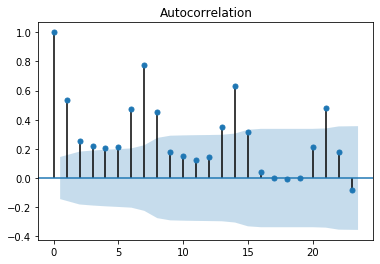

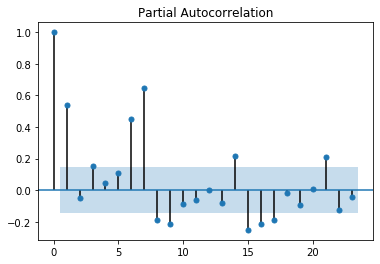

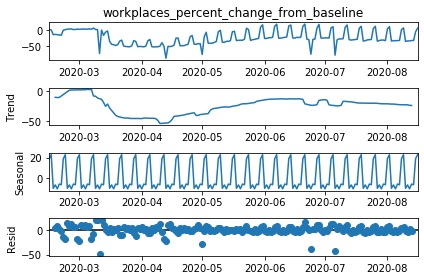

+++residential_percent_change_from_baseline+++


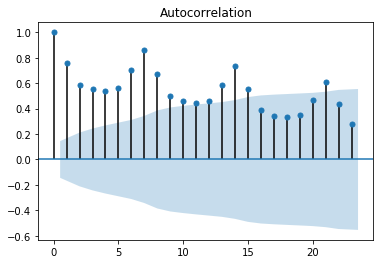

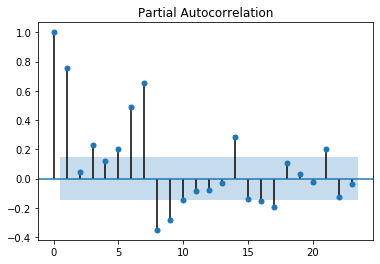

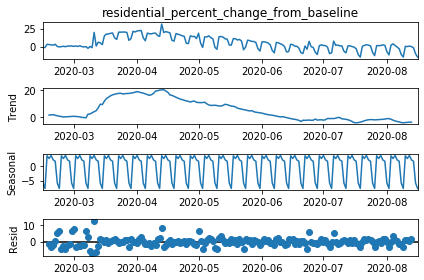

--------------France------------------
+++retail_and_recreation_percent_change_from_baseline+++


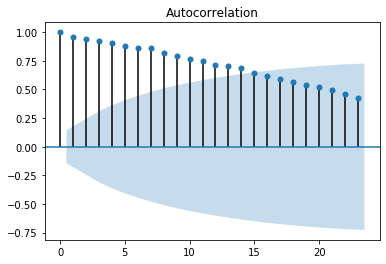

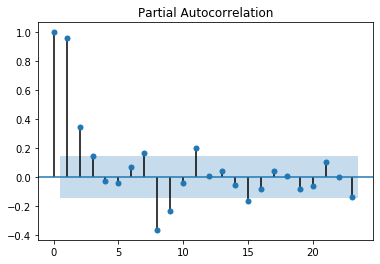

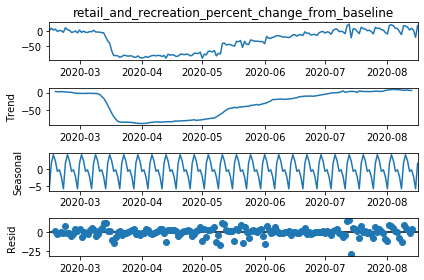

+++grocery_and_pharmacy_percent_change_from_baseline+++


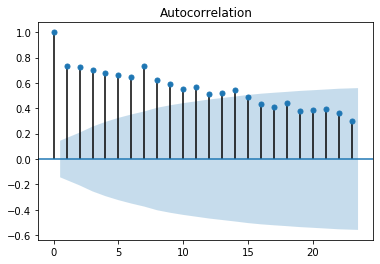

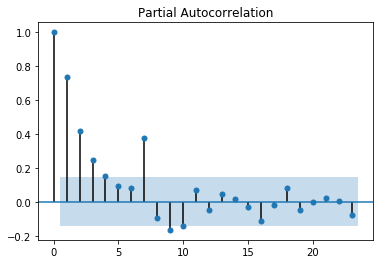

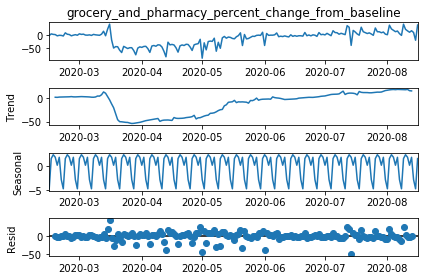

+++parks_percent_change_from_baseline+++


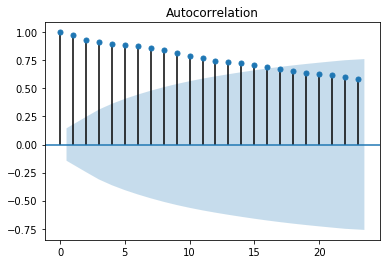

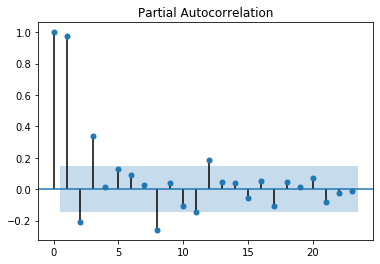

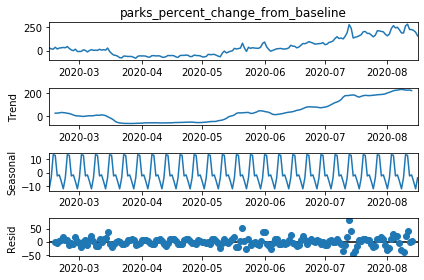

+++transit_stations_percent_change_from_baseline+++


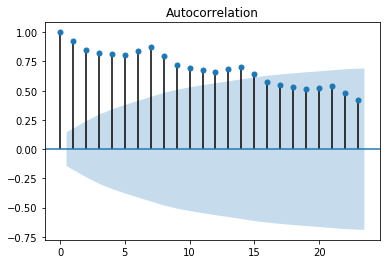

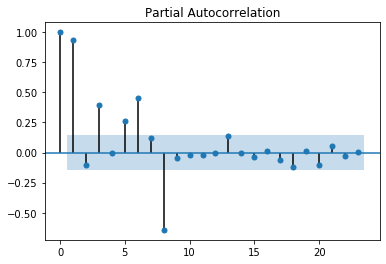

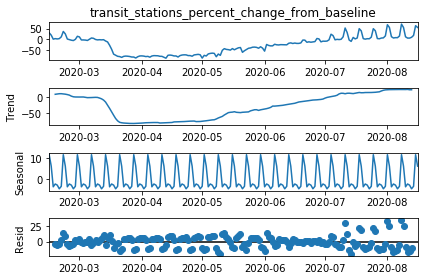

+++workplaces_percent_change_from_baseline+++


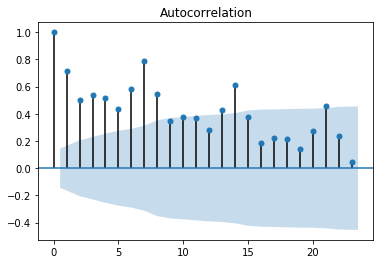

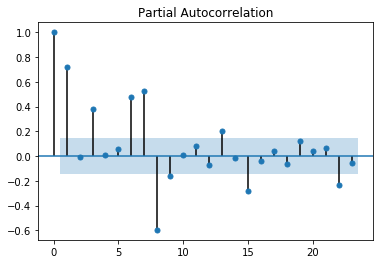

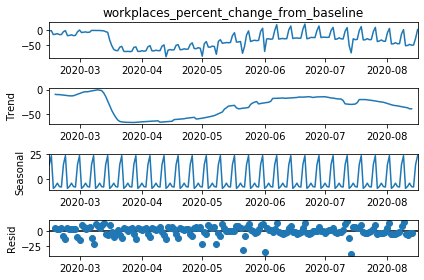

+++residential_percent_change_from_baseline+++


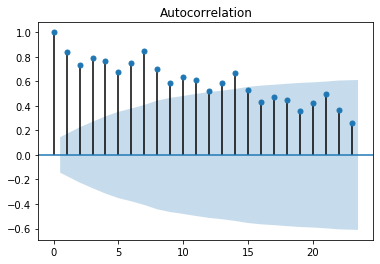

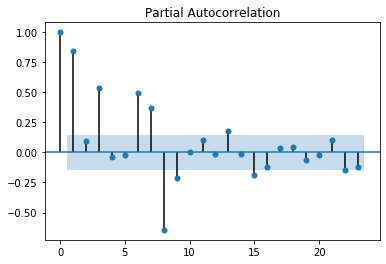

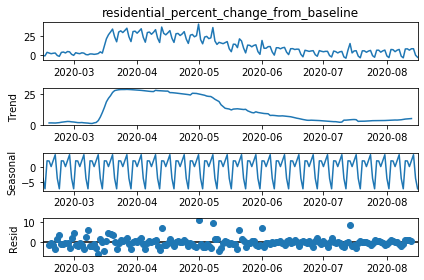

--------------Sweden------------------
+++retail_and_recreation_percent_change_from_baseline+++


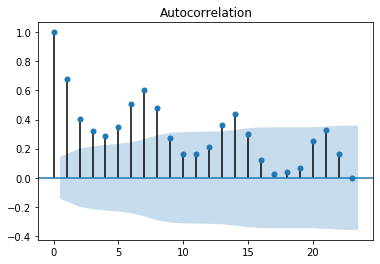

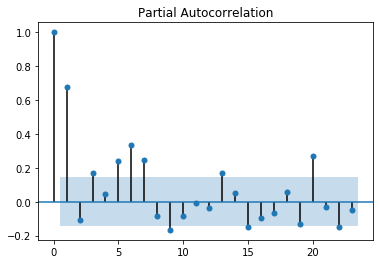

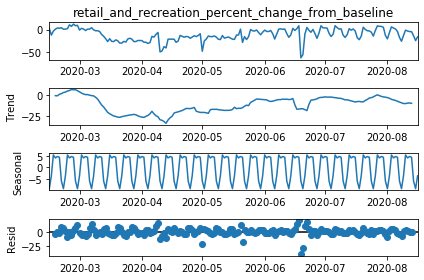

+++grocery_and_pharmacy_percent_change_from_baseline+++


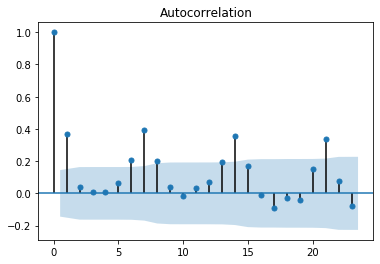

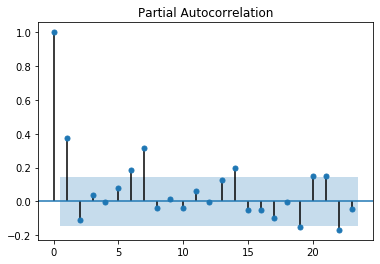

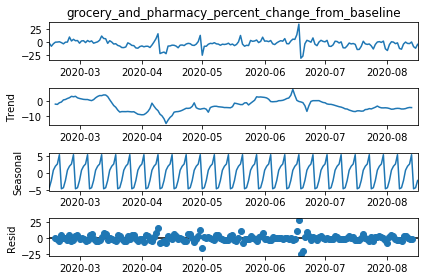

+++parks_percent_change_from_baseline+++


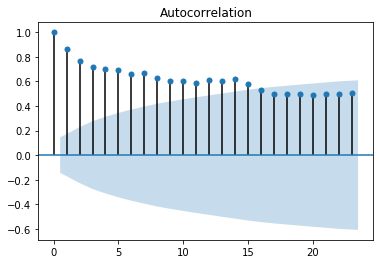

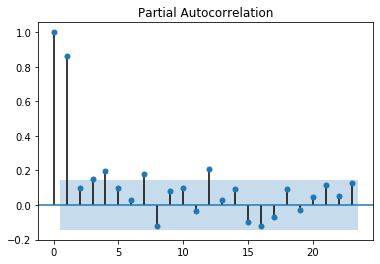

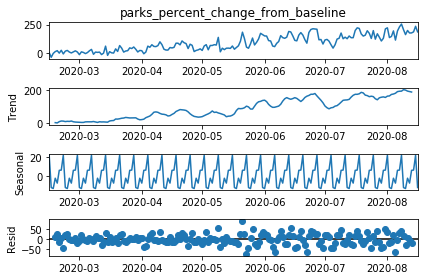

+++transit_stations_percent_change_from_baseline+++


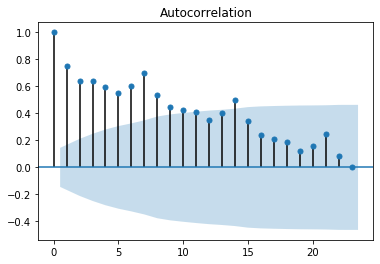

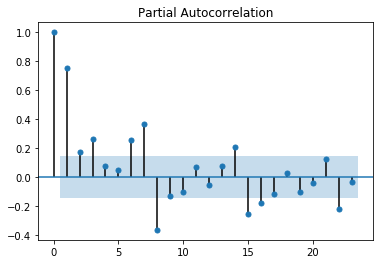

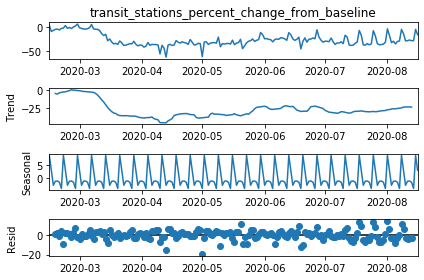

+++workplaces_percent_change_from_baseline+++


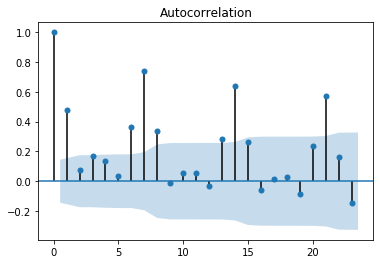

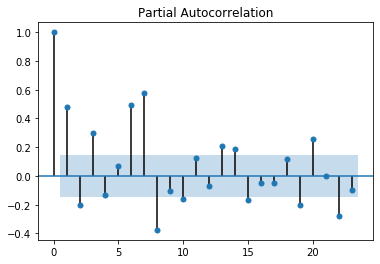

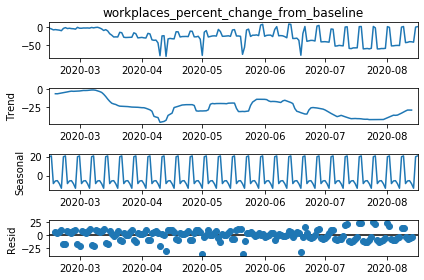

+++residential_percent_change_from_baseline+++


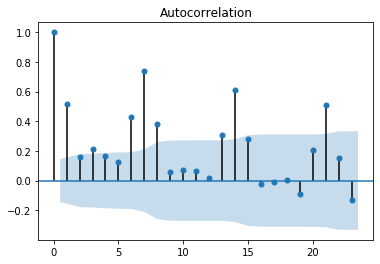

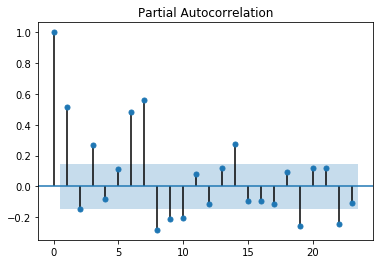

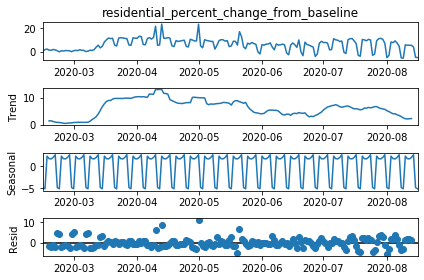

--------------Spain------------------
+++retail_and_recreation_percent_change_from_baseline+++


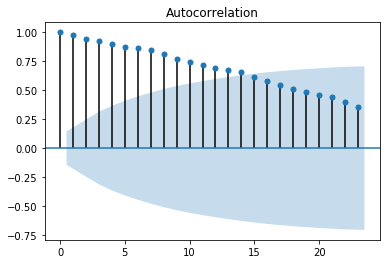

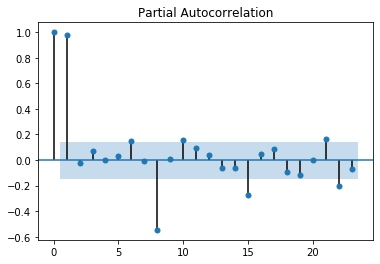

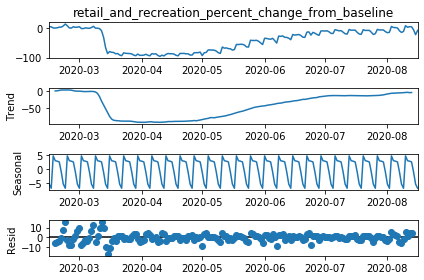

+++grocery_and_pharmacy_percent_change_from_baseline+++


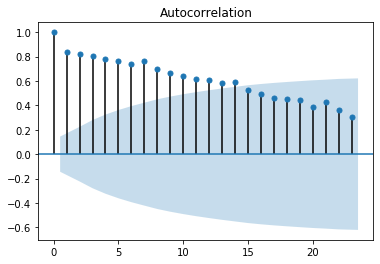

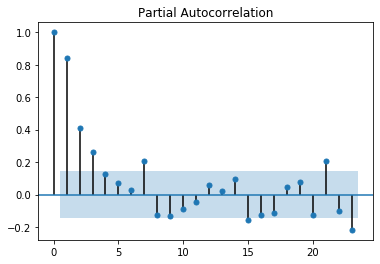

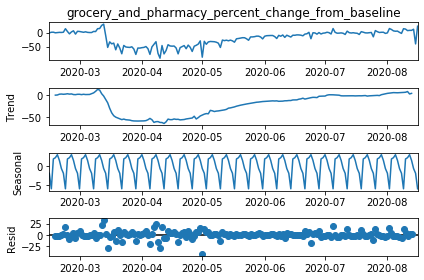

+++parks_percent_change_from_baseline+++


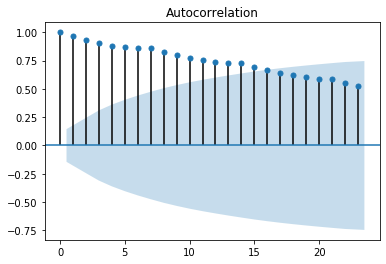

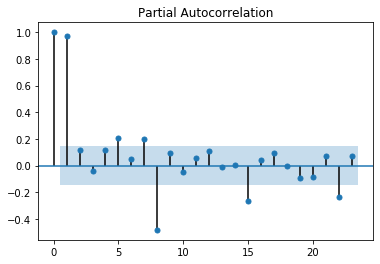

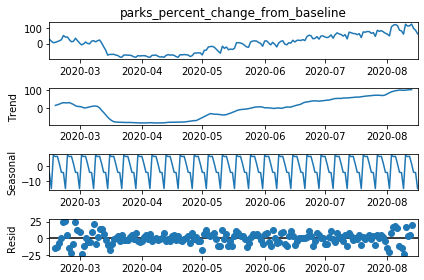

+++transit_stations_percent_change_from_baseline+++


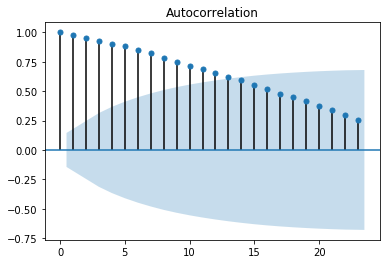

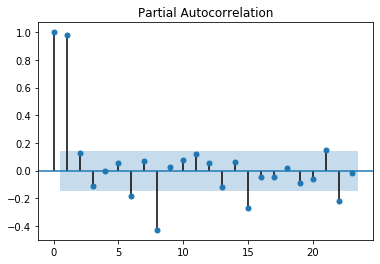

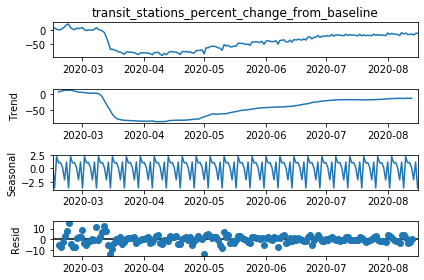

+++workplaces_percent_change_from_baseline+++


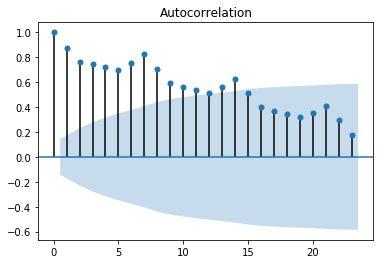

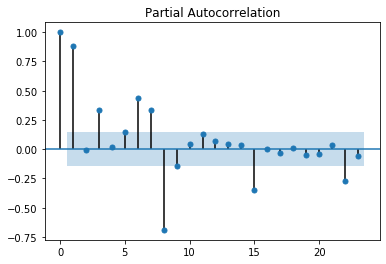

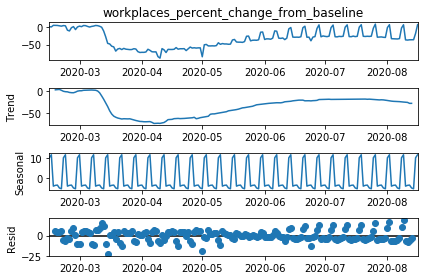

+++residential_percent_change_from_baseline+++


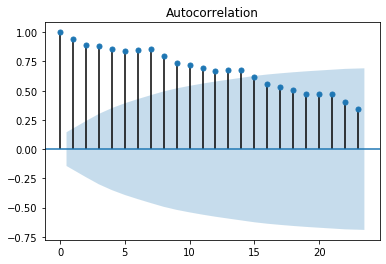

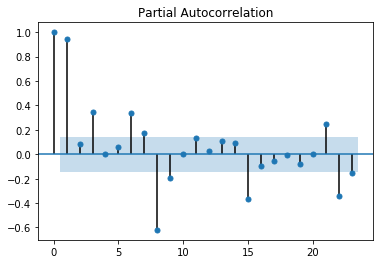

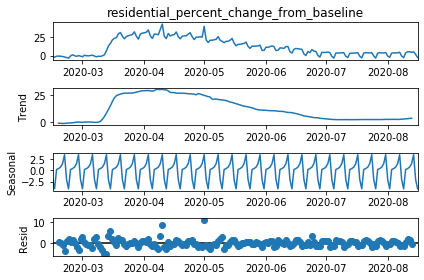

--------------Czech Republic------------------
+++retail_and_recreation_percent_change_from_baseline+++


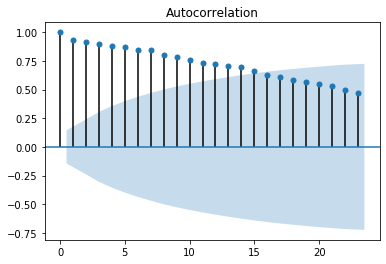

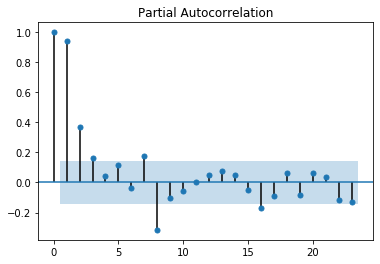

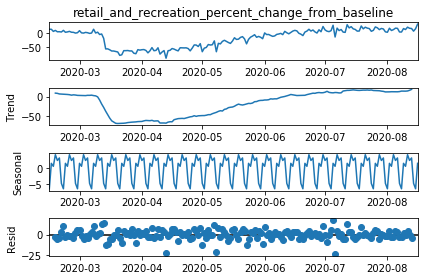

+++grocery_and_pharmacy_percent_change_from_baseline+++


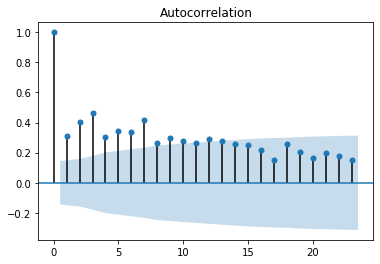

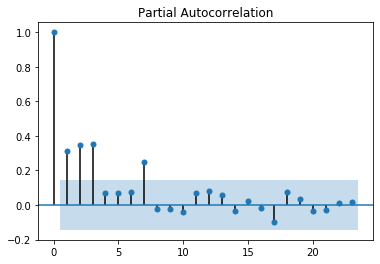

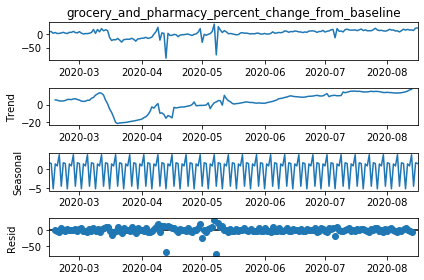

+++parks_percent_change_from_baseline+++


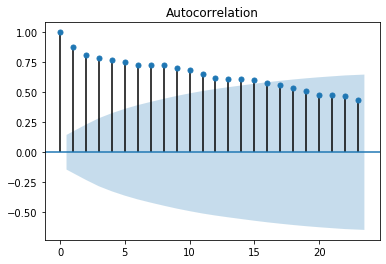

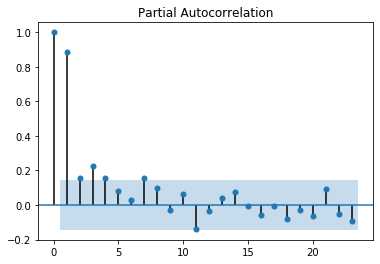

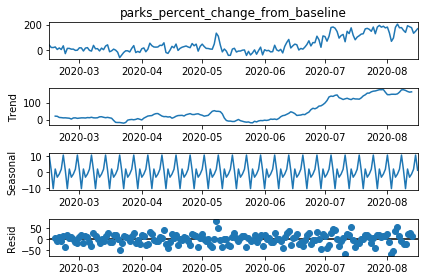

+++transit_stations_percent_change_from_baseline+++


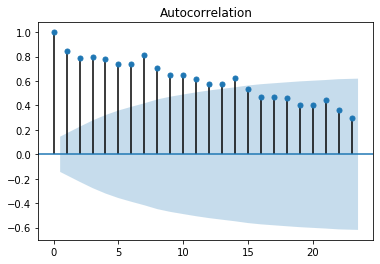

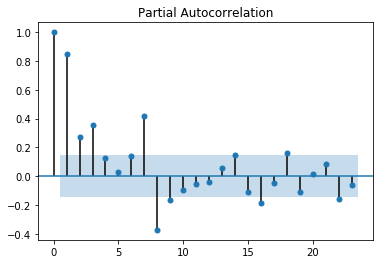

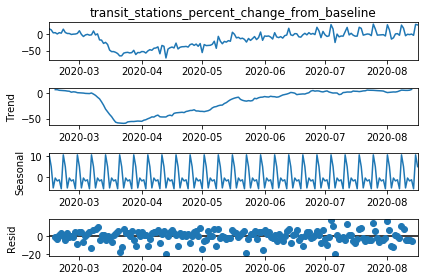

+++workplaces_percent_change_from_baseline+++


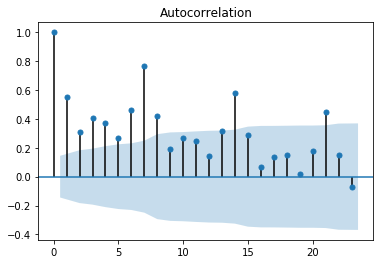

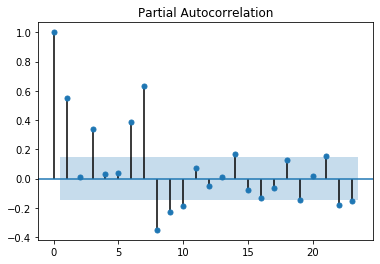

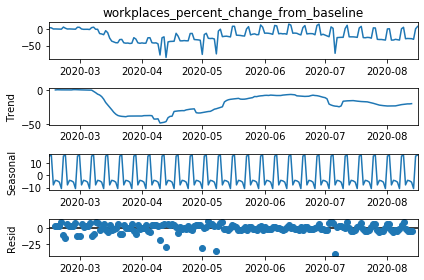

+++residential_percent_change_from_baseline+++


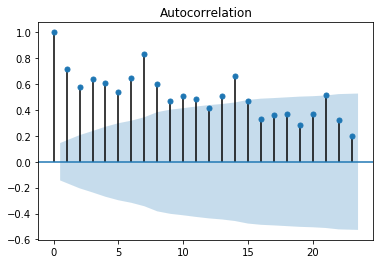

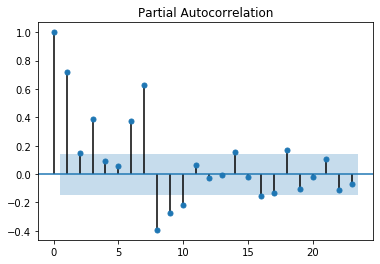

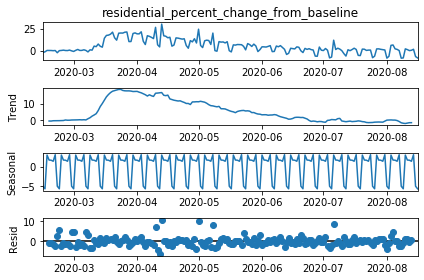

In [8]:
for country in ["United Kingdom", 'Russia', 'Poland', 'Italy','Lithuania','France','Sweden','Spain', 'Czech Republic']:
    print('--------------' + country + '------------------')
    for mobility_type in mob_types:
        print('+++' + mobility_type + '+++')
        mobility = cases_cov[mobility_type][cases_cov['country_region'] == country]
        plot_acf(mobility)
        pyplot.show()
        plot_pacf(mobility)
        pyplot.show()
        seas = seasonal_decompose(mobility, model='additive')
        seas.plot()
        pyplot.show()

In [9]:
def sarima_mobility(country, mobility_type, policy_type):
    policy = cases_cov[policy_type][cases_cov['country_region'] == country]
    mobil = cases_cov[mobility_type][cases_cov['country_region'] == country]
  
    split = len(mobil) - 14
    train_policy = policy[:split].values.reshape(-1,1) # we will be predicting 14 days
    #train_policy = policy.values.reshape(-1,1)
    test_policy = policy[split:].values.reshape(-1,1)
    #test_policy2 = [0.0] * 14 #synthetic data
    #test_policy2 = np.asarray(test_policy2).reshape(-1,1)
    #test_policy3 = [2.0] * 14
    #test_policy3 = np.asarray(test_policy3).reshape(-1,1)

    train_mob = mobil[:split].values.reshape(-1,1)
    #train_mob = mobil.values.reshape(-1,1)
    test_mob = mobil[split:].values.reshape(-1,1)

    adf_test = ADFTest(alpha=0.05)
    p_val, diff_needed = adf_test.should_diff(train_mob) #ADF to check if we need differencing (d)
    print(country + " is differencing needed? " + str(diff_needed))
    d = int(diff_needed)
    D = nsdiffs(train_mob, m=7, max_D=12, test='ch')
    print("Parameter D: " + str(D))
    
    m = 7

    sxmodel = pm.auto_arima(train_mob, exogenous=train_policy,
                           start_p=1, start_q=1,
                           test='adf',
                           m=m, 
                           start_P=0, seasonal=True,
                           d=None, D=None, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

    #print(sxmodel.summary(), file = open('eval/model_eval/mobility/' + country + "_" + mobility_type + "_" + policy_type + ".txt", "a"))

    sxmodel.fit(train_mob, exogenous = train_policy)
    forecasts = sxmodel.predict(n_periods=14, exogenous = test_policy)
    #forecasts_p0 = sxmodel.predict(n_periods=14, exogenous = test_policy2)
    #forecasts_p2 = sxmodel.predict(n_periods=14, exogenous = test_policy3)
    
    fig = plt.figure()
    #lab = policy_type + " " + "not enforced"
    plt.plot(forecasts, '--', c='blue', label = "Forecasts")
    #lab = policy_type + " " + "enforced"
    plt.plot(test_mob, c='green', label = "Actual")
    plt.legend()
    plt.title(country + "_" + mobility_type)
    plt.show()
    #return forecasts_p0, forecasts_p2

    #fig.savefig('plots/predict_mobility/' + country + "_" + mobility_type + "_" + policy_type + ".pdf", format='pdf', bbox_inches = 'tight')
        
    #fig = sxmodel.plot_diagnostics(figsize=(7,5))
    #fig.savefig('plots/mobility_prediction_eval/' + country + "_" + mobility_type + "_" + policy_type + ".pdf", format='pdf', bbox_inches = 'tight')
    #plt.close(fig)

+++United Kingdom+++
+++retail_and_recreation_percent_change_from_baseline+++
+++c1_schoolclosing+++
United Kingdom is differencing needed? True
Parameter D: 0
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=1045.590, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=1094.364, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=1008.945, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=1045.093, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=1092.369, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=1096.194, Time=0.09 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=1004.749, Time=0.28 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=0.88 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=993.270, Time=0.36 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=1045.189, Time=0.17 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=1018.933, Time=0.46 sec
 ARIMA(1,1,0)(2,

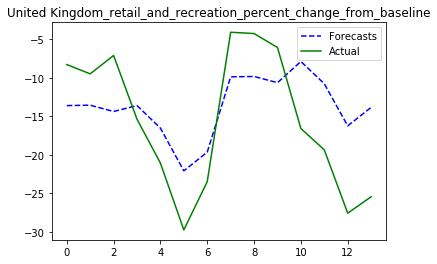

+++c2_workplaceclosing+++
United Kingdom is differencing needed? True
Parameter D: 0
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=1039.447, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=1091.642, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=1002.767, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=1040.670, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=1089.643, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=1093.132, Time=0.09 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=997.457, Time=0.29 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=983.350, Time=0.41 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=1040.950, Time=0.18 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=1014.764, Time=0.33 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=1.03 sec
 ARIMA(0,1,0)(1,0,1)[7] interce

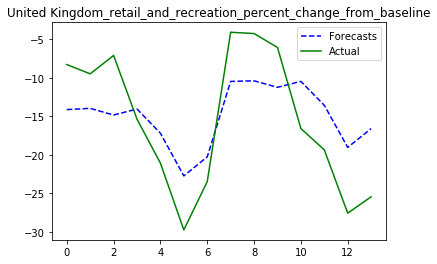

+++c3_cancelpublicevents+++
United Kingdom is differencing needed? True
Parameter D: 0
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=1039.351, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=1081.641, Time=0.14 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=1003.799, Time=0.22 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=1040.634, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=1079.706, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=1082.985, Time=0.11 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=992.598, Time=0.33 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=0.88 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=973.064, Time=0.36 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=1040.906, Time=0.18 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=973.917, Time=0.83 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=1014.397, Time=0.37 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=977.052, Time=0.55 sec
 ARIMA(0,1,0)(1,0,1)[

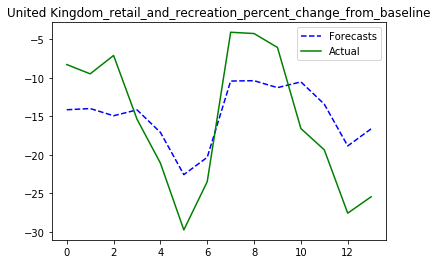

+++c4_restrictionsongatherings+++
United Kingdom is differencing needed? True
Parameter D: 0
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=1048.672, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=1090.989, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=1010.936, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=1046.920, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=1089.095, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=1092.276, Time=0.07 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=1005.841, Time=0.28 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=994.864, Time=0.38 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=1046.934, Time=0.14 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=1019.198, Time=0.35 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=0.93 sec
 ARIMA(0,1,0)(1,0,1)[7

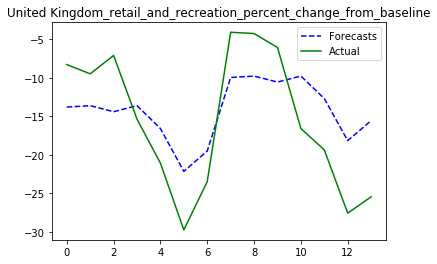

+++c5_closepublictransport+++
United Kingdom is differencing needed? True
Parameter D: 0
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=1045.967, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=1094.167, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=1007.473, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=1045.763, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=1092.171, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=1095.807, Time=0.57 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=1001.949, Time=0.47 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=1.69 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=992.697, Time=0.41 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=1046.111, Time=0.20 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=986.945, Time=1.24 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=1013.232, Time=0.35 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=1.00 sec
 ARIMA(0,1,0)(1,0,2)[7

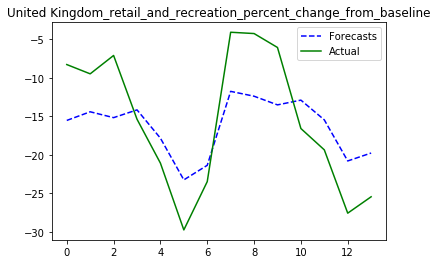

+++c6_stayathomerequirements+++
United Kingdom is differencing needed? True
Parameter D: 0
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=1047.680, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=1095.623, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=1010.294, Time=0.31 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=1046.902, Time=0.77 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=1093.647, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=1097.545, Time=0.25 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=1005.887, Time=0.92 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=1.18 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=994.763, Time=0.44 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=1047.039, Time=0.26 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=1.32 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=1019.738, Time=0.55 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=990.133, Time=1.62 sec
 ARIMA(0,1,0)(2,0,2)

KeyboardInterrupt: 

In [10]:
for country in countries:
    print('+++' + country + '+++')
    for mobility_type in mob_types:
        print('+++' + mobility_type + '+++')
        for policy_type in pol_types:
            print('+++' + policy_type + '+++')
            sarima_mobility(country, mobility_type, policy_type)

In [11]:
for country in countries:
    print('+++' + country + '+++')
    country_cases = cases_cov[cases_cov['country_region'] == country]
    for mobility_type in mob_types:
        print('+++' + mobility_type + '+++')
        test_result = grangercausalitytests(country_cases[['cases', mobility_type]], maxlag = 14, verbose=True)
        p_values = [round(test_result[i+1][0]['ssr_chi2test'][1],4) for i in range(14)]
        print(p_values)
        #print(p_values, file = open('eval/h0_testing/cases/' + country + "_" + mobility_type + ".txt", "a"))

+++United Kingdom+++
+++retail_and_recreation_percent_change_from_baseline+++

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=403.0280, p=0.0000  , df_denom=180, df_num=1
ssr based chi2 test:   chi2=409.7451, p=0.0000  , df=1
likelihood ratio test: chi2=215.0759, p=0.0000  , df=1
parameter F test:         F=403.0280, p=0.0000  , df_denom=180, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1524  , p=0.3182  , df_denom=177, df_num=2
ssr based chi2 test:   chi2=2.3698  , p=0.3058  , df=2
likelihood ratio test: chi2=2.3545  , p=0.3081  , df=2
parameter F test:         F=1.1524  , p=0.3182  , df_denom=177, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=18.1272 , p=0.0000  , df_denom=174, df_num=3
ssr based chi2 test:   chi2=56.5693 , p=0.0000  , df=3
likelihood ratio test: chi2=49.2252 , p=0.0000  , df=3
parameter F test:         F=18.1272 , p=0.0000  , df_denom=174, df_num=3

Granger Causali

likelihood ratio test: chi2=3.7243  , p=0.7139  , df=6
parameter F test:         F=0.5815  , p=0.7448  , df_denom=165, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.4141  , p=0.8926  , df_denom=162, df_num=7
ssr based chi2 test:   chi2=3.1668  , p=0.8692  , df=7
likelihood ratio test: chi2=3.1388  , p=0.8719  , df=7
parameter F test:         F=0.4141  , p=0.8926  , df_denom=162, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.7898  , p=0.6123  , df_denom=159, df_num=8
ssr based chi2 test:   chi2=6.9943  , p=0.5372  , df=8
likelihood ratio test: chi2=6.8589  , p=0.5519  , df=8
parameter F test:         F=0.7898  , p=0.6123  , df_denom=159, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.0016  , p=0.4412  , df_denom=156, df_num=9
ssr based chi2 test:   chi2=10.1122 , p=0.3415  , df=9
likelihood ratio test: chi2=9.8308  , p=0.3644  , df=9
parameter F test:         F=1.0016  , p

likelihood ratio test: chi2=53.8178 , p=0.0000  , df=12
parameter F test:         F=4.5004  , p=0.0000  , df_denom=147, df_num=12

Granger Causality
number of lags (no zero) 13
ssr based F test:         F=4.2944  , p=0.0000  , df_denom=144, df_num=13
ssr based chi2 test:   chi2=66.2952 , p=0.0000  , df=13
likelihood ratio test: chi2=56.0267 , p=0.0000  , df=13
parameter F test:         F=4.2944  , p=0.0000  , df_denom=144, df_num=13

Granger Causality
number of lags (no zero) 14
ssr based F test:         F=4.4397  , p=0.0000  , df_denom=141, df_num=14
ssr based chi2 test:   chi2=74.9403 , p=0.0000  , df=14
likelihood ratio test: chi2=62.0868 , p=0.0000  , df=14
parameter F test:         F=4.4397  , p=0.0000  , df_denom=141, df_num=14
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
+++Russia+++
+++retail_and_recreation_percent_change_from_baseline+++

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=92.6625 , p=0.0000  , df_denom=180, df_nu

likelihood ratio test: chi2=17.8453 , p=0.1205  , df=12
parameter F test:         F=1.3392  , p=0.2024  , df_denom=147, df_num=12

Granger Causality
number of lags (no zero) 13
ssr based F test:         F=1.3317  , p=0.2011  , df_denom=144, df_num=13
ssr based chi2 test:   chi2=20.5584 , p=0.0821  , df=13
likelihood ratio test: chi2=19.4135 , p=0.1108  , df=13
parameter F test:         F=1.3317  , p=0.2011  , df_denom=144, df_num=13

Granger Causality
number of lags (no zero) 14
ssr based F test:         F=1.2741  , p=0.2306  , df_denom=141, df_num=14
ssr based chi2 test:   chi2=21.5068 , p=0.0893  , df=14
likelihood ratio test: chi2=20.2512 , p=0.1224  , df=14
parameter F test:         F=1.2741  , p=0.2306  , df_denom=141, df_num=14
[0.0, 0.0061, 0.0012, 0.0077, 0.0116, 0.0042, 0.0059, 0.0071, 0.0286, 0.0571, 0.0806, 0.0934, 0.0821, 0.0893]
+++transit_stations_percent_change_from_baseline+++

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=84.7159 , p=0.0000  

parameter F test:         F=2.6167  , p=0.0102  , df_denom=159, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.2629  , p=0.0208  , df_denom=156, df_num=9
ssr based chi2 test:   chi2=22.8465 , p=0.0066  , df=9
likelihood ratio test: chi2=21.4735 , p=0.0107  , df=9
parameter F test:         F=2.2629  , p=0.0208  , df_denom=156, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.1342  , p=0.0249  , df_denom=153, df_num=10
ssr based chi2 test:   chi2=24.2712 , p=0.0069  , df=10
likelihood ratio test: chi2=22.7210 , p=0.0118  , df=10
parameter F test:         F=2.1342  , p=0.0249  , df_denom=153, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=2.2264  , p=0.0158  , df_denom=150, df_num=11
ssr based chi2 test:   chi2=28.2458 , p=0.0030  , df=11
likelihood ratio test: chi2=26.1638 , p=0.0061  , df=11
parameter F test:         F=2.2264  , p=0.0158  , df_denom=150, df_num=11

Granger Ca

ssr based F test:         F=0.8922  , p=0.5144  , df_denom=144, df_num=7
ssr based chi2 test:   chi2=6.8962  , p=0.4398  , df=7
likelihood ratio test: chi2=6.7508  , p=0.4553  , df=7
parameter F test:         F=0.8922  , p=0.5144  , df_denom=144, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.0294  , p=0.4168  , df_denom=141, df_num=8
ssr based chi2 test:   chi2=9.2281  , p=0.3234  , df=8
likelihood ratio test: chi2=8.9687  , p=0.3449  , df=8
parameter F test:         F=1.0294  , p=0.4168  , df_denom=141, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.9072  , p=0.5210  , df_denom=138, df_num=9
ssr based chi2 test:   chi2=9.2887  , p=0.4111  , df=9
likelihood ratio test: chi2=9.0243  , p=0.4350  , df=9
parameter F test:         F=0.9072  , p=0.5210  , df_denom=138, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.8583  , p=0.5738  , df_denom=135, df_num=10
ssr based chi2 test

ssr based F test:         F=2.7414  , p=0.0212  , df_denom=150, df_num=5
ssr based chi2 test:   chi2=14.7122 , p=0.0117  , df=5
likelihood ratio test: chi2=14.0783 , p=0.0151  , df=5
parameter F test:         F=2.7414  , p=0.0212  , df_denom=150, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.4452  , p=0.0278  , df_denom=147, df_num=6
ssr based chi2 test:   chi2=15.9688 , p=0.0139  , df=6
likelihood ratio test: chi2=15.2213 , p=0.0186  , df=6
parameter F test:         F=2.4452  , p=0.0278  , df_denom=147, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.8606  , p=0.0802  , df_denom=144, df_num=7
ssr based chi2 test:   chi2=14.3806 , p=0.0448  , df=7
likelihood ratio test: chi2=13.7670 , p=0.0555  , df=7
parameter F test:         F=1.8606  , p=0.0802  , df_denom=144, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.6956  , p=0.1044  , df_denom=141, df_num=8
ssr based chi2 test: 

ssr based F test:         F=0.6875  , p=0.7731  , df_denom=144, df_num=13
ssr based chi2 test:   chi2=10.6133 , p=0.6432  , df=13
likelihood ratio test: chi2=10.2970 , p=0.6695  , df=13
parameter F test:         F=0.6875  , p=0.7731  , df_denom=144, df_num=13

Granger Causality
number of lags (no zero) 14
ssr based F test:         F=0.6712  , p=0.7992  , df_denom=141, df_num=14
ssr based chi2 test:   chi2=11.3295 , p=0.6600  , df=14
likelihood ratio test: chi2=10.9680 , p=0.6885  , df=14
parameter F test:         F=0.6712  , p=0.7992  , df_denom=141, df_num=14
[0.0, 0.7554, 0.6025, 0.7288, 0.7397, 0.6378, 0.7721, 0.5435, 0.5653, 0.8554, 0.8977, 0.8603, 0.6432, 0.66]
+++transit_stations_percent_change_from_baseline+++

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=334.8529, p=0.0000  , df_denom=180, df_num=1
ssr based chi2 test:   chi2=340.4338, p=0.0000  , df=1
likelihood ratio test: chi2=192.3192, p=0.0000  , df=1
parameter F test:         F=334.8529, p=0.00

likelihood ratio test: chi2=17.8424 , p=0.0066  , df=6
parameter F test:         F=2.8994  , p=0.0103  , df_denom=165, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.8855  , p=0.0072  , df_denom=162, df_num=7
ssr based chi2 test:   chi2=22.0685 , p=0.0025  , df=7
likelihood ratio test: chi2=20.7974 , p=0.0041  , df=7
parameter F test:         F=2.8855  , p=0.0072  , df_denom=162, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.1131  , p=0.0027  , df_denom=159, df_num=8
ssr based chi2 test:   chi2=27.5676 , p=0.0006  , df=8
likelihood ratio test: chi2=25.6105 , p=0.0012  , df=8
parameter F test:         F=3.1131  , p=0.0027  , df_denom=159, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.1980  , p=0.0014  , df_denom=156, df_num=9
ssr based chi2 test:   chi2=32.2880 , p=0.0002  , df=9
likelihood ratio test: chi2=29.6315 , p=0.0005  , df=9
parameter F test:         F=3.1980  , p

parameter F test:         F=1.5851  , p=0.0902  , df_denom=141, df_num=14
[0.0, 0.0006, 0.0113, 0.0075, 0.0157, 0.077, 0.0637, 0.0772, 0.121, 0.1266, 0.0928, 0.0462, 0.0164, 0.0207]
+++workplaces_percent_change_from_baseline+++

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.1557 , p=0.0000  , df_denom=180, df_num=1
ssr based chi2 test:   chi2=18.4583 , p=0.0000  , df=1
likelihood ratio test: chi2=17.5856 , p=0.0000  , df=1
parameter F test:         F=18.1557 , p=0.0000  , df_denom=180, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.9656  , p=0.0012  , df_denom=177, df_num=2
ssr based chi2 test:   chi2=14.3248 , p=0.0008  , df=2
likelihood ratio test: chi2=13.7890 , p=0.0010  , df=2
parameter F test:         F=6.9656  , p=0.0012  , df_denom=177, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.7088  , p=0.0003  , df_denom=174, df_num=3
ssr based chi2 test:   chi2=20.9360 , p=0.0001  ,

parameter F test:         F=2.4670  , p=0.0058  , df_denom=147, df_num=12

Granger Causality
number of lags (no zero) 13
ssr based F test:         F=3.0662  , p=0.0005  , df_denom=144, df_num=13
ssr based chi2 test:   chi2=47.3343 , p=0.0000  , df=13
likelihood ratio test: chi2=41.7862 , p=0.0001  , df=13
parameter F test:         F=3.0662  , p=0.0005  , df_denom=144, df_num=13

Granger Causality
number of lags (no zero) 14
ssr based F test:         F=2.8106  , p=0.0010  , df_denom=141, df_num=14
ssr based chi2 test:   chi2=47.4407 , p=0.0000  , df=14
likelihood ratio test: chi2=41.8417 , p=0.0001  , df=14
parameter F test:         F=2.8106  , p=0.0010  , df_denom=141, df_num=14
[0.0, 0.0003, 0.0001, 0.0003, 0.0031, 0.01, 0.0141, 0.0562, 0.1182, 0.1195, 0.0464, 0.0005, 0.0, 0.0]
+++France+++
+++retail_and_recreation_percent_change_from_baseline+++

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=64.4248 , p=0.0000  , df_denom=180, df_num=1
ssr based chi2 test: 

likelihood ratio test: chi2=26.2922 , p=0.0001  , df=5
parameter F test:         F=5.3162  , p=0.0001  , df_denom=168, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=5.0017  , p=0.0001  , df_denom=165, df_num=6
ssr based chi2 test:   chi2=32.3745 , p=0.0000  , df=6
likelihood ratio test: chi2=29.7448 , p=0.0000  , df=6
parameter F test:         F=5.0017  , p=0.0001  , df_denom=165, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=5.4540  , p=0.0000  , df_denom=162, df_num=7
ssr based chi2 test:   chi2=41.7130 , p=0.0000  , df=7
likelihood ratio test: chi2=37.4551 , p=0.0000  , df=7
parameter F test:         F=5.4540  , p=0.0000  , df_denom=162, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.0699  , p=0.0030  , df_denom=159, df_num=8
ssr based chi2 test:   chi2=27.1854 , p=0.0007  , df=8
likelihood ratio test: chi2=25.2798 , p=0.0014  , df=8
parameter F test:         F=3.0699  , p

ssr based F test:         F=2.5894  , p=0.0038  , df_denom=147, df_num=12
ssr based chi2 test:   chi2=36.3568 , p=0.0003  , df=12
likelihood ratio test: chi2=32.9823 , p=0.0010  , df=12
parameter F test:         F=2.5894  , p=0.0038  , df_denom=147, df_num=12

Granger Causality
number of lags (no zero) 13
ssr based F test:         F=2.4380  , p=0.0052  , df_denom=144, df_num=13
ssr based chi2 test:   chi2=37.6368 , p=0.0003  , df=13
likelihood ratio test: chi2=34.0172 , p=0.0012  , df=13
parameter F test:         F=2.4380  , p=0.0052  , df_denom=144, df_num=13

Granger Causality
number of lags (no zero) 14
ssr based F test:         F=2.4214  , p=0.0045  , df_denom=141, df_num=14
ssr based chi2 test:   chi2=40.8723 , p=0.0002  , df=14
likelihood ratio test: chi2=36.6272 , p=0.0008  , df=14
parameter F test:         F=2.4214  , p=0.0045  , df_denom=141, df_num=14
[0.0767, 0.0001, 0.0, 0.0, 0.0, 0.0, 0.0012, 0.002, 0.0033, 0.0078, 0.0126, 0.0003, 0.0003, 0.0002]
+++grocery_and_pharmacy_pe

ssr based F test:         F=4.2715  , p=0.0154  , df_denom=177, df_num=2
ssr based chi2 test:   chi2=8.7844  , p=0.0124  , df=2
likelihood ratio test: chi2=8.5789  , p=0.0137  , df=2
parameter F test:         F=4.2715  , p=0.0154  , df_denom=177, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.8914  , p=0.0002  , df_denom=174, df_num=3
ssr based chi2 test:   chi2=21.5058 , p=0.0001  , df=3
likelihood ratio test: chi2=20.3212 , p=0.0001  , df=3
parameter F test:         F=6.8914  , p=0.0002  , df_denom=174, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.8624  , p=0.0010  , df_denom=171, df_num=4
ssr based chi2 test:   chi2=20.4733 , p=0.0004  , df=4
likelihood ratio test: chi2=19.3904 , p=0.0007  , df=4
parameter F test:         F=4.8624  , p=0.0010  , df_denom=171, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.7693  , p=0.0004  , df_denom=168, df_num=5
ssr based chi2 test: 

likelihood ratio test: chi2=4.0247  , p=0.4027  , df=4
parameter F test:         F=0.9666  , p=0.4273  , df_denom=171, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.6739  , p=0.6438  , df_denom=168, df_num=5
ssr based chi2 test:   chi2=3.5899  , p=0.6098  , df=5
likelihood ratio test: chi2=3.5544  , p=0.6152  , df=5
parameter F test:         F=0.6739  , p=0.6438  , df_denom=168, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.0891  , p=0.0571  , df_denom=165, df_num=6
ssr based chi2 test:   chi2=13.5219 , p=0.0355  , df=6
likelihood ratio test: chi2=13.0330 , p=0.0425  , df=6
parameter F test:         F=2.0891  , p=0.0571  , df_denom=165, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.9601  , p=0.0060  , df_denom=162, df_num=7
ssr based chi2 test:   chi2=22.6391 , p=0.0020  , df=7
likelihood ratio test: chi2=21.3040 , p=0.0033  , df=7
parameter F test:         F=2.9601  , p

likelihood ratio test: chi2=24.7089 , p=0.0163  , df=12
parameter F test:         F=1.8925  , p=0.0396  , df_denom=147, df_num=12

Granger Causality
number of lags (no zero) 13
ssr based F test:         F=2.5506  , p=0.0034  , df_denom=144, df_num=13
ssr based chi2 test:   chi2=39.3743 , p=0.0002  , df=13
likelihood ratio test: chi2=35.4354 , p=0.0007  , df=13
parameter F test:         F=2.5506  , p=0.0034  , df_denom=144, df_num=13

Granger Causality
number of lags (no zero) 14
ssr based F test:         F=2.5079  , p=0.0032  , df_denom=141, df_num=14
ssr based chi2 test:   chi2=42.3317 , p=0.0001  , df=14
likelihood ratio test: chi2=37.7997 , p=0.0006  , df=14
parameter F test:         F=2.5079  , p=0.0032  , df_denom=141, df_num=14
[0.0, 0.0295, 0.0456, 0.2723, 0.4573, 0.2435, 0.09, 0.0022, 0.0751, 0.1267, 0.0932, 0.0089, 0.0002, 0.0001]
+++workplaces_percent_change_from_baseline+++

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=67.3915 , p=0.0000  , df_den

likelihood ratio test: chi2=1.6829  , p=0.4311  , df=2
parameter F test:         F=0.8221  , p=0.4412  , df_denom=177, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2912  , p=0.2790  , df_denom=174, df_num=3
ssr based chi2 test:   chi2=4.0295  , p=0.2583  , df=3
likelihood ratio test: chi2=3.9853  , p=0.2631  , df=3
parameter F test:         F=1.2912  , p=0.2790  , df_denom=174, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.1159  , p=0.3507  , df_denom=171, df_num=4
ssr based chi2 test:   chi2=4.6987  , p=0.3196  , df=4
likelihood ratio test: chi2=4.6384  , p=0.3265  , df=4
parameter F test:         F=1.1159  , p=0.3507  , df_denom=171, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.6770  , p=0.6415  , df_denom=168, df_num=5
ssr based chi2 test:   chi2=3.6065  , p=0.6073  , df=5
likelihood ratio test: chi2=3.5706  , p=0.6127  , df=5
parameter F test:         F=0.6770  , p

ssr based F test:         F=5.1676  , p=0.0019  , df_denom=174, df_num=3
ssr based chi2 test:   chi2=16.1263 , p=0.0011  , df=3
likelihood ratio test: chi2=15.4480 , p=0.0015  , df=3
parameter F test:         F=5.1676  , p=0.0019  , df_denom=174, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.6772  , p=0.0013  , df_denom=171, df_num=4
ssr based chi2 test:   chi2=19.6935 , p=0.0006  , df=4
likelihood ratio test: chi2=18.6888 , p=0.0009  , df=4
parameter F test:         F=4.6772  , p=0.0013  , df_denom=171, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.3349  , p=0.0067  , df_denom=168, df_num=5
ssr based chi2 test:   chi2=17.7661 , p=0.0033  , df=5
likelihood ratio test: chi2=16.9387 , p=0.0046  , df=5
parameter F test:         F=3.3349  , p=0.0067  , df_denom=168, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.5016  , p=0.0242  , df_denom=165, df_num=6
ssr based chi2 test: 

ssr based F test:         F=1.7815  , p=0.0561  , df_denom=147, df_num=12
ssr based chi2 test:   chi2=25.0133 , p=0.0148  , df=12
likelihood ratio test: chi2=23.3536 , p=0.0249  , df=12
parameter F test:         F=1.7815  , p=0.0561  , df_denom=147, df_num=12

Granger Causality
number of lags (no zero) 13
ssr based F test:         F=1.8921  , p=0.0354  , df_denom=144, df_num=13
ssr based chi2 test:   chi2=29.2098 , p=0.0061  , df=13
likelihood ratio test: chi2=26.9671 , p=0.0126  , df=13
parameter F test:         F=1.8921  , p=0.0354  , df_denom=144, df_num=13

Granger Causality
number of lags (no zero) 14
ssr based F test:         F=2.0164  , p=0.0204  , df_denom=141, df_num=14
ssr based chi2 test:   chi2=34.0351 , p=0.0020  , df=14
likelihood ratio test: chi2=31.0239 , p=0.0055  , df=14
parameter F test:         F=2.0164  , p=0.0204  , df_denom=141, df_num=14
[0.0, 0.0004, 0.0002, 0.0, 0.0001, 0.0014, 0.0473, 0.0597, 0.1108, 0.0729, 0.0331, 0.0148, 0.0061, 0.002]


In [12]:
for country in countries:
    print('+++' + country + '+++')
    country_cases = cases_cov[cases_cov['country_region'] == country]
    country_cases = country_cases.drop(['country_region', 'responsevalue'], axis = 1 )
    for mobility_type in mob_types:
        print('+++' + mobility_type + '+++')
        for policy_type in pol_types:
            print('+++' + policy_type + '+++')
            data = country_cases[[mobility_type, policy_type]]
            
            if np.all(statistics.variance(country_cases[policy_type]) == 0) or len(set(country_cases[policy_type])) <= 2:
                print("Dropping: " + str(policy_type))
            else:
                test_result = grangercausalitytests(data, maxlag = 12, verbose=True)
                p_values = [round(test_result[i+1][0]['ssr_chi2test'][1],4) for i in range(12)]
                print(p_values)
                #print(p_values, file = open('eval/h0_testing/mobility/' + country + "_" + mobility_type + "_" + policy_type + ".txt", "a"))

+++United Kingdom+++
+++retail_and_recreation_percent_change_from_baseline+++
+++c1_schoolclosing+++

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0230  , p=0.1567  , df_denom=180, df_num=1
ssr based chi2 test:   chi2=2.0567  , p=0.1515  , df=1
likelihood ratio test: chi2=2.0453  , p=0.1527  , df=1
parameter F test:         F=2.0230  , p=0.1567  , df_denom=180, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0635  , p=0.3474  , df_denom=177, df_num=2
ssr based chi2 test:   chi2=2.1871  , p=0.3350  , df=2
likelihood ratio test: chi2=2.1741  , p=0.3372  , df=2
parameter F test:         F=1.0635  , p=0.3474  , df_denom=177, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3457  , p=0.7923  , df_denom=174, df_num=3
ssr based chi2 test:   chi2=1.0788  , p=0.7822  , df=3
likelihood ratio test: chi2=1.0756  , p=0.7830  , df=3
parameter F test:         F=0.3457  , p=0.7923  , df_denom=174, df

likelihood ratio test: chi2=40.7572 , p=0.0000  , df=5
parameter F test:         F=8.5915  , p=0.0000  , df_denom=168, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=13.7180 , p=0.0000  , df_denom=165, df_num=6
ssr based chi2 test:   chi2=88.7926 , p=0.0000  , df=6
likelihood ratio test: chi2=72.0345 , p=0.0000  , df=6
parameter F test:         F=13.7180 , p=0.0000  , df_denom=165, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=14.8756 , p=0.0000  , df_denom=162, df_num=7
ssr based chi2 test:   chi2=113.7707, p=0.0000  , df=7
likelihood ratio test: chi2=87.8602 , p=0.0000  , df=7
parameter F test:         F=14.8756 , p=0.0000  , df_denom=162, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=10.7362 , p=0.0000  , df_denom=159, df_num=8
ssr based chi2 test:   chi2=95.0731 , p=0.0000  , df=8
likelihood ratio test: chi2=76.0152 , p=0.0000  , df=8
parameter F test:         F=10.7362 , p

ssr based F test:         F=7.9617  , p=0.0005  , df_denom=177, df_num=2
ssr based chi2 test:   chi2=16.3733 , p=0.0003  , df=2
likelihood ratio test: chi2=15.6782 , p=0.0004  , df=2
parameter F test:         F=7.9617  , p=0.0005  , df_denom=177, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.0326  , p=0.0023  , df_denom=174, df_num=3
ssr based chi2 test:   chi2=15.7050 , p=0.0013  , df=3
likelihood ratio test: chi2=15.0607 , p=0.0018  , df=3
parameter F test:         F=5.0326  , p=0.0023  , df_denom=174, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.8821  , p=0.0048  , df_denom=171, df_num=4
ssr based chi2 test:   chi2=16.3458 , p=0.0026  , df=4
likelihood ratio test: chi2=15.6457 , p=0.0035  , df=4
parameter F test:         F=3.8821  , p=0.0048  , df_denom=171, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.8954  , p=0.0003  , df_denom=168, df_num=5
ssr based chi2 test: 

ssr based F test:         F=2.7013  , p=0.0113  , df_denom=162, df_num=7
ssr based chi2 test:   chi2=20.6603 , p=0.0043  , df=7
likelihood ratio test: chi2=19.5408 , p=0.0067  , df=7
parameter F test:         F=2.7013  , p=0.0113  , df_denom=162, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.1424  , p=0.0025  , df_denom=159, df_num=8
ssr based chi2 test:   chi2=27.8267 , p=0.0005  , df=8
likelihood ratio test: chi2=25.8344 , p=0.0011  , df=8
parameter F test:         F=3.1424  , p=0.0025  , df_denom=159, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.3044  , p=0.0010  , df_denom=156, df_num=9
ssr based chi2 test:   chi2=33.3621 , p=0.0001  , df=9
likelihood ratio test: chi2=30.5360 , p=0.0004  , df=9
parameter F test:         F=3.3044  , p=0.0010  , df_denom=156, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.9076  , p=0.0023  , df_denom=153, df_num=10
ssr based chi2 test

parameter F test:         F=0.3009  , p=0.8770  , df_denom=171, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.2657  , p=0.9313  , df_denom=168, df_num=5
ssr based chi2 test:   chi2=1.4156  , p=0.9226  , df=5
likelihood ratio test: chi2=1.4100  , p=0.9232  , df=5
parameter F test:         F=0.2657  , p=0.9313  , df_denom=168, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.2221  , p=0.9692  , df_denom=165, df_num=6
ssr based chi2 test:   chi2=1.4373  , p=0.9635  , df=6
likelihood ratio test: chi2=1.4315  , p=0.9639  , df=6
parameter F test:         F=0.2221  , p=0.9692  , df_denom=165, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.3384  , p=0.9353  , df_denom=162, df_num=7
ssr based chi2 test:   chi2=2.5881  , p=0.9203  , df=7
likelihood ratio test: chi2=2.5693  , p=0.9218  , df=7
parameter F test:         F=0.3384  , p=0.9353  , df_denom=162, df_num=7

Granger Causality
nu

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.0463  , p=0.9959  , df_denom=171, df_num=4
ssr based chi2 test:   chi2=0.1951  , p=0.9955  , df=4
likelihood ratio test: chi2=0.1950  , p=0.9955  , df=4
parameter F test:         F=0.0463  , p=0.9959  , df_denom=171, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.1602  , p=0.9767  , df_denom=168, df_num=5
ssr based chi2 test:   chi2=0.8532  , p=0.9735  , df=5
likelihood ratio test: chi2=0.8512  , p=0.9737  , df=5
parameter F test:         F=0.1602  , p=0.9767  , df_denom=168, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.2130  , p=0.9723  , df_denom=165, df_num=6
ssr based chi2 test:   chi2=1.3788  , p=0.9671  , df=6
likelihood ratio test: chi2=1.3735  , p=0.9675  , df=6
parameter F test:         F=0.2130  , p=0.9723  , df_denom=165, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.8734  , p=0.5289  ,

parameter F test:         F=3.0522  , p=0.0048  , df_denom=162, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.6611  , p=0.1118  , df_denom=159, df_num=8
ssr based chi2 test:   chi2=14.7095 , p=0.0650  , df=8
likelihood ratio test: chi2=14.1270 , p=0.0785  , df=8
parameter F test:         F=1.6611  , p=0.1118  , df_denom=159, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.6584  , p=0.1035  , df_denom=156, df_num=9
ssr based chi2 test:   chi2=16.7432 , p=0.0529  , df=9
likelihood ratio test: chi2=15.9900 , p=0.0671  , df=9
parameter F test:         F=1.6584  , p=0.1035  , df_denom=156, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.6550  , p=0.0963  , df_denom=153, df_num=10
ssr based chi2 test:   chi2=18.8211 , p=0.0426  , df=10
likelihood ratio test: chi2=17.8711 , p=0.0572  , df=10
parameter F test:         F=1.6550  , p=0.0963  , df_denom=153, df_num=10

Granger Causali

ssr based F test:         F=4.1484  , p=0.0031  , df_denom=171, df_num=4
ssr based chi2 test:   chi2=17.4669 , p=0.0016  , df=4
likelihood ratio test: chi2=16.6705 , p=0.0022  , df=4
parameter F test:         F=4.1484  , p=0.0031  , df_denom=171, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.5564  , p=0.0044  , df_denom=168, df_num=5
ssr based chi2 test:   chi2=18.9462 , p=0.0020  , df=5
likelihood ratio test: chi2=18.0091 , p=0.0029  , df=5
parameter F test:         F=3.5564  , p=0.0044  , df_denom=168, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=3.2172  , p=0.0052  , df_denom=165, df_num=6
ssr based chi2 test:   chi2=20.8241 , p=0.0020  , df=6
likelihood ratio test: chi2=19.6934 , p=0.0031  , df=6
parameter F test:         F=3.2172  , p=0.0052  , df_denom=165, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.9622  , p=0.0060  , df_denom=162, df_num=7
ssr based chi2 test: 

ssr based F test:         F=1.6868  , p=0.1054  , df_denom=159, df_num=8
ssr based chi2 test:   chi2=14.9369 , p=0.0604  , df=8
likelihood ratio test: chi2=14.3368 , p=0.0734  , df=8
parameter F test:         F=1.6868  , p=0.1054  , df_denom=159, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.4754  , p=0.1614  , df_denom=156, df_num=9
ssr based chi2 test:   chi2=14.8963 , p=0.0938  , df=9
likelihood ratio test: chi2=14.2962 , p=0.1122  , df=9
parameter F test:         F=1.4754  , p=0.1614  , df_denom=156, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.2580  , p=0.2591  , df_denom=153, df_num=10
ssr based chi2 test:   chi2=14.3067 , p=0.1595  , df=10
likelihood ratio test: chi2=13.7489 , p=0.1848  , df=10
parameter F test:         F=1.2580  , p=0.2591  , df_denom=153, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=1.3858  , p=0.1849  , df_denom=150, df_num=11
ssr based chi2

ssr based F test:         F=13.6303 , p=0.0000  , df_denom=177, df_num=2
ssr based chi2 test:   chi2=28.0307 , p=0.0000  , df=2
likelihood ratio test: chi2=26.0710 , p=0.0000  , df=2
parameter F test:         F=13.6303 , p=0.0000  , df_denom=177, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.4460  , p=0.0049  , df_denom=174, df_num=3
ssr based chi2 test:   chi2=13.8746 , p=0.0031  , df=3
likelihood ratio test: chi2=13.3685 , p=0.0039  , df=3
parameter F test:         F=4.4460  , p=0.0049  , df_denom=174, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.8334  , p=0.0052  , df_denom=171, df_num=4
ssr based chi2 test:   chi2=16.1404 , p=0.0028  , df=4
likelihood ratio test: chi2=15.4573 , p=0.0038  , df=4
parameter F test:         F=3.8334  , p=0.0052  , df_denom=171, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.6457  , p=0.0249  , df_denom=168, df_num=5
ssr based chi2 test: 

parameter F test:         F=1.3685  , p=0.2068  , df_denom=156, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.4235  , p=0.1747  , df_denom=153, df_num=10
ssr based chi2 test:   chi2=16.1884 , p=0.0944  , df=10
likelihood ratio test: chi2=15.4790 , p=0.1156  , df=10
parameter F test:         F=1.4235  , p=0.1747  , df_denom=153, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=1.4410  , p=0.1602  , df_denom=150, df_num=11
ssr based chi2 test:   chi2=18.2821 , p=0.0753  , df=11
likelihood ratio test: chi2=17.3792 , p=0.0971  , df=11
parameter F test:         F=1.4410  , p=0.1602  , df_denom=150, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=1.3483  , p=0.1976  , df_denom=147, df_num=12
ssr based chi2 test:   chi2=18.9306 , p=0.0902  , df=12
likelihood ratio test: chi2=17.9595 , p=0.1169  , df=12
parameter F test:         F=1.3483  , p=0.1976  , df_denom=147, df_num=12
[0.0, 

likelihood ratio test: chi2=12.5314 , p=0.0004  , df=1
parameter F test:         F=12.7578 , p=0.0005  , df_denom=180, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.0325  , p=0.0005  , df_denom=177, df_num=2
ssr based chi2 test:   chi2=16.5189 , p=0.0003  , df=2
likelihood ratio test: chi2=15.8117 , p=0.0004  , df=2
parameter F test:         F=8.0325  , p=0.0005  , df_denom=177, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8849  , p=0.0372  , df_denom=174, df_num=3
ssr based chi2 test:   chi2=9.0029  , p=0.0293  , df=3
likelihood ratio test: chi2=8.7862  , p=0.0323  , df=3
parameter F test:         F=2.8849  , p=0.0372  , df_denom=174, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.4470  , p=0.0483  , df_denom=171, df_num=4
ssr based chi2 test:   chi2=10.3030 , p=0.0356  , df=4
likelihood ratio test: chi2=10.0189 , p=0.0401  , df=4
parameter F test:         F=2.4470  , p

ssr based F test:         F=1.3818  , p=0.1935  , df_denom=153, df_num=10
ssr based chi2 test:   chi2=15.7147 , p=0.1081  , df=10
likelihood ratio test: chi2=15.0451 , p=0.1304  , df=10
parameter F test:         F=1.3818  , p=0.1935  , df_denom=153, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=1.7822  , p=0.0617  , df_denom=150, df_num=11
ssr based chi2 test:   chi2=22.6100 , p=0.0201  , df=11
likelihood ratio test: chi2=21.2498 , p=0.0309  , df=11
parameter F test:         F=1.7822  , p=0.0617  , df_denom=150, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=2.2573  , p=0.0119  , df_denom=147, df_num=12
ssr based chi2 test:   chi2=31.6949 , p=0.0015  , df=12
likelihood ratio test: chi2=29.0901 , p=0.0038  , df=12
parameter F test:         F=2.2573  , p=0.0119  , df_denom=147, df_num=12
[0.0003, 0.0003, 0.0032, 0.0073, 0.0177, 0.0074, 0.0, 0.0735, 0.1165, 0.1081, 0.0201, 0.0015]
+++Russia+++
+++retail_and_recre

ssr based F test:         F=0.6927  , p=0.7301  , df_denom=153, df_num=10
ssr based chi2 test:   chi2=7.8778  , p=0.6408  , df=10
likelihood ratio test: chi2=7.7047  , p=0.6577  , df=10
parameter F test:         F=0.6927  , p=0.7301  , df_denom=153, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=0.6873  , p=0.7490  , df_denom=150, df_num=11
ssr based chi2 test:   chi2=8.7201  , p=0.6477  , df=11
likelihood ratio test: chi2=8.5075  , p=0.6673  , df=11
parameter F test:         F=0.6873  , p=0.7490  , df_denom=150, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=1.0777  , p=0.3829  , df_denom=147, df_num=12
ssr based chi2 test:   chi2=15.1325 , p=0.2343  , df=12
likelihood ratio test: chi2=14.5034 , p=0.2697  , df=12
parameter F test:         F=1.0777  , p=0.3829  , df_denom=147, df_num=12
[0.0267, 0.0204, 0.244, 0.3589, 0.4203, 0.5299, 0.701, 0.6301, 0.6285, 0.6408, 0.6477, 0.2343]
+++c7_domestictravel+++
Droppin

likelihood ratio test: chi2=12.7647 , p=0.1735  , df=9
parameter F test:         F=1.3116  , p=0.2349  , df_denom=156, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.4261  , p=0.1736  , df_denom=153, df_num=10
ssr based chi2 test:   chi2=16.2184 , p=0.0935  , df=10
likelihood ratio test: chi2=15.5065 , p=0.1147  , df=10
parameter F test:         F=1.4261  , p=0.1736  , df_denom=153, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=1.1954  , p=0.2948  , df_denom=150, df_num=11
ssr based chi2 test:   chi2=15.1658 , p=0.1750  , df=11
likelihood ratio test: chi2=14.5375 , p=0.2047  , df=11
parameter F test:         F=1.1954  , p=0.2948  , df_denom=150, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=2.0514  , p=0.0236  , df_denom=147, df_num=12
ssr based chi2 test:   chi2=28.8039 , p=0.0042  , df=12
likelihood ratio test: chi2=26.6315 , p=0.0087  , df=12
parameter F test:        

ssr based F test:         F=1.1287  , p=0.3457  , df_denom=156, df_num=9
ssr based chi2 test:   chi2=11.3958 , p=0.2495  , df=9
likelihood ratio test: chi2=11.0401 , p=0.2730  , df=9
parameter F test:         F=1.1287  , p=0.3457  , df_denom=156, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.0398  , p=0.4129  , df_denom=153, df_num=10
ssr based chi2 test:   chi2=11.8256 , p=0.2969  , df=10
likelihood ratio test: chi2=11.4411 , p=0.3242  , df=10
parameter F test:         F=1.0398  , p=0.4129  , df_denom=153, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=1.4817  , p=0.1438  , df_denom=150, df_num=11
ssr based chi2 test:   chi2=18.7977 , p=0.0648  , df=11
likelihood ratio test: chi2=17.8448 , p=0.0853  , df=11
parameter F test:         F=1.4817  , p=0.1438  , df_denom=150, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=1.2873  , p=0.2317  , df_denom=147, df_num=12
ssr based

likelihood ratio test: chi2=42.2761 , p=0.0000  , df=10
parameter F test:         F=4.2079  , p=0.0000  , df_denom=153, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=4.0131  , p=0.0000  , df_denom=150, df_num=11
ssr based chi2 test:   chi2=50.9133 , p=0.0000  , df=11
likelihood ratio test: chi2=44.6283 , p=0.0000  , df=11
parameter F test:         F=4.0131  , p=0.0000  , df_denom=150, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=4.6833  , p=0.0000  , df_denom=147, df_num=12
ssr based chi2 test:   chi2=65.7571 , p=0.0000  , df=12
likelihood ratio test: chi2=55.6859 , p=0.0000  , df=12
parameter F test:         F=4.6833  , p=0.0000  , df_denom=147, df_num=12
[0.0686, 0.4486, 0.5952, 0.754, 0.0002, 0.0001, 0.0001, 0.0001, 0.0001, 0.0, 0.0, 0.0]
+++c7_domestictravel+++
Dropping: c7_domestictravel
+++c8_internationaltravel+++
Dropping: c8_internationaltravel
+++h1_publicinfocampaign+++
Dropping: h1_publicinfocamp

parameter F test:         F=3.9197  , p=0.0002  , df_denom=156, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.4159  , p=0.0000  , df_denom=153, df_num=10
ssr based chi2 test:   chi2=61.5921 , p=0.0000  , df=10
likelihood ratio test: chi2=52.7301 , p=0.0000  , df=10
parameter F test:         F=5.4159  , p=0.0000  , df_denom=153, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=5.0172  , p=0.0000  , df_denom=150, df_num=11
ssr based chi2 test:   chi2=63.6517 , p=0.0000  , df=11
likelihood ratio test: chi2=54.2005 , p=0.0000  , df=11
parameter F test:         F=5.0172  , p=0.0000  , df_denom=150, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=7.5888  , p=0.0000  , df_denom=147, df_num=12
ssr based chi2 test:   chi2=106.5529, p=0.0000  , df=12
likelihood ratio test: chi2=82.9235 , p=0.0000  , df=12
parameter F test:         F=7.5888  , p=0.0000  , df_denom=147, df_num=12
[0.0, 

ssr based F test:         F=3.2712  , p=0.0011  , df_denom=156, df_num=9
ssr based chi2 test:   chi2=33.0263 , p=0.0001  , df=9
likelihood ratio test: chi2=30.2537 , p=0.0004  , df=9
parameter F test:         F=3.2712  , p=0.0011  , df_denom=156, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.8984  , p=0.0001  , df_denom=153, df_num=10
ssr based chi2 test:   chi2=44.3353 , p=0.0000  , df=10
likelihood ratio test: chi2=39.4939 , p=0.0000  , df=10
parameter F test:         F=3.8984  , p=0.0001  , df_denom=153, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=3.4157  , p=0.0003  , df_denom=150, df_num=11
ssr based chi2 test:   chi2=43.3333 , p=0.0000  , df=11
likelihood ratio test: chi2=38.6705 , p=0.0001  , df=11
parameter F test:         F=3.4157  , p=0.0003  , df_denom=150, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=5.1914  , p=0.0000  , df_denom=147, df_num=12
ssr based

ssr based F test:         F=0.1545  , p=0.9977  , df_denom=138, df_num=9
ssr based chi2 test:   chi2=1.5824  , p=0.9965  , df=9
likelihood ratio test: chi2=1.5745  , p=0.9966  , df=9
parameter F test:         F=0.1545  , p=0.9977  , df_denom=138, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.1490  , p=0.9989  , df_denom=135, df_num=10
ssr based chi2 test:   chi2=1.7221  , p=0.9981  , df=10
likelihood ratio test: chi2=1.7126  , p=0.9981  , df=10
parameter F test:         F=0.1490  , p=0.9989  , df_denom=135, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=0.1538  , p=0.9992  , df_denom=132, df_num=11
ssr based chi2 test:   chi2=1.9862  , p=0.9985  , df=11
likelihood ratio test: chi2=1.9736  , p=0.9986  , df=11
parameter F test:         F=0.1538  , p=0.9992  , df_denom=132, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=1.0715  , p=0.3894  , df_denom=129, df_num=12
ssr based

likelihood ratio test: chi2=13.6526 , p=0.2528  , df=11
parameter F test:         F=1.1049  , p=0.3624  , df_denom=132, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=0.7330  , p=0.7170  , df_denom=129, df_num=12
ssr based chi2 test:   chi2=10.5013 , p=0.5721  , df=12
likelihood ratio test: chi2=10.1588 , p=0.6020  , df=12
parameter F test:         F=0.7330  , p=0.7170  , df_denom=129, df_num=12
[0.0, 0.0002, 0.0022, 0.0062, 0.0112, 0.0174, 0.025, 0.0638, 0.1155, 0.1857, 0.2183, 0.5721]
+++c2_workplaceclosing+++
Dropping: c2_workplaceclosing
+++c3_cancelpublicevents+++

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=23.8675 , p=0.0000  , df_denom=162, df_num=1
ssr based chi2 test:   chi2=24.3095 , p=0.0000  , df=1
likelihood ratio test: chi2=22.6773 , p=0.0000  , df=1
parameter F test:         F=23.8675 , p=0.0000  , df_denom=162, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.2195  , 

parameter F test:         F=0.7809  , p=0.6692  , df_denom=129, df_num=12
[0.0, 0.001, 0.019, 0.0955, 0.193, 0.2561, 0.3818, 0.5017, 0.4886, 0.2451, 0.3426, 0.513]
+++c8_internationaltravel+++

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.1062 , p=0.0011  , df_denom=162, df_num=1
ssr based chi2 test:   chi2=11.3119 , p=0.0008  , df=1
likelihood ratio test: chi2=10.9410 , p=0.0009  , df=1
parameter F test:         F=11.1062 , p=0.0011  , df_denom=162, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.7134  , p=0.0694  , df_denom=159, df_num=2
ssr based chi2 test:   chi2=5.5974  , p=0.0609  , df=2
likelihood ratio test: chi2=5.5040  , p=0.0638  , df=2
parameter F test:         F=2.7134  , p=0.0694  , df_denom=159, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1850  , p=0.3173  , df_denom=156, df_num=3
ssr based chi2 test:   chi2=3.7147  , p=0.2940  , df=3
likelihood ratio test: chi2=3

parameter F test:         F=0.0681  , p=0.9342  , df_denom=159, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1924  , p=0.9015  , df_denom=156, df_num=3
ssr based chi2 test:   chi2=0.6030  , p=0.8957  , df=3
likelihood ratio test: chi2=0.6019  , p=0.8960  , df=3
parameter F test:         F=0.1924  , p=0.9015  , df_denom=156, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.1878  , p=0.9444  , df_denom=153, df_num=4
ssr based chi2 test:   chi2=0.7956  , p=0.9390  , df=4
likelihood ratio test: chi2=0.7936  , p=0.9393  , df=4
parameter F test:         F=0.1878  , p=0.9444  , df_denom=153, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.2817  , p=0.9225  , df_denom=150, df_num=5
ssr based chi2 test:   chi2=1.5120  , p=0.9117  , df=5
likelihood ratio test: chi2=1.5050  , p=0.9125  , df=5
parameter F test:         F=0.2817  , p=0.9225  , df_denom=150, df_num=5

Granger Causality
nu

parameter F test:         F=2.3614  , p=0.0557  , df_denom=153, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.2265  , p=0.0545  , df_denom=150, df_num=5
ssr based chi2 test:   chi2=11.9488 , p=0.0355  , df=5
likelihood ratio test: chi2=11.5262 , p=0.0419  , df=5
parameter F test:         F=2.2265  , p=0.0545  , df_denom=150, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.7109  , p=0.1223  , df_denom=147, df_num=6
ssr based chi2 test:   chi2=11.1731 , p=0.0832  , df=6
likelihood ratio test: chi2=10.8002 , p=0.0947  , df=6
parameter F test:         F=1.7109  , p=0.1223  , df_denom=147, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.5215  , p=0.1644  , df_denom=144, df_num=7
ssr based chi2 test:   chi2=11.7603 , p=0.1087  , df=7
likelihood ratio test: chi2=11.3457 , p=0.1242  , df=7
parameter F test:         F=1.5215  , p=0.1644  , df_denom=144, df_num=7

Granger Causality
nu

ssr based F test:         F=0.2548  , p=0.9369  , df_denom=150, df_num=5
ssr based chi2 test:   chi2=1.3673  , p=0.9279  , df=5
likelihood ratio test: chi2=1.3616  , p=0.9285  , df=5
parameter F test:         F=0.2548  , p=0.9369  , df_denom=150, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.5300  , p=0.7848  , df_denom=147, df_num=6
ssr based chi2 test:   chi2=3.4614  , p=0.7491  , df=6
likelihood ratio test: chi2=3.4245  , p=0.7540  , df=6
parameter F test:         F=0.5300  , p=0.7848  , df_denom=147, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.4448  , p=0.8724  , df_denom=144, df_num=7
ssr based chi2 test:   chi2=3.4382  , p=0.8417  , df=7
likelihood ratio test: chi2=3.4016  , p=0.8455  , df=7
parameter F test:         F=0.4448  , p=0.8724  , df_denom=144, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.2938  , p=0.9671  , df_denom=141, df_num=8
ssr based chi2 test: 

likelihood ratio test: chi2=44.1809 , p=0.0000  , df=7
parameter F test:         F=6.5893  , p=0.0000  , df_denom=144, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=4.1572  , p=0.0002  , df_denom=141, df_num=8
ssr based chi2 test:   chi2=37.2671 , p=0.0000  , df=8
likelihood ratio test: chi2=33.4602 , p=0.0001  , df=8
parameter F test:         F=4.1572  , p=0.0002  , df_denom=141, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.0927  , p=0.0341  , df_denom=138, df_num=9
ssr based chi2 test:   chi2=21.4270 , p=0.0109  , df=9
likelihood ratio test: chi2=20.0856 , p=0.0174  , df=9
parameter F test:         F=2.0927  , p=0.0341  , df_denom=138, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.4127  , p=0.1810  , df_denom=135, df_num=10
ssr based chi2 test:   chi2=16.3243 , p=0.0907  , df=10
likelihood ratio test: chi2=15.5255 , p=0.1140  , df=10
parameter F test:         F=1.4127 

ssr based F test:         F=0.3792  , p=0.9435  , df_denom=138, df_num=9
ssr based chi2 test:   chi2=3.8823  , p=0.9190  , df=9
likelihood ratio test: chi2=3.8350  , p=0.9219  , df=9
parameter F test:         F=0.3792  , p=0.9435  , df_denom=138, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.3507  , p=0.9649  , df_denom=135, df_num=10
ssr based chi2 test:   chi2=4.0530  , p=0.9449  , df=10
likelihood ratio test: chi2=4.0013  , p=0.9473  , df=10
parameter F test:         F=0.3507  , p=0.9649  , df_denom=135, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=0.4390  , p=0.9358  , df_denom=132, df_num=11
ssr based chi2 test:   chi2=5.6708  , p=0.8944  , df=11
likelihood ratio test: chi2=5.5695  , p=0.9005  , df=11
parameter F test:         F=0.4390  , p=0.9358  , df_denom=132, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=0.4984  , p=0.9125  , df_denom=129, df_num=12
ssr based

ssr based F test:         F=2.1870  , p=0.0186  , df_denom=132, df_num=11
ssr based chi2 test:   chi2=28.2494 , p=0.0030  , df=11
likelihood ratio test: chi2=25.9505 , p=0.0066  , df=11
parameter F test:         F=2.1870  , p=0.0186  , df_denom=132, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=1.8522  , p=0.0464  , df_denom=129, df_num=12
ssr based chi2 test:   chi2=26.5343 , p=0.0090  , df=12
likelihood ratio test: chi2=24.4811 , p=0.0175  , df=12
parameter F test:         F=1.8522  , p=0.0464  , df_denom=129, df_num=12
[0.2158, 0.3062, 0.2871, 0.4028, 0.402, 0.2392, 0.1509, 0.2712, 0.6223, 0.0022, 0.003, 0.009]
+++h3_contacttracing+++
Dropping: h3_contacttracing
+++residential_percent_change_from_baseline+++
+++c1_schoolclosing+++

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.4316 , p=0.0009  , df_denom=162, df_num=1
ssr based chi2 test:   chi2=11.6433 , p=0.0006  , df=1
likelihood ratio test: chi2=11.2509 , p=0.0

ssr based F test:         F=14.5875 , p=0.0002  , df_denom=162, df_num=1
ssr based chi2 test:   chi2=14.8577 , p=0.0001  , df=1
likelihood ratio test: chi2=14.2263 , p=0.0002  , df=1
parameter F test:         F=14.5875 , p=0.0002  , df_denom=162, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.5057  , p=0.0019  , df_denom=159, df_num=2
ssr based chi2 test:   chi2=13.4206 , p=0.0012  , df=2
likelihood ratio test: chi2=12.8997 , p=0.0016  , df=2
parameter F test:         F=6.5057  , p=0.0019  , df_denom=159, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1773  , p=0.0929  , df_denom=156, df_num=3
ssr based chi2 test:   chi2=6.8250  , p=0.0777  , df=3
likelihood ratio test: chi2=6.6860  , p=0.0826  , df=3
parameter F test:         F=2.1773  , p=0.0929  , df_denom=156, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3011  , p=0.2722  , df_denom=153, df_num=4
ssr based chi2 test: 

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1846  , p=0.1155  , df_denom=177, df_num=2
ssr based chi2 test:   chi2=4.4927  , p=0.1058  , df=2
likelihood ratio test: chi2=4.4382  , p=0.1087  , df=2
parameter F test:         F=2.1846  , p=0.1155  , df_denom=177, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6490  , p=0.1799  , df_denom=174, df_num=3
ssr based chi2 test:   chi2=5.1459  , p=0.1614  , df=3
likelihood ratio test: chi2=5.0741  , p=0.1665  , df=3
parameter F test:         F=1.6490  , p=0.1799  , df_denom=174, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3315  , p=0.2602  , df_denom=171, df_num=4
ssr based chi2 test:   chi2=5.6063  , p=0.2305  , df=4
likelihood ratio test: chi2=5.5208  , p=0.2379  , df=4
parameter F test:         F=1.3315  , p=0.2602  , df_denom=171, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.1509  , p=0.3357  ,

ssr based F test:         F=1.1575  , p=0.3323  , df_denom=168, df_num=5
ssr based chi2 test:   chi2=6.1663  , p=0.2904  , df=5
likelihood ratio test: chi2=6.0625  , p=0.3002  , df=5
parameter F test:         F=1.1575  , p=0.3323  , df_denom=168, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.3912  , p=0.2210  , df_denom=165, df_num=6
ssr based chi2 test:   chi2=9.0047  , p=0.1733  , df=6
likelihood ratio test: chi2=8.7844  , p=0.1861  , df=6
parameter F test:         F=1.3912  , p=0.2210  , df_denom=165, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.2144  , p=0.2976  , df_denom=162, df_num=7
ssr based chi2 test:   chi2=9.2882  , p=0.2326  , df=7
likelihood ratio test: chi2=9.0527  , p=0.2489  , df=7
parameter F test:         F=1.2144  , p=0.2976  , df_denom=162, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.1417  , p=0.3384  , df_denom=159, df_num=8
ssr based chi2 test: 

ssr based F test:         F=3.3934  , p=0.0106  , df_denom=171, df_num=4
ssr based chi2 test:   chi2=14.2880 , p=0.0064  , df=4
likelihood ratio test: chi2=13.7492 , p=0.0081  , df=4
parameter F test:         F=3.3934  , p=0.0106  , df_denom=171, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.4472  , p=0.0360  , df_denom=168, df_num=5
ssr based chi2 test:   chi2=13.0372 , p=0.0230  , df=5
likelihood ratio test: chi2=12.5843 , p=0.0276  , df=5
parameter F test:         F=2.4472  , p=0.0360  , df_denom=168, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.7856  , p=0.1049  , df_denom=165, df_num=6
ssr based chi2 test:   chi2=11.5580 , p=0.0726  , df=6
likelihood ratio test: chi2=11.1982 , p=0.0824  , df=6
parameter F test:         F=1.7856  , p=0.1049  , df_denom=165, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.3843  , p=0.0240  , df_denom=162, df_num=7
ssr based chi2 test: 

ssr based F test:         F=0.6268  , p=0.7332  , df_denom=162, df_num=7
ssr based chi2 test:   chi2=4.7941  , p=0.6851  , df=7
likelihood ratio test: chi2=4.7303  , p=0.6928  , df=7
parameter F test:         F=0.6268  , p=0.7332  , df_denom=162, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.5509  , p=0.8165  , df_denom=159, df_num=8
ssr based chi2 test:   chi2=4.8784  , p=0.7705  , df=8
likelihood ratio test: chi2=4.8120  , p=0.7775  , df=8
parameter F test:         F=0.5509  , p=0.8165  , df_denom=159, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.4972  , p=0.8748  , df_denom=156, df_num=9
ssr based chi2 test:   chi2=5.0195  , p=0.8326  , df=9
likelihood ratio test: chi2=4.9488  , p=0.8387  , df=9
parameter F test:         F=0.4972  , p=0.8748  , df_denom=156, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.4869  , p=0.8966  , df_denom=153, df_num=10
ssr based chi2 test

ssr based F test:         F=1.2446  , p=0.2766  , df_denom=159, df_num=8
ssr based chi2 test:   chi2=11.0213 , p=0.2005  , df=8
likelihood ratio test: chi2=10.6900 , p=0.2199  , df=8
parameter F test:         F=1.2446  , p=0.2766  , df_denom=159, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.0460  , p=0.4061  , df_denom=156, df_num=9
ssr based chi2 test:   chi2=10.5610 , p=0.3070  , df=9
likelihood ratio test: chi2=10.2546 , p=0.3303  , df=9
parameter F test:         F=1.0460  , p=0.4061  , df_denom=156, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.9557  , p=0.4845  , df_denom=153, df_num=10
ssr based chi2 test:   chi2=10.8684 , p=0.3679  , df=10
likelihood ratio test: chi2=10.5425 , p=0.3943  , df=10
parameter F test:         F=0.9557  , p=0.4845  , df_denom=153, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=0.8577  , p=0.5831  , df_denom=150, df_num=11
ssr based chi2

parameter F test:         F=1.7419  , p=0.0926  , df_denom=159, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.9172  , p=0.0532  , df_denom=156, df_num=9
ssr based chi2 test:   chi2=19.3563 , p=0.0223  , df=9
likelihood ratio test: chi2=18.3587 , p=0.0312  , df=9
parameter F test:         F=1.9172  , p=0.0532  , df_denom=156, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.8504  , p=0.0564  , df_denom=153, df_num=10
ssr based chi2 test:   chi2=21.0437 , p=0.0208  , df=10
likelihood ratio test: chi2=19.8653 , p=0.0306  , df=10
parameter F test:         F=1.8504  , p=0.0564  , df_denom=153, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=1.7296  , p=0.0719  , df_denom=150, df_num=11
ssr based chi2 test:   chi2=21.9434 , p=0.0248  , df=11
likelihood ratio test: chi2=20.6593 , p=0.0371  , df=11
parameter F test:         F=1.7296  , p=0.0719  , df_denom=150, df_num=11

Granger Ca

parameter F test:         F=1.5681  , p=0.1069  , df_denom=147, df_num=12
[0.0036, 0.0141, 0.1163, 0.2431, 0.3439, 0.4009, 0.0569, 0.1949, 0.3081, 0.2248, 0.1466, 0.0373]
+++c3_cancelpublicevents+++
Dropping: c3_cancelpublicevents
+++c4_restrictionsongatherings+++

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.7699  , p=0.0035  , df_denom=180, df_num=1
ssr based chi2 test:   chi2=8.9161  , p=0.0028  , df=1
likelihood ratio test: chi2=8.7057  , p=0.0032  , df=1
parameter F test:         F=8.7699  , p=0.0035  , df_denom=180, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.4232  , p=0.0348  , df_denom=177, df_num=2
ssr based chi2 test:   chi2=7.0397  , p=0.0296  , df=2
likelihood ratio test: chi2=6.9070  , p=0.0316  , df=2
parameter F test:         F=3.4232  , p=0.0348  , df_denom=177, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.7272  , p=0.1632  , df_denom=174, df_num=3
ssr based ch

ssr based F test:         F=6.1555  , p=0.0026  , df_denom=177, df_num=2
ssr based chi2 test:   chi2=12.6588 , p=0.0018  , df=2
likelihood ratio test: chi2=12.2380 , p=0.0022  , df=2
parameter F test:         F=6.1555  , p=0.0026  , df_denom=177, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.1328  , p=0.0270  , df_denom=174, df_num=3
ssr based chi2 test:   chi2=9.7764  , p=0.0206  , df=3
likelihood ratio test: chi2=9.5215  , p=0.0231  , df=3
parameter F test:         F=3.1328  , p=0.0270  , df_denom=174, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.3476  , p=0.0564  , df_denom=171, df_num=4
ssr based chi2 test:   chi2=9.8845  , p=0.0424  , df=4
likelihood ratio test: chi2=9.6227  , p=0.0473  , df=4
parameter F test:         F=2.3476  , p=0.0564  , df_denom=171, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.8474  , p=0.1062  , df_denom=168, df_num=5
ssr based chi2 test: 

ssr based F test:         F=1.0907  , p=0.3628  , df_denom=171, df_num=4
ssr based chi2 test:   chi2=4.5926  , p=0.3317  , df=4
likelihood ratio test: chi2=4.5350  , p=0.3384  , df=4
parameter F test:         F=1.0907  , p=0.3628  , df_denom=171, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.9130  , p=0.4740  , df_denom=168, df_num=5
ssr based chi2 test:   chi2=4.8640  , p=0.4327  , df=5
likelihood ratio test: chi2=4.7991  , p=0.4409  , df=5
parameter F test:         F=0.9130  , p=0.4740  , df_denom=168, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.2008  , p=0.3084  , df_denom=165, df_num=6
ssr based chi2 test:   chi2=7.7726  , p=0.2552  , df=6
likelihood ratio test: chi2=7.6077  , p=0.2683  , df=6
parameter F test:         F=1.2008  , p=0.3084  , df_denom=165, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.4286  , p=0.1971  , df_denom=162, df_num=7
ssr based chi2 test: 

likelihood ratio test: chi2=19.7141 , p=0.0062  , df=7
parameter F test:         F=2.7267  , p=0.0106  , df_denom=162, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.0637  , p=0.0424  , df_denom=159, df_num=8
ssr based chi2 test:   chi2=18.2746 , p=0.0193  , df=8
likelihood ratio test: chi2=17.3868 , p=0.0263  , df=8
parameter F test:         F=2.0637  , p=0.0424  , df_denom=159, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.9592  , p=0.0476  , df_denom=156, df_num=9
ssr based chi2 test:   chi2=19.7801 , p=0.0193  , df=9
likelihood ratio test: chi2=18.7399 , p=0.0275  , df=9
parameter F test:         F=1.9592  , p=0.0476  , df_denom=156, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.6953  , p=0.0864  , df_denom=153, df_num=10
ssr based chi2 test:   chi2=19.2794 , p=0.0369  , df=10
likelihood ratio test: chi2=18.2842 , p=0.0504  , df=10
parameter F test:         F=1.6953 

likelihood ratio test: chi2=13.3266 , p=0.0381  , df=6
parameter F test:         F=2.1379  , p=0.0517  , df_denom=165, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.8062  , p=0.0088  , df_denom=162, df_num=7
ssr based chi2 test:   chi2=21.4622 , p=0.0031  , df=7
likelihood ratio test: chi2=20.2575 , p=0.0050  , df=7
parameter F test:         F=2.8062  , p=0.0088  , df_denom=162, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.3421  , p=0.0015  , df_denom=159, df_num=8
ssr based chi2 test:   chi2=29.5955 , p=0.0002  , df=8
likelihood ratio test: chi2=27.3551 , p=0.0006  , df=8
parameter F test:         F=3.3421  , p=0.0015  , df_denom=159, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.9066  , p=0.0033  , df_denom=156, df_num=9
ssr based chi2 test:   chi2=29.3451 , p=0.0006  , df=9
likelihood ratio test: chi2=27.1292 , p=0.0013  , df=9
parameter F test:         F=2.9066  , p

ssr based F test:         F=3.6650  , p=0.0002  , df_denom=153, df_num=10
ssr based chi2 test:   chi2=41.6799 , p=0.0000  , df=10
likelihood ratio test: chi2=37.3648 , p=0.0000  , df=10
parameter F test:         F=3.6650  , p=0.0002  , df_denom=153, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=3.2743  , p=0.0005  , df_denom=150, df_num=11
ssr based chi2 test:   chi2=41.5406 , p=0.0000  , df=11
likelihood ratio test: chi2=37.2308 , p=0.0001  , df=11
parameter F test:         F=3.2743  , p=0.0005  , df_denom=150, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=3.1171  , p=0.0006  , df_denom=147, df_num=12
ssr based chi2 test:   chi2=43.7671 , p=0.0000  , df=12
likelihood ratio test: chi2=38.9933 , p=0.0001  , df=12
parameter F test:         F=3.1171  , p=0.0006  , df_denom=147, df_num=12
[0.0247, 0.0144, 0.0004, 0.0008, 0.0018, 0.0008, 0.0001, 0.0, 0.0, 0.0, 0.0, 0.0]
+++c8_internationaltravel+++

Granger Causal

Dropping: h2_testingpolicy
+++h3_contacttracing+++
Dropping: h3_contacttracing
+++grocery_and_pharmacy_percent_change_from_baseline+++
+++c1_schoolclosing+++

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=19.2012 , p=0.0000  , df_denom=180, df_num=1
ssr based chi2 test:   chi2=19.5212 , p=0.0000  , df=1
likelihood ratio test: chi2=18.5486 , p=0.0000  , df=1
parameter F test:         F=19.2012 , p=0.0000  , df_denom=180, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.1607  , p=0.0010  , df_denom=177, df_num=2
ssr based chi2 test:   chi2=14.7261 , p=0.0006  , df=2
likelihood ratio test: chi2=14.1606 , p=0.0008  , df=2
parameter F test:         F=7.1607  , p=0.0010  , df_denom=177, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.1448  , p=0.0072  , df_denom=174, df_num=3
ssr based chi2 test:   chi2=12.9347 , p=0.0048  , df=3
likelihood ratio test: chi2=12.4934 , p=0.0059  , df=3
parameter

ssr based F test:         F=0.8634  , p=0.4235  , df_denom=177, df_num=2
ssr based chi2 test:   chi2=1.7756  , p=0.4116  , df=2
likelihood ratio test: chi2=1.7670  , p=0.4133  , df=2
parameter F test:         F=0.8634  , p=0.4235  , df_denom=177, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4725  , p=0.7019  , df_denom=174, df_num=3
ssr based chi2 test:   chi2=1.4744  , p=0.6882  , df=3
likelihood ratio test: chi2=1.4684  , p=0.6896  , df=3
parameter F test:         F=0.4725  , p=0.7019  , df_denom=174, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.2739  , p=0.8945  , df_denom=171, df_num=4
ssr based chi2 test:   chi2=1.1533  , p=0.8857  , df=4
likelihood ratio test: chi2=1.1496  , p=0.8863  , df=4
parameter F test:         F=0.2739  , p=0.8945  , df_denom=171, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.9184  , p=0.4705  , df_denom=168, df_num=5
ssr based chi2 test: 

parameter F test:         F=2.8516  , p=0.0055  , df_denom=159, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.7519  , p=0.0052  , df_denom=156, df_num=9
ssr based chi2 test:   chi2=27.7833 , p=0.0010  , df=9
likelihood ratio test: chi2=25.7866 , p=0.0022  , df=9
parameter F test:         F=2.7519  , p=0.0052  , df_denom=156, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.6386  , p=0.0054  , df_denom=153, df_num=10
ssr based chi2 test:   chi2=30.0076 , p=0.0009  , df=10
likelihood ratio test: chi2=27.6837 , p=0.0020  , df=10
parameter F test:         F=2.6386  , p=0.0054  , df_denom=153, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=2.5211  , p=0.0061  , df_denom=150, df_num=11
ssr based chi2 test:   chi2=31.9850 , p=0.0008  , df=11
likelihood ratio test: chi2=29.3486 , p=0.0020  , df=11
parameter F test:         F=2.5211  , p=0.0061  , df_denom=150, df_num=11

Granger Ca

ssr based chi2 test:   chi2=5.9454  , p=0.8198  , df=10
likelihood ratio test: chi2=5.8461  , p=0.8280  , df=10
parameter F test:         F=0.5228  , p=0.8722  , df_denom=153, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=0.5083  , p=0.8955  , df_denom=150, df_num=11
ssr based chi2 test:   chi2=6.4488  , p=0.8418  , df=11
likelihood ratio test: chi2=6.3315  , p=0.8504  , df=11
parameter F test:         F=0.5083  , p=0.8955  , df_denom=150, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=0.6213  , p=0.8216  , df_denom=147, df_num=12
ssr based chi2 test:   chi2=8.7235  , p=0.7263  , df=12
likelihood ratio test: chi2=8.5095  , p=0.7442  , df=12
parameter F test:         F=0.6213  , p=0.8216  , df_denom=147, df_num=12
[0.0851, 0.3642, 0.6207, 0.8337, 0.582, 0.6954, 0.7005, 0.6592, 0.7728, 0.8198, 0.8418, 0.7263]
+++c3_cancelpublicevents+++

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.

ssr based F test:         F=0.2538  , p=0.9071  , df_denom=171, df_num=4
ssr based chi2 test:   chi2=1.0685  , p=0.8992  , df=4
likelihood ratio test: chi2=1.0653  , p=0.8997  , df=4
parameter F test:         F=0.2538  , p=0.9071  , df_denom=171, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.4253  , p=0.8306  , df_denom=168, df_num=5
ssr based chi2 test:   chi2=2.2656  , p=0.8113  , df=5
likelihood ratio test: chi2=2.2513  , p=0.8134  , df=5
parameter F test:         F=0.4253  , p=0.8306  , df_denom=168, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.5266  , p=0.7876  , df_denom=165, df_num=6
ssr based chi2 test:   chi2=3.4084  , p=0.7561  , df=6
likelihood ratio test: chi2=3.3762  , p=0.7604  , df=6
parameter F test:         F=0.5266  , p=0.7876  , df_denom=165, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.8242  , p=0.5685  , df_denom=162, df_num=7
ssr based chi2 test: 

ssr based F test:         F=0.2451  , p=0.9815  , df_denom=159, df_num=8
ssr based chi2 test:   chi2=2.1704  , p=0.9753  , df=8
likelihood ratio test: chi2=2.1572  , p=0.9758  , df=8
parameter F test:         F=0.2451  , p=0.9815  , df_denom=159, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.2285  , p=0.9900  , df_denom=156, df_num=9
ssr based chi2 test:   chi2=2.3070  , p=0.9856  , df=9
likelihood ratio test: chi2=2.2920  , p=0.9860  , df=9
parameter F test:         F=0.2285  , p=0.9900  , df_denom=156, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.5203  , p=0.8739  , df_denom=153, df_num=10
ssr based chi2 test:   chi2=5.9170  , p=0.8222  , df=10
likelihood ratio test: chi2=5.8187  , p=0.8303  , df=10
parameter F test:         F=0.5203  , p=0.8739  , df_denom=153, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=0.4718  , p=0.9183  , df_denom=150, df_num=11
ssr based chi2

[0.0, 0.0, 0.0001, 0.0028, 0.0093, 0.0071, 0.0006, 0.0046, 0.0055, 0.0075, 0.0099, 0.0082]
+++c4_restrictionsongatherings+++

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=24.6481 , p=0.0000  , df_denom=180, df_num=1
ssr based chi2 test:   chi2=25.0589 , p=0.0000  , df=1
likelihood ratio test: chi2=23.4853 , p=0.0000  , df=1
parameter F test:         F=24.6481 , p=0.0000  , df_denom=180, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.0897  , p=0.0011  , df_denom=177, df_num=2
ssr based chi2 test:   chi2=14.5800 , p=0.0007  , df=2
likelihood ratio test: chi2=14.0254 , p=0.0009  , df=2
parameter F test:         F=7.0897  , p=0.0011  , df_denom=177, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.3923  , p=0.0052  , df_denom=174, df_num=3
ssr based chi2 test:   chi2=13.7071 , p=0.0033  , df=3
likelihood ratio test: chi2=13.2129 , p=0.0042  , df=3
parameter F test:         F=4.3923  , p=0.

ssr based F test:         F=0.1225  , p=0.9991  , df_denom=156, df_num=9
ssr based chi2 test:   chi2=1.2371  , p=0.9987  , df=9
likelihood ratio test: chi2=1.2328  , p=0.9987  , df=9
parameter F test:         F=0.1225  , p=0.9991  , df_denom=156, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.2308  , p=0.9929  , df_denom=153, df_num=10
ssr based chi2 test:   chi2=2.6246  , p=0.9889  , df=10
likelihood ratio test: chi2=2.6050  , p=0.9893  , df=10
parameter F test:         F=0.2308  , p=0.9929  , df_denom=153, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=0.2626  , p=0.9914  , df_denom=150, df_num=11
ssr based chi2 test:   chi2=3.3312  , p=0.9856  , df=11
likelihood ratio test: chi2=3.2995  , p=0.9861  , df=11
parameter F test:         F=0.2626  , p=0.9914  , df_denom=150, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=0.2784  , p=0.9918  , df_denom=147, df_num=12
ssr based

ssr based F test:         F=1.3928  , p=0.1884  , df_denom=153, df_num=10
ssr based chi2 test:   chi2=15.8391 , p=0.1043  , df=10
likelihood ratio test: chi2=15.1592 , p=0.1264  , df=10
parameter F test:         F=1.3928  , p=0.1884  , df_denom=153, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=1.3041  , p=0.2272  , df_denom=150, df_num=11
ssr based chi2 test:   chi2=16.5453 , p=0.1221  , df=11
likelihood ratio test: chi2=15.8012 , p=0.1487  , df=11
parameter F test:         F=1.3041  , p=0.2272  , df_denom=150, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=1.2548  , p=0.2517  , df_denom=147, df_num=12
ssr based chi2 test:   chi2=17.6187 , p=0.1278  , df=12
likelihood ratio test: chi2=16.7736 , p=0.1583  , df=12
parameter F test:         F=1.2548  , p=0.2517  , df_denom=147, df_num=12
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0111, 0.0398, 0.0199, 0.0721, 0.1043, 0.1221, 0.1278]
+++c5_closepublictransport+++
Dropping: c5_c

parameter F test:         F=2.8688  , p=0.0026  , df_denom=153, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=2.6189  , p=0.0044  , df_denom=150, df_num=11
ssr based chi2 test:   chi2=33.2252 , p=0.0005  , df=11
likelihood ratio test: chi2=30.3922 , p=0.0014  , df=11
parameter F test:         F=2.6189  , p=0.0044  , df_denom=150, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=2.3364  , p=0.0091  , df_denom=147, df_num=12
ssr based chi2 test:   chi2=32.8046 , p=0.0010  , df=12
likelihood ratio test: chi2=30.0247 , p=0.0028  , df=12
parameter F test:         F=2.3364  , p=0.0091  , df_denom=147, df_num=12
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0004, 0.0, 0.0, 0.0001, 0.0003, 0.0005, 0.001]
+++c2_workplaceclosing+++

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=27.9483 , p=0.0000  , df_denom=180, df_num=1
ssr based chi2 test:   chi2=28.4141 , p=0.0000  , df=1
likelihood ratio test: chi2=26.4129 ,

ssr based F test:         F=2.3394  , p=0.0090  , df_denom=147, df_num=12
ssr based chi2 test:   chi2=32.8468 , p=0.0010  , df=12
likelihood ratio test: chi2=30.0601 , p=0.0027  , df=12
parameter F test:         F=2.3394  , p=0.0090  , df_denom=147, df_num=12
[0.0, 0.0002, 0.0078, 0.0051, 0.0303, 0.0757, 0.0, 0.0, 0.0005, 0.001, 0.001, 0.001]
+++c8_internationaltravel+++

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.3286  , p=0.0044  , df_denom=180, df_num=1
ssr based chi2 test:   chi2=8.4674  , p=0.0036  , df=1
likelihood ratio test: chi2=8.2773  , p=0.0040  , df=1
parameter F test:         F=8.3286  , p=0.0044  , df_denom=180, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.9458  , p=0.0211  , df_denom=177, df_num=2
ssr based chi2 test:   chi2=8.1145  , p=0.0173  , df=2
likelihood ratio test: chi2=7.9388  , p=0.0189  , df=2
parameter F test:         F=3.9458  , p=0.0211  , df_denom=177, df_num=2

Granger Causality
num

parameter F test:         F=4.8467  , p=0.0001  , df_denom=165, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=6.8784  , p=0.0000  , df_denom=162, df_num=7
ssr based chi2 test:   chi2=52.6072 , p=0.0000  , df=7
likelihood ratio test: chi2=46.0590 , p=0.0000  , df=7
parameter F test:         F=6.8784  , p=0.0000  , df_denom=162, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.5674  , p=0.0008  , df_denom=159, df_num=8
ssr based chi2 test:   chi2=31.5902 , p=0.0001  , df=8
likelihood ratio test: chi2=29.0544 , p=0.0003  , df=8
parameter F test:         F=3.5674  , p=0.0008  , df_denom=159, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.2701  , p=0.0011  , df_denom=156, df_num=9
ssr based chi2 test:   chi2=33.0159 , p=0.0001  , df=9
likelihood ratio test: chi2=30.2450 , p=0.0004  , df=9
parameter F test:         F=3.2701  , p=0.0011  , df_denom=156, df_num=9

Granger Causality
nu

likelihood ratio test: chi2=28.1656 , p=0.0002  , df=7
parameter F test:         F=3.9919  , p=0.0005  , df_denom=162, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.8795  , p=0.0667  , df_denom=159, df_num=8
ssr based chi2 test:   chi2=16.6437 , p=0.0340  , df=8
likelihood ratio test: chi2=15.9031 , p=0.0438  , df=8
parameter F test:         F=1.8795  , p=0.0667  , df_denom=159, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.7868  , p=0.0747  , df_denom=156, df_num=9
ssr based chi2 test:   chi2=18.0399 , p=0.0347  , df=9
likelihood ratio test: chi2=17.1694 , p=0.0461  , df=9
parameter F test:         F=1.7868  , p=0.0747  , df_denom=156, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.7187  , p=0.0811  , df_denom=153, df_num=10
ssr based chi2 test:   chi2=19.5460 , p=0.0339  , df=10
likelihood ratio test: chi2=18.5241 , p=0.0467  , df=10
parameter F test:         F=1.7187 

parameter F test:         F=1.1869  , p=0.3131  , df_denom=162, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.6291  , p=0.7524  , df_denom=159, df_num=8
ssr based chi2 test:   chi2=5.5713  , p=0.6951  , df=8
likelihood ratio test: chi2=5.4849  , p=0.7047  , df=8
parameter F test:         F=0.6291  , p=0.7524  , df_denom=159, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.7183  , p=0.6916  , df_denom=156, df_num=9
ssr based chi2 test:   chi2=7.2520  , p=0.6109  , df=9
likelihood ratio test: chi2=7.1057  , p=0.6261  , df=9
parameter F test:         F=0.7183  , p=0.6916  , df_denom=156, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.7825  , p=0.6456  , df_denom=153, df_num=10
ssr based chi2 test:   chi2=8.8989  , p=0.5417  , df=10
likelihood ratio test: chi2=8.6789  , p=0.5628  , df=10
parameter F test:         F=0.7825  , p=0.6456  , df_denom=153, df_num=10

Granger Causali

ssr based F test:         F=0.5348  , p=0.8893  , df_denom=147, df_num=12
ssr based chi2 test:   chi2=7.5085  , p=0.8223  , df=12
likelihood ratio test: chi2=7.3492  , p=0.8337  , df=12
parameter F test:         F=0.5348  , p=0.8893  , df_denom=147, df_num=12
[0.014, 0.2505, 0.597, 0.2602, 0.3598, 0.4878, 0.5883, 0.6503, 0.7047, 0.7645, 0.7872, 0.8223]
+++c4_restrictionsongatherings+++

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.1886  , p=0.0138  , df_denom=180, df_num=1
ssr based chi2 test:   chi2=6.2918  , p=0.0121  , df=1
likelihood ratio test: chi2=6.1860  , p=0.0129  , df=1
parameter F test:         F=6.1886  , p=0.0138  , df_denom=180, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4733  , p=0.2320  , df_denom=177, df_num=2
ssr based chi2 test:   chi2=3.0299  , p=0.2198  , df=2
likelihood ratio test: chi2=3.0050  , p=0.2226  , df=2
parameter F test:         F=1.4733  , p=0.2320  , df_denom=177, df_num=2

Grange

Dropping: h1_publicinfocampaign
+++h2_testingpolicy+++

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.0548 , p=0.0000  , df_denom=180, df_num=1
ssr based chi2 test:   chi2=18.3557 , p=0.0000  , df=1
likelihood ratio test: chi2=17.4924 , p=0.0000  , df=1
parameter F test:         F=18.0548 , p=0.0000  , df_denom=180, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.5721  , p=0.0007  , df_denom=177, df_num=2
ssr based chi2 test:   chi2=15.5721 , p=0.0004  , df=2
likelihood ratio test: chi2=14.9416 , p=0.0006  , df=2
parameter F test:         F=7.5721  , p=0.0007  , df_denom=177, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.6624  , p=0.0037  , df_denom=174, df_num=3
ssr based chi2 test:   chi2=14.5498 , p=0.0022  , df=3
likelihood ratio test: chi2=13.9946 , p=0.0029  , df=3
parameter F test:         F=4.6624  , p=0.0037  , df_denom=174, df_num=3

Granger Causality
number of lags (no z

ssr based F test:         F=0.4607  , p=0.4981  , df_denom=180, df_num=1
ssr based chi2 test:   chi2=0.4684  , p=0.4937  , df=1
likelihood ratio test: chi2=0.4678  , p=0.4940  , df=1
parameter F test:         F=0.4607  , p=0.4981  , df_denom=180, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0411  , p=0.3552  , df_denom=177, df_num=2
ssr based chi2 test:   chi2=2.1411  , p=0.3428  , df=2
likelihood ratio test: chi2=2.1286  , p=0.3450  , df=2
parameter F test:         F=1.0411  , p=0.3552  , df_denom=177, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2992  , p=0.2764  , df_denom=174, df_num=3
ssr based chi2 test:   chi2=4.0543  , p=0.2557  , df=3
likelihood ratio test: chi2=4.0096  , p=0.2604  , df=3
parameter F test:         F=1.2992  , p=0.2764  , df_denom=174, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3720  , p=0.2457  , df_denom=171, df_num=4
ssr based chi2 test: 

parameter F test:         F=1.9080  , p=0.1689  , df_denom=180, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8695  , p=0.1572  , df_denom=177, df_num=2
ssr based chi2 test:   chi2=3.8445  , p=0.1463  , df=2
likelihood ratio test: chi2=3.8045  , p=0.1492  , df=2
parameter F test:         F=1.8695  , p=0.1572  , df_denom=177, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2350  , p=0.2986  , df_denom=174, df_num=3
ssr based chi2 test:   chi2=3.8541  , p=0.2777  , df=3
likelihood ratio test: chi2=3.8136  , p=0.2823  , df=3
parameter F test:         F=1.2350  , p=0.2986  , df_denom=174, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0628  , p=0.3766  , df_denom=171, df_num=4
ssr based chi2 test:   chi2=4.4748  , p=0.3456  , df=4
likelihood ratio test: chi2=4.4200  , p=0.3521  , df=4
parameter F test:         F=1.0628  , p=0.3766  , df_denom=171, df_num=4

Granger Causality
nu

parameter F test:         F=0.6185  , p=0.7614  , df_denom=159, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.6163  , p=0.7819  , df_denom=156, df_num=9
ssr based chi2 test:   chi2=6.2220  , p=0.7175  , df=9
likelihood ratio test: chi2=6.1139  , p=0.7285  , df=9
parameter F test:         F=0.6163  , p=0.7819  , df_denom=156, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.8000  , p=0.6289  , df_denom=153, df_num=10
ssr based chi2 test:   chi2=9.0983  , p=0.5228  , df=10
likelihood ratio test: chi2=8.8684  , p=0.5446  , df=10
parameter F test:         F=0.8000  , p=0.6289  , df_denom=153, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=0.7214  , p=0.7167  , df_denom=150, df_num=11
ssr based chi2 test:   chi2=9.1527  , p=0.6078  , df=11
likelihood ratio test: chi2=8.9188  , p=0.6294  , df=11
parameter F test:         F=0.7214  , p=0.7167  , df_denom=150, df_num=11

Granger Ca

ssr based F test:         F=0.9193  , p=0.4328  , df_denom=174, df_num=3
ssr based chi2 test:   chi2=2.8687  , p=0.4123  , df=3
likelihood ratio test: chi2=2.8462  , p=0.4159  , df=3
parameter F test:         F=0.9193  , p=0.4328  , df_denom=174, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9808  , p=0.4195  , df_denom=171, df_num=4
ssr based chi2 test:   chi2=4.1296  , p=0.3888  , df=4
likelihood ratio test: chi2=4.0829  , p=0.3949  , df=4
parameter F test:         F=0.9808  , p=0.4195  , df_denom=171, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.2999  , p=0.2663  , df_denom=168, df_num=5
ssr based chi2 test:   chi2=6.9249  , p=0.2263  , df=5
likelihood ratio test: chi2=6.7943  , p=0.2364  , df=5
parameter F test:         F=1.2999  , p=0.2663  , df_denom=168, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=9.0409  , p=0.0000  , df_denom=165, df_num=6
ssr based chi2 test: 

ssr based F test:         F=1.5019  , p=0.2158  , df_denom=174, df_num=3
ssr based chi2 test:   chi2=4.6871  , p=0.1962  , df=3
likelihood ratio test: chi2=4.6274  , p=0.2012  , df=3
parameter F test:         F=1.5019  , p=0.2158  , df_denom=174, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.8626  , p=0.1192  , df_denom=171, df_num=4
ssr based chi2 test:   chi2=7.8426  , p=0.0975  , df=4
likelihood ratio test: chi2=7.6766  , p=0.1042  , df=4
parameter F test:         F=1.8626  , p=0.1192  , df_denom=171, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.3395  , p=0.0439  , df_denom=168, df_num=5
ssr based chi2 test:   chi2=12.4633 , p=0.0290  , df=5
likelihood ratio test: chi2=12.0486 , p=0.0341  , df=5
parameter F test:         F=2.3395  , p=0.0439  , df_denom=168, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=8.2763  , p=0.0000  , df_denom=165, df_num=6
ssr based chi2 test: 

parameter F test:         F=0.6511  , p=0.7954  , df_denom=147, df_num=12
[0.0024, 0.0059, 0.1007, 0.1595, 0.2526, 0.7535, 0.9658, 0.8272, 0.8393, 0.8249, 0.6717, 0.6908]
+++c2_workplaceclosing+++

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=26.1028 , p=0.0000  , df_denom=180, df_num=1
ssr based chi2 test:   chi2=26.5378 , p=0.0000  , df=1
likelihood ratio test: chi2=24.7815 , p=0.0000  , df=1
parameter F test:         F=26.1028 , p=0.0000  , df_denom=180, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=17.1690 , p=0.0000  , df_denom=177, df_num=2
ssr based chi2 test:   chi2=35.3079 , p=0.0000  , df=2
likelihood ratio test: chi2=32.2702 , p=0.0000  , df=2
parameter F test:         F=17.1690 , p=0.0000  , df_denom=177, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.2057  , p=0.0018  , df_denom=174, df_num=3
ssr based chi2 test:   chi2=16.2454 , p=0.0010  , df=3
likelihood ratio test: ch

parameter F test:         F=1.6723  , p=0.0785  , df_denom=147, df_num=12
[0.0, 0.0, 0.0003, 0.0004, 0.0011, 0.0066, 0.0, 0.0022, 0.0144, 0.0242, 0.0249, 0.0239]
+++c7_domestictravel+++

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.9448 , p=0.0003  , df_denom=180, df_num=1
ssr based chi2 test:   chi2=14.1772 , p=0.0002  , df=1
likelihood ratio test: chi2=13.6548 , p=0.0002  , df=1
parameter F test:         F=13.9448 , p=0.0003  , df_denom=180, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.7731  , p=0.0006  , df_denom=177, df_num=2
ssr based chi2 test:   chi2=15.9854 , p=0.0003  , df=2
likelihood ratio test: chi2=15.3219 , p=0.0005  , df=2
parameter F test:         F=7.7731  , p=0.0006  , df_denom=177, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.7912  , p=0.0420  , df_denom=174, df_num=3
ssr based chi2 test:   chi2=8.7104  , p=0.0334  , df=3
likelihood ratio test: chi2=8.5073  

ssr based F test:         F=2.6924  , p=0.0477  , df_denom=174, df_num=3
ssr based chi2 test:   chi2=8.4020  , p=0.0384  , df=3
likelihood ratio test: chi2=8.2128  , p=0.0418  , df=3
parameter F test:         F=2.6924  , p=0.0477  , df_denom=174, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.5540  , p=0.0408  , df_denom=171, df_num=4
ssr based chi2 test:   chi2=10.7536 , p=0.0295  , df=4
likelihood ratio test: chi2=10.4446 , p=0.0336  , df=4
parameter F test:         F=2.5540  , p=0.0408  , df_denom=171, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.2286  , p=0.0537  , df_denom=168, df_num=5
ssr based chi2 test:   chi2=11.8725 , p=0.0366  , df=5
likelihood ratio test: chi2=11.4954 , p=0.0424  , df=5
parameter F test:         F=2.2286  , p=0.0537  , df_denom=168, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=4.2133  , p=0.0006  , df_denom=165, df_num=6
ssr based chi2 test: 

ssr based F test:         F=4.6891  , p=0.0002  , df_denom=165, df_num=6
ssr based chi2 test:   chi2=30.3513 , p=0.0000  , df=6
likelihood ratio test: chi2=28.0247 , p=0.0001  , df=6
parameter F test:         F=4.6891  , p=0.0002  , df_denom=165, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=14.3632 , p=0.0000  , df_denom=162, df_num=7
ssr based chi2 test:   chi2=109.8519, p=0.0000  , df=7
likelihood ratio test: chi2=85.4585 , p=0.0000  , df=7
parameter F test:         F=14.3632 , p=0.0000  , df_denom=162, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=5.6514  , p=0.0000  , df_denom=159, df_num=8
ssr based chi2 test:   chi2=50.0452 , p=0.0000  , df=8
likelihood ratio test: chi2=44.0442 , p=0.0000  , df=8
parameter F test:         F=5.6514  , p=0.0000  , df_denom=159, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=4.9918  , p=0.0000  , df_denom=156, df_num=9
ssr based chi2 test: 

parameter F test:         F=2.0809  , p=0.1045  , df_denom=174, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.6183  , p=0.1718  , df_denom=171, df_num=4
ssr based chi2 test:   chi2=6.8140  , p=0.1461  , df=4
likelihood ratio test: chi2=6.6882  , p=0.1533  , df=4
parameter F test:         F=1.6183  , p=0.1718  , df_denom=171, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.2063  , p=0.3083  , df_denom=168, df_num=5
ssr based chi2 test:   chi2=6.4264  , p=0.2669  , df=5
likelihood ratio test: chi2=6.3137  , p=0.2769  , df=5
parameter F test:         F=1.2063  , p=0.3083  , df_denom=168, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.7747  , p=0.5909  , df_denom=165, df_num=6
ssr based chi2 test:   chi2=5.0143  , p=0.5420  , df=6
likelihood ratio test: chi2=4.9450  , p=0.5509  , df=6
parameter F test:         F=0.7747  , p=0.5909  , df_denom=165, df_num=6

Granger Causality
nu

ssr based F test:         F=0.7445  , p=0.6677  , df_denom=156, df_num=9
ssr based chi2 test:   chi2=7.5165  , p=0.5835  , df=9
likelihood ratio test: chi2=7.3596  , p=0.5997  , df=9
parameter F test:         F=0.7445  , p=0.6677  , df_denom=156, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.7571  , p=0.6697  , df_denom=153, df_num=10
ssr based chi2 test:   chi2=8.6103  , p=0.5694  , df=10
likelihood ratio test: chi2=8.4040  , p=0.5894  , df=10
parameter F test:         F=0.7571  , p=0.6697  , df_denom=153, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=0.5797  , p=0.8432  , df_denom=150, df_num=11
ssr based chi2 test:   chi2=7.3547  , p=0.7697  , df=11
likelihood ratio test: chi2=7.2027  , p=0.7824  , df=11
parameter F test:         F=0.5797  , p=0.8432  , df_denom=150, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=0.5871  , p=0.8500  , df_denom=147, df_num=12
ssr based

ssr based F test:         F=1.4047  , p=0.2250  , df_denom=168, df_num=5
ssr based chi2 test:   chi2=7.4835  , p=0.1871  , df=5
likelihood ratio test: chi2=7.3313  , p=0.1971  , df=5
parameter F test:         F=1.4047  , p=0.2250  , df_denom=168, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.7614  , p=0.1100  , df_denom=165, df_num=6
ssr based chi2 test:   chi2=11.4012 , p=0.0767  , df=6
likelihood ratio test: chi2=11.0510 , p=0.0868  , df=6
parameter F test:         F=1.7614  , p=0.1100  , df_denom=165, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.6119  , p=0.1354  , df_denom=162, df_num=7
ssr based chi2 test:   chi2=12.3284 , p=0.0903  , df=7
likelihood ratio test: chi2=11.9180 , p=0.1033  , df=7
parameter F test:         F=1.6119  , p=0.1354  , df_denom=162, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.8306  , p=0.5769  , df_denom=159, df_num=8
ssr based chi2 test: 

parameter F test:         F=2.3206  , p=0.0354  , df_denom=165, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=5.8990  , p=0.0000  , df_denom=162, df_num=7
ssr based chi2 test:   chi2=45.1165 , p=0.0000  , df=7
likelihood ratio test: chi2=40.1883 , p=0.0000  , df=7
parameter F test:         F=5.8990  , p=0.0000  , df_denom=162, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=5.8044  , p=0.0000  , df_denom=159, df_num=8
ssr based chi2 test:   chi2=51.4004 , p=0.0000  , df=8
likelihood ratio test: chi2=45.0962 , p=0.0000  , df=8
parameter F test:         F=5.8044  , p=0.0000  , df_denom=159, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=6.0888  , p=0.0000  , df_denom=156, df_num=9
ssr based chi2 test:   chi2=61.4734 , p=0.0000  , df=9
likelihood ratio test: chi2=52.6837 , p=0.0000  , df=9
parameter F test:         F=6.0888  , p=0.0000  , df_denom=156, df_num=9

Granger Causality
nu

ssr based F test:         F=1.2164  , p=0.2886  , df_denom=156, df_num=9
ssr based chi2 test:   chi2=12.2805 , p=0.1980  , df=9
likelihood ratio test: chi2=11.8688 , p=0.2208  , df=9
parameter F test:         F=1.2164  , p=0.2886  , df_denom=156, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.1354  , p=0.3395  , df_denom=153, df_num=10
ssr based chi2 test:   chi2=12.9122 , p=0.2286  , df=10
likelihood ratio test: chi2=12.4556 , p=0.2557  , df=10
parameter F test:         F=1.1354  , p=0.3395  , df_denom=153, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=1.2182  , p=0.2795  , df_denom=150, df_num=11
ssr based chi2 test:   chi2=15.4547 , p=0.1626  , df=11
likelihood ratio test: chi2=14.8029 , p=0.1917  , df=11
parameter F test:         F=1.2182  , p=0.2795  , df_denom=150, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=1.0831  , p=0.3785  , df_denom=147, df_num=12
ssr based

ssr based F test:         F=1.0655  , p=0.3929  , df_denom=150, df_num=11
ssr based chi2 test:   chi2=13.5181 , p=0.2608  , df=11
likelihood ratio test: chi2=13.0159 , p=0.2923  , df=11
parameter F test:         F=1.0655  , p=0.3929  , df_denom=150, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=1.2425  , p=0.2596  , df_denom=147, df_num=12
ssr based chi2 test:   chi2=17.4455 , p=0.1336  , df=12
likelihood ratio test: chi2=16.6164 , p=0.1646  , df=12
parameter F test:         F=1.2425  , p=0.2596  , df_denom=147, df_num=12
[0.2985, 0.2462, 0.4602, 0.4737, 0.3175, 0.1916, 0.0341, 0.3369, 0.1858, 0.179, 0.2608, 0.1336]
+++c5_closepublictransport+++
Dropping: c5_closepublictransport
+++c6_stayathomerequirements+++

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0673  , p=0.7956  , df_denom=180, df_num=1
ssr based chi2 test:   chi2=0.0684  , p=0.7936  , df=1
likelihood ratio test: chi2=0.0684  , p=0.7936  , df=1
parameter F 

likelihood ratio test: chi2=10.7594 , p=0.0294  , df=4
parameter F test:         F=2.6333  , p=0.0360  , df_denom=171, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.3146  , p=0.0070  , df_denom=168, df_num=5
ssr based chi2 test:   chi2=17.6579 , p=0.0034  , df=5
likelihood ratio test: chi2=16.8403 , p=0.0048  , df=5
parameter F test:         F=3.3146  , p=0.0070  , df_denom=168, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=4.0594  , p=0.0008  , df_denom=165, df_num=6
ssr based chi2 test:   chi2=26.2757 , p=0.0002  , df=6
likelihood ratio test: chi2=24.5083 , p=0.0004  , df=6
parameter F test:         F=4.0594  , p=0.0008  , df_denom=165, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=8.3129  , p=0.0000  , df_denom=162, df_num=7
ssr based chi2 test:   chi2=63.5780 , p=0.0000  , df=7
likelihood ratio test: chi2=54.3204 , p=0.0000  , df=7
parameter F test:         F=8.3129  , p

parameter F test:         F=0.0838  , p=0.7726  , df_denom=180, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1347  , p=0.3238  , df_denom=177, df_num=2
ssr based chi2 test:   chi2=2.3336  , p=0.3114  , df=2
likelihood ratio test: chi2=2.3187  , p=0.3137  , df=2
parameter F test:         F=1.1347  , p=0.3238  , df_denom=177, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8171  , p=0.4860  , df_denom=174, df_num=3
ssr based chi2 test:   chi2=2.5498  , p=0.4664  , df=3
likelihood ratio test: chi2=2.5320  , p=0.4695  , df=3
parameter F test:         F=0.8171  , p=0.4860  , df_denom=174, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6838  , p=0.6041  , df_denom=171, df_num=4
ssr based chi2 test:   chi2=2.8790  , p=0.5783  , df=4
likelihood ratio test: chi2=2.8562  , p=0.5822  , df=4
parameter F test:         F=0.6838  , p=0.6041  , df_denom=171, df_num=4

Granger Causality
nu

ssr based F test:         F=1.4433  , p=0.1592  , df_denom=150, df_num=11
ssr based chi2 test:   chi2=18.3111 , p=0.0746  , df=11
likelihood ratio test: chi2=17.4054 , p=0.0964  , df=11
parameter F test:         F=1.4433  , p=0.1592  , df_denom=150, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=1.2739  , p=0.2398  , df_denom=147, df_num=12
ssr based chi2 test:   chi2=17.8870 , p=0.1192  , df=12
likelihood ratio test: chi2=17.0168 , p=0.1490  , df=12
parameter F test:         F=1.2739  , p=0.2398  , df_denom=147, df_num=12
[0.0017, 0.0028, 0.1872, 0.0392, 0.1439, 0.0806, 0.0007, 0.1244, 0.1379, 0.1572, 0.0746, 0.1192]
+++c3_cancelpublicevents+++
Dropping: c3_cancelpublicevents
+++c4_restrictionsongatherings+++

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4285  , p=0.5136  , df_denom=180, df_num=1
ssr based chi2 test:   chi2=0.4356  , p=0.5092  , df=1
likelihood ratio test: chi2=0.4351  , p=0.5095  , df=1
parameter F t

ssr based F test:         F=1.4599  , p=0.2272  , df_denom=174, df_num=3
ssr based chi2 test:   chi2=4.5558  , p=0.2074  , df=3
likelihood ratio test: chi2=4.4994  , p=0.2123  , df=3
parameter F test:         F=1.4599  , p=0.2272  , df_denom=174, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0956  , p=0.3604  , df_denom=171, df_num=4
ssr based chi2 test:   chi2=4.6133  , p=0.3293  , df=4
likelihood ratio test: chi2=4.5551  , p=0.3361  , df=4
parameter F test:         F=1.0956  , p=0.3604  , df_denom=171, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.1943  , p=0.3141  , df_denom=168, df_num=5
ssr based chi2 test:   chi2=6.3625  , p=0.2725  , df=5
likelihood ratio test: chi2=6.2520  , p=0.2825  , df=5
parameter F test:         F=1.1943  , p=0.3141  , df_denom=168, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.2800  , p=0.0385  , df_denom=165, df_num=6
ssr based chi2 test: 

likelihood ratio test: chi2=3.3640  , p=0.3388  , df=3
parameter F test:         F=1.0881  , p=0.3556  , df_denom=174, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8352  , p=0.5045  , df_denom=171, df_num=4
ssr based chi2 test:   chi2=3.5168  , p=0.4753  , df=4
likelihood ratio test: chi2=3.4829  , p=0.4805  , df=4
parameter F test:         F=0.8352  , p=0.5045  , df_denom=171, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.8682  , p=0.5038  , df_denom=168, df_num=5
ssr based chi2 test:   chi2=4.6251  , p=0.4633  , df=5
likelihood ratio test: chi2=4.5664  , p=0.4711  , df=5
parameter F test:         F=0.8682  , p=0.5038  , df_denom=168, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.5759  , p=0.0206  , df_denom=165, df_num=6
ssr based chi2 test:   chi2=16.6733 , p=0.0106  , df=6
likelihood ratio test: chi2=15.9380 , p=0.0141  , df=6
parameter F test:         F=2.5759  , p

parameter F test:         F=5.7009  , p=0.0000  , df_denom=147, df_num=12
[0.1742, 0.4688, 0.7039, 0.5998, 0.2315, 0.018, 0.0, 0.0001, 0.0, 0.0, 0.0, 0.0]
+++h1_publicinfocampaign+++
Dropping: h1_publicinfocampaign
+++h2_testingpolicy+++
Dropping: h2_testingpolicy
+++h3_contacttracing+++
Dropping: h3_contacttracing
+++Czech Republic+++
+++retail_and_recreation_percent_change_from_baseline+++
+++c1_schoolclosing+++

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.6661 , p=0.0013  , df_denom=180, df_num=1
ssr based chi2 test:   chi2=10.8439 , p=0.0010  , df=1
likelihood ratio test: chi2=10.5347 , p=0.0012  , df=1
parameter F test:         F=10.6661 , p=0.0013  , df_denom=180, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.4905  , p=0.0326  , df_denom=177, df_num=2
ssr based chi2 test:   chi2=7.1781  , p=0.0276  , df=2
likelihood ratio test: chi2=7.0402  , p=0.0296  , df=2
parameter F test:         F=3.4905  , p=0.0326  , d


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.9002 , p=0.0007  , df_denom=180, df_num=1
ssr based chi2 test:   chi2=12.0986 , p=0.0005  , df=1
likelihood ratio test: chi2=11.7154 , p=0.0006  , df=1
parameter F test:         F=11.9002 , p=0.0007  , df_denom=180, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.8076  , p=0.0630  , df_denom=177, df_num=2
ssr based chi2 test:   chi2=5.7738  , p=0.0557  , df=2
likelihood ratio test: chi2=5.6841  , p=0.0583  , df=2
parameter F test:         F=2.8076  , p=0.0630  , df_denom=177, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0731  , p=0.1055  , df_denom=174, df_num=3
ssr based chi2 test:   chi2=6.4694  , p=0.0909  , df=3
likelihood ratio test: chi2=6.3565  , p=0.0955  , df=3
parameter F test:         F=2.0731  , p=0.1055  , df_denom=174, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.1086  , p=0.0818  

likelihood ratio test: chi2=31.8890 , p=0.0014  , df=12
parameter F test:         F=2.4953  , p=0.0052  , df_denom=147, df_num=12
[0.4328, 0.3019, 0.2753, 0.3279, 0.2529, 0.0042, 0.001, 0.0012, 0.0002, 0.0002, 0.0004, 0.0005]
+++h3_contacttracing+++
Dropping: h3_contacttracing
+++grocery_and_pharmacy_percent_change_from_baseline+++
+++c1_schoolclosing+++

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=31.8323 , p=0.0000  , df_denom=180, df_num=1
ssr based chi2 test:   chi2=32.3629 , p=0.0000  , df=1
likelihood ratio test: chi2=29.7994 , p=0.0000  , df=1
parameter F test:         F=31.8323 , p=0.0000  , df_denom=180, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=9.9842  , p=0.0001  , df_denom=177, df_num=2
ssr based chi2 test:   chi2=20.5324 , p=0.0000  , df=2
likelihood ratio test: chi2=19.4545 , p=0.0001  , df=2
parameter F test:         F=9.9842  , p=0.0001  , df_denom=177, df_num=2

Granger Causality
number of lags (no z

ssr based F test:         F=1.4049  , p=0.2066  , df_denom=162, df_num=7
ssr based chi2 test:   chi2=10.7450 , p=0.1501  , df=7
likelihood ratio test: chi2=10.4315 , p=0.1654  , df=7
parameter F test:         F=1.4049  , p=0.2066  , df_denom=162, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.8330  , p=0.0746  , df_denom=159, df_num=8
ssr based chi2 test:   chi2=16.2323 , p=0.0392  , df=8
likelihood ratio test: chi2=15.5268 , p=0.0497  , df=8
parameter F test:         F=1.8330  , p=0.0746  , df_denom=159, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.7509  , p=0.0819  , df_denom=156, df_num=9
ssr based chi2 test:   chi2=17.6778 , p=0.0391  , df=9
likelihood ratio test: chi2=16.8409 , p=0.0513  , df=9
parameter F test:         F=1.7509  , p=0.0819  , df_denom=156, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.7875  , p=0.0672  , df_denom=153, df_num=10
ssr based chi2 test

parameter F test:         F=0.7388  , p=0.6394  , df_denom=162, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.7002  , p=0.6910  , df_denom=159, df_num=8
ssr based chi2 test:   chi2=6.2006  , p=0.6248  , df=8
likelihood ratio test: chi2=6.0939  , p=0.6367  , df=8
parameter F test:         F=0.7002  , p=0.6910  , df_denom=159, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.6942  , p=0.7134  , df_denom=156, df_num=9
ssr based chi2 test:   chi2=7.0091  , p=0.6362  , df=9
likelihood ratio test: chi2=6.8724  , p=0.6504  , df=9
parameter F test:         F=0.6942  , p=0.7134  , df_denom=156, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.6040  , p=0.8088  , df_denom=153, df_num=10
ssr based chi2 test:   chi2=6.8686  , p=0.7378  , df=10
likelihood ratio test: chi2=6.7365  , p=0.7501  , df=10
parameter F test:         F=0.6040  , p=0.8088  , df_denom=153, df_num=10

Granger Causali

likelihood ratio test: chi2=7.7766  , p=0.4556  , df=8
parameter F test:         F=0.8979  , p=0.5198  , df_denom=159, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.8964  , p=0.5301  , df_denom=156, df_num=9
ssr based chi2 test:   chi2=9.0501  , p=0.4327  , df=9
likelihood ratio test: chi2=8.8238  , p=0.4537  , df=9
parameter F test:         F=0.8964  , p=0.5301  , df_denom=156, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.7775  , p=0.6503  , df_denom=153, df_num=10
ssr based chi2 test:   chi2=8.8426  , p=0.5471  , df=10
likelihood ratio test: chi2=8.6253  , p=0.5680  , df=10
parameter F test:         F=0.7775  , p=0.6503  , df_denom=153, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=0.7153  , p=0.7225  , df_denom=150, df_num=11
ssr based chi2 test:   chi2=9.0750  , p=0.6150  , df=11
likelihood ratio test: chi2=8.8450  , p=0.6362  , df=11
parameter F test:         F=0.

ssr based F test:         F=2.7000  , p=0.0045  , df_denom=153, df_num=10
ssr based chi2 test:   chi2=30.7054 , p=0.0007  , df=10
likelihood ratio test: chi2=28.2779 , p=0.0016  , df=10
parameter F test:         F=2.7000  , p=0.0045  , df_denom=153, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=2.3899  , p=0.0093  , df_denom=150, df_num=11
ssr based chi2 test:   chi2=30.3193 , p=0.0014  , df=11
likelihood ratio test: chi2=27.9371 , p=0.0033  , df=11
parameter F test:         F=2.3899  , p=0.0093  , df_denom=150, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=2.3871  , p=0.0076  , df_denom=147, df_num=12
ssr based chi2 test:   chi2=33.5166 , p=0.0008  , df=12
likelihood ratio test: chi2=30.6216 , p=0.0022  , df=12
parameter F test:         F=2.3871  , p=0.0076  , df_denom=147, df_num=12
[0.0, 0.0004, 0.0551, 0.0827, 0.0827, 0.0224, 0.0, 0.0003, 0.0002, 0.0007, 0.0014, 0.0008]
+++c3_cancelpublicevents+++

Grange

Dropping: c5_closepublictransport
+++c6_stayathomerequirements+++

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=48.4706 , p=0.0000  , df_denom=180, df_num=1
ssr based chi2 test:   chi2=49.2784 , p=0.0000  , df=1
likelihood ratio test: chi2=43.6365 , p=0.0000  , df=1
parameter F test:         F=48.4706 , p=0.0000  , df_denom=180, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=14.9687 , p=0.0000  , df_denom=177, df_num=2
ssr based chi2 test:   chi2=30.7831 , p=0.0000  , df=2
likelihood ratio test: chi2=28.4406 , p=0.0000  , df=2
parameter F test:         F=14.9687 , p=0.0000  , df_denom=177, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.9868  , p=0.0024  , df_denom=174, df_num=3
ssr based chi2 test:   chi2=15.5624 , p=0.0014  , df=3
likelihood ratio test: chi2=14.9294 , p=0.0019  , df=3
parameter F test:         F=4.9868  , p=0.0024  , df_denom=174, df_num=3

Granger Causality
number of

Dropping: h3_contacttracing
+++workplaces_percent_change_from_baseline+++
+++c1_schoolclosing+++

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=19.8337 , p=0.0000  , df_denom=180, df_num=1
ssr based chi2 test:   chi2=20.1642 , p=0.0000  , df=1
likelihood ratio test: chi2=19.1287 , p=0.0000  , df=1
parameter F test:         F=19.8337 , p=0.0000  , df_denom=180, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=11.0173 , p=0.0000  , df_denom=177, df_num=2
ssr based chi2 test:   chi2=22.6570 , p=0.0000  , df=2
likelihood ratio test: chi2=21.3538 , p=0.0000  , df=2
parameter F test:         F=11.0173 , p=0.0000  , df_denom=177, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.8790  , p=0.0102  , df_denom=174, df_num=3
ssr based chi2 test:   chi2=12.1052 , p=0.0070  , df=3
likelihood ratio test: chi2=11.7175 , p=0.0084  , df=3
parameter F test:         F=3.8790  , p=0.0102  , df_denom=174, df_num

likelihood ratio test: chi2=27.2673 , p=0.0071  , df=12
parameter F test:         F=2.1044  , p=0.0198  , df_denom=147, df_num=12
[0.0, 0.0, 0.0005, 0.0013, 0.0002, 0.0224, 0.0012, 0.0023, 0.0039, 0.0015, 0.0019, 0.0033]
+++c5_closepublictransport+++
Dropping: c5_closepublictransport
+++c6_stayathomerequirements+++

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=27.6724 , p=0.0000  , df_denom=180, df_num=1
ssr based chi2 test:   chi2=28.1336 , p=0.0000  , df=1
likelihood ratio test: chi2=26.1699 , p=0.0000  , df=1
parameter F test:         F=27.6724 , p=0.0000  , df_denom=180, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=15.1487 , p=0.0000  , df_denom=177, df_num=2
ssr based chi2 test:   chi2=31.1532 , p=0.0000  , df=2
likelihood ratio test: chi2=28.7568 , p=0.0000  , df=2
parameter F test:         F=15.1487 , p=0.0000  , df_denom=177, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.475

ssr based F test:         F=5.1693  , p=0.0000  , df_denom=162, df_num=7
ssr based chi2 test:   chi2=39.5353 , p=0.0000  , df=7
likelihood ratio test: chi2=35.6839 , p=0.0000  , df=7
parameter F test:         F=5.1693  , p=0.0000  , df_denom=162, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.8668  , p=0.0003  , df_denom=159, df_num=8
ssr based chi2 test:   chi2=34.2420 , p=0.0000  , df=8
likelihood ratio test: chi2=31.2884 , p=0.0001  , df=8
parameter F test:         F=3.8668  , p=0.0003  , df_denom=159, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.4849  , p=0.0006  , df_denom=156, df_num=9
ssr based chi2 test:   chi2=35.1839 , p=0.0001  , df=9
likelihood ratio test: chi2=32.0595 , p=0.0002  , df=9
parameter F test:         F=3.4849  , p=0.0006  , df_denom=156, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.5830  , p=0.0003  , df_denom=153, df_num=10
ssr based chi2 test

parameter F test:         F=1.9942  , p=0.0375  , df_denom=153, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=1.9715  , p=0.0349  , df_denom=150, df_num=11
ssr based chi2 test:   chi2=25.0112 , p=0.0091  , df=11
likelihood ratio test: chi2=23.3605 , p=0.0157  , df=11
parameter F test:         F=1.9715  , p=0.0349  , df_denom=150, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=1.8676  , p=0.0428  , df_denom=147, df_num=12
ssr based chi2 test:   chi2=26.2222 , p=0.0100  , df=12
likelihood ratio test: chi2=24.4058 , p=0.0179  , df=12
parameter F test:         F=1.8676  , p=0.0428  , df_denom=147, df_num=12
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0024, 0.012, 0.0091, 0.01]
+++c7_domestictravel+++

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9266  , p=0.3370  , df_denom=180, df_num=1
ssr based chi2 test:   chi2=0.9421  , p=0.3317  , df=1
likelihood ratio test: chi2=0.9397  , p=0.33

In [ ]:
for country in countries:
    print('+++' + country + '+++')
    country_cases = cases_cov[cases_cov['country_region'] == country]
    country_cases = country_cases.drop(['country_region', 'responsevalue'], axis = 1 )
    for mobility_type in mob_types:
        print('+++' + mobility_type + '+++')
        for policy_type in pol_types:
            print('+++' + policy_type + '+++')
            for i in range(1,14):
                if np.all(statistics.variance(country_cases[policy_type]) == 0) or len(set(country_cases[policy_type])) <= 2 or policy_type == "h1_publicinfocampaign":
                    print("Dropping: " + str(policy_type))
                else:
                    out = coint_johansen(country_cases[['cases', mobility_type, policy_type]], -1, i)
                    d = {'0.90':0, '0.95':1, '0.99':2}
                    traces = out.lr1
                    cvts = out.cvt[:, d[str(1-0.05)]]
                    def adjust(val, length= 6): return str(val).ljust(length)
                    print("Traces:" + str(traces))
                    # Summary
                    file = open('eval/h0_testing/coint/cases/' + country + "_" + mobility_type + "_" + policy_type + ".txt", "a")
                    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20, file=file)
                    for col, trace, cvt in zip(country_cases[['cases', mobility_type, policy_type]].columns, traces, cvts):
                        print("Lag: " + str(i) + " " + adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt, file = file)

In [21]:
def differencing(series, num = 0):
    adf_test = ADFTest(alpha=0.05)
    p_val, diff_needed = adf_test.should_diff(series) #ADF to check if we need differencing
            
    if diff_needed:
        dif_series = series.diff().dropna()
        num = num + 1
        return differencing(dif_series, num)
        #return dif_series, num
    #else:
    return series, num

-------------------United Kingdom-----------------------------------
cases 0
retail_and_recreation_percent_change_from_baseline 1
grocery_and_pharmacy_percent_change_from_baseline 1
parks_percent_change_from_baseline 1
transit_stations_percent_change_from_baseline 1
workplaces_percent_change_from_baseline 1
residential_percent_change_from_baseline 1
c2_workplaceclosing 1
c3_cancelpublicevents 1
c6_stayathomerequirements 1
c7_domestictravel 1
h3_contacttracing 1
+++retail_and_recreation_percent_change_from_baseline+++
+++c2_workplaceclosing+++


/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

Lag chosen: 9


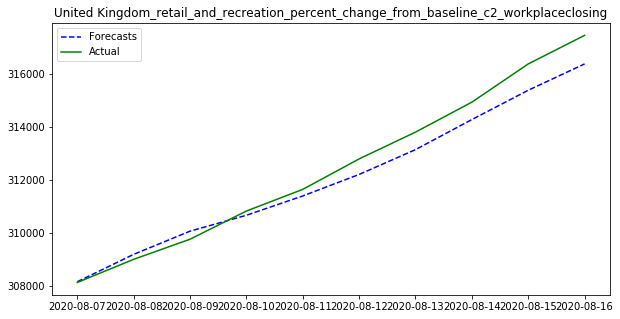

+++c3_cancelpublicevents+++
Lag chosen: 8


/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/stat

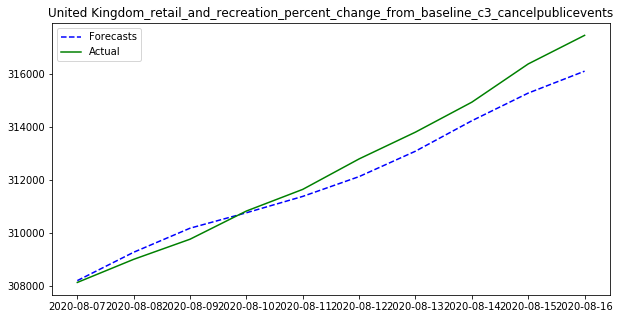

+++c6_stayathomerequirements+++
Lag chosen: 10


/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/stat

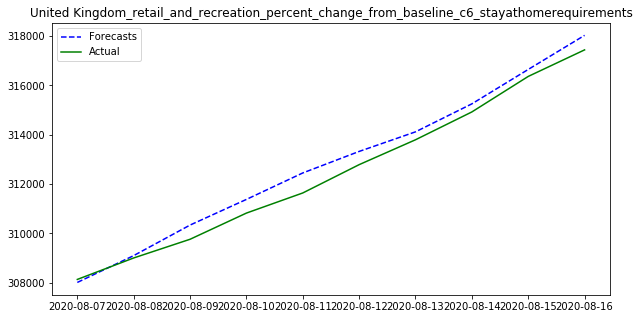

+++c7_domestictravel+++
Lag chosen: 8


/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/stat

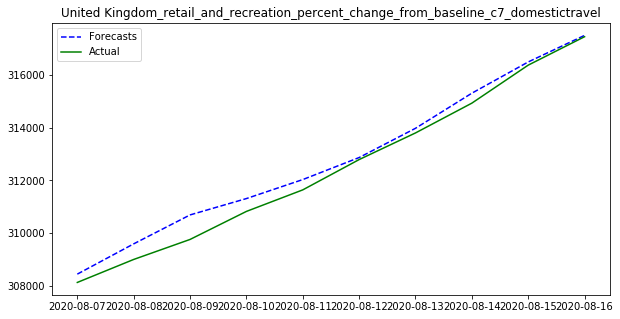

+++h3_contacttracing+++
Lag chosen: 8


/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/stat

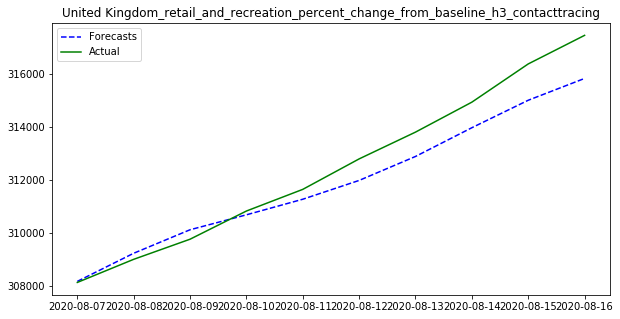

+++grocery_and_pharmacy_percent_change_from_baseline+++
+++c2_workplaceclosing+++
Lag chosen: 8


/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/stat

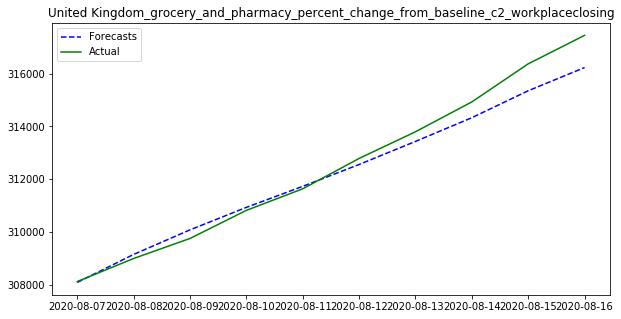

+++c3_cancelpublicevents+++
Lag chosen: 9


/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/stat

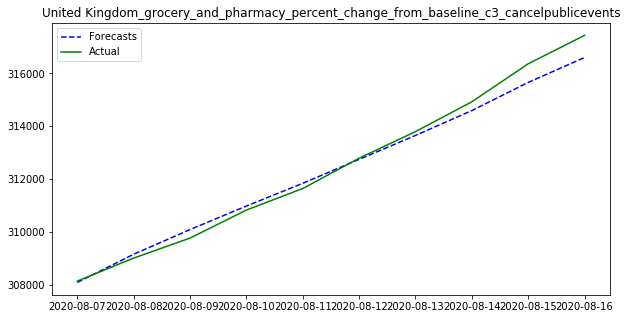

+++c6_stayathomerequirements+++
Lag chosen: 10


/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/stat

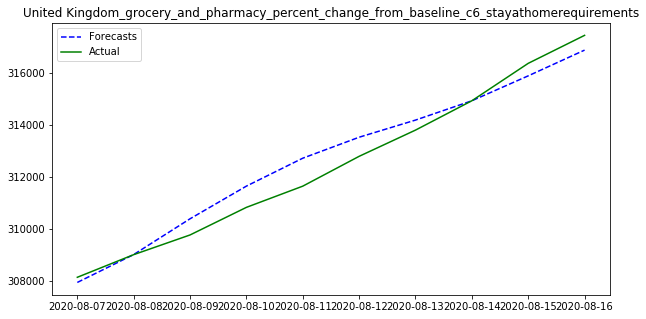

+++c7_domestictravel+++
Lag chosen: 8


/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/stat

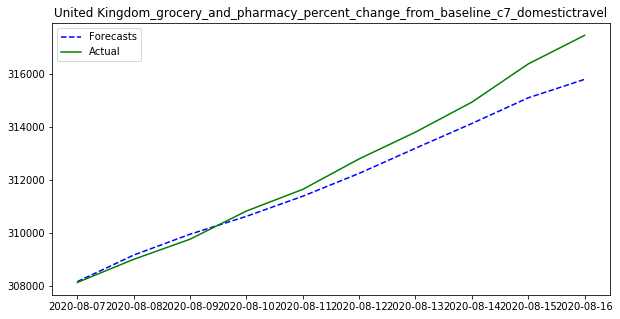

+++h3_contacttracing+++
Lag chosen: 9


/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/stat

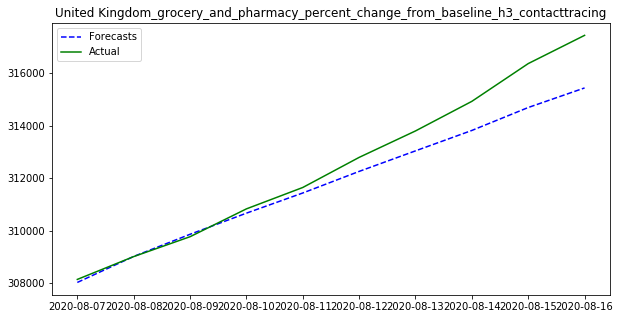

+++parks_percent_change_from_baseline+++
+++c2_workplaceclosing+++
Lag chosen: 8


/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/stat

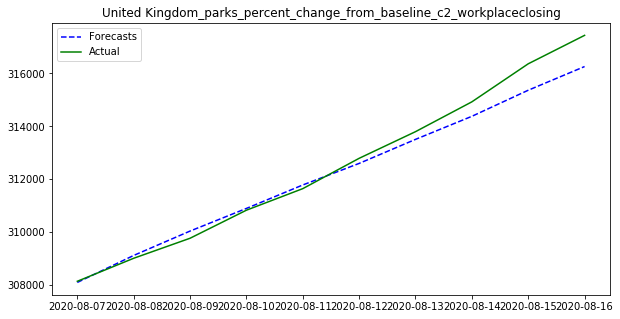

+++c3_cancelpublicevents+++
Lag chosen: 8


/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/stat

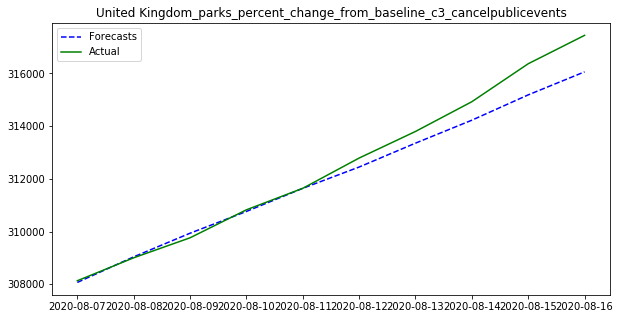

+++c6_stayathomerequirements+++
Lag chosen: 8


/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/stat

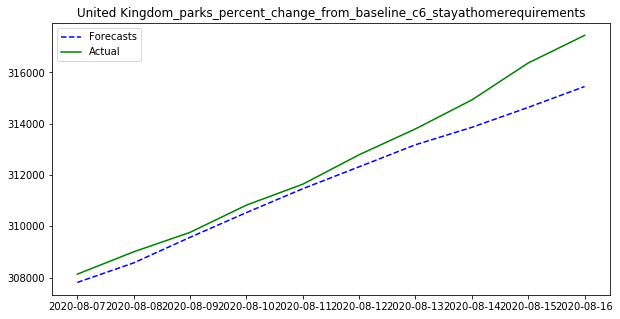

+++c7_domestictravel+++
Lag chosen: 8


/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/stat

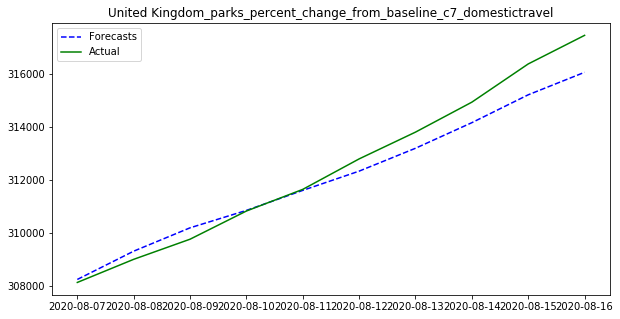

+++h3_contacttracing+++
Lag chosen: 8


/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/stat

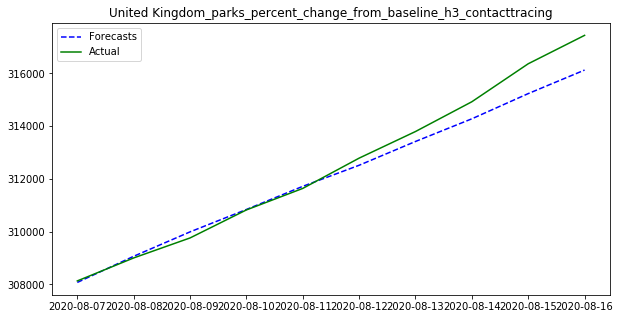

+++transit_stations_percent_change_from_baseline+++
+++c2_workplaceclosing+++
Lag chosen: 8


/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/stat

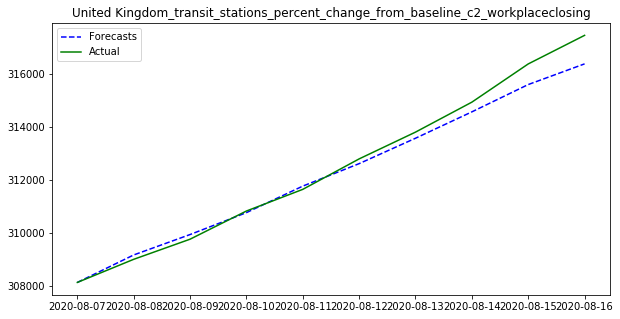

+++c3_cancelpublicevents+++
Lag chosen: 8


/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/stat

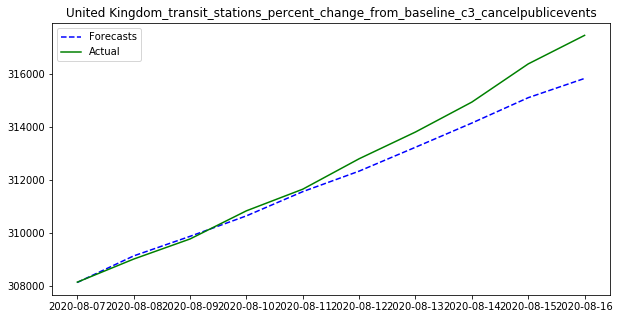

+++c6_stayathomerequirements+++
Lag chosen: 8


/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/stat

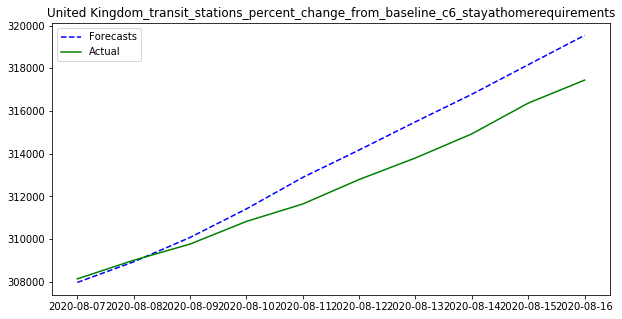

+++c7_domestictravel+++
Lag chosen: 8


/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/stat

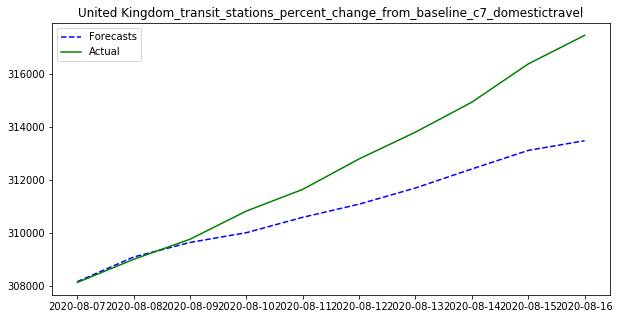

+++h3_contacttracing+++
Lag chosen: 8


/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/stat

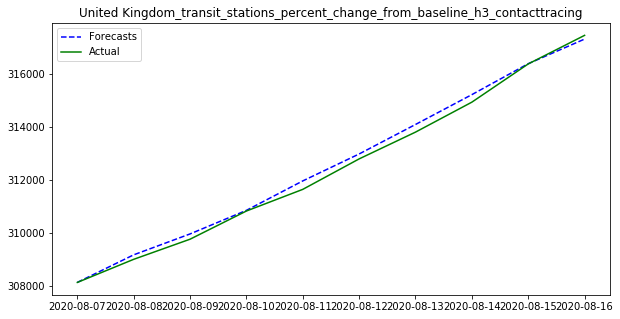

+++workplaces_percent_change_from_baseline+++
+++c2_workplaceclosing+++
Lag chosen: 9


/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/stat

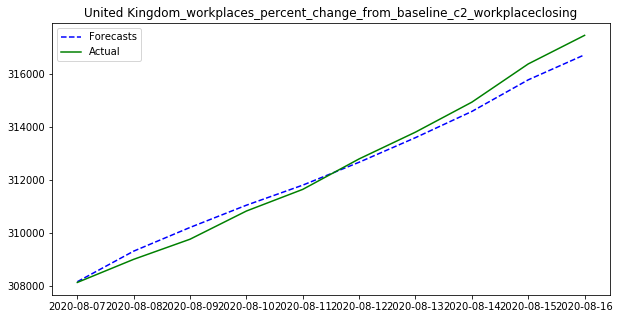

+++c3_cancelpublicevents+++
Lag chosen: 10


/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/stat

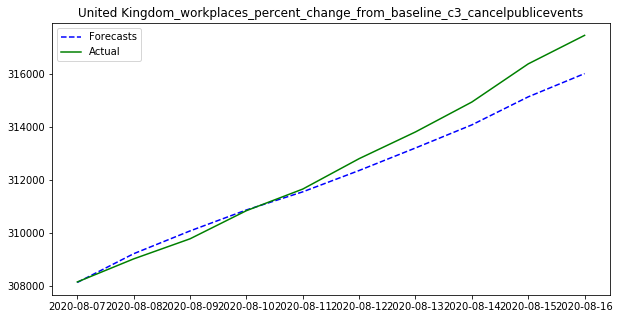

+++c6_stayathomerequirements+++


/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/stat

Lag chosen: 9


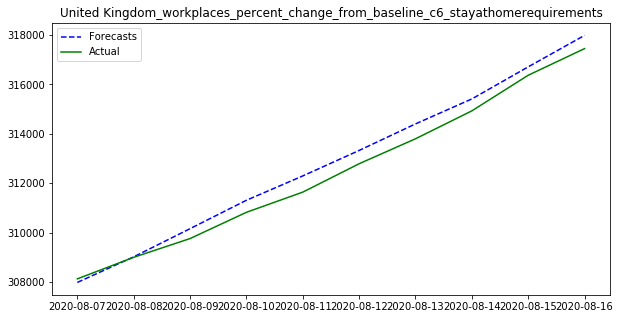

+++c7_domestictravel+++
Lag chosen: 9


/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/stat

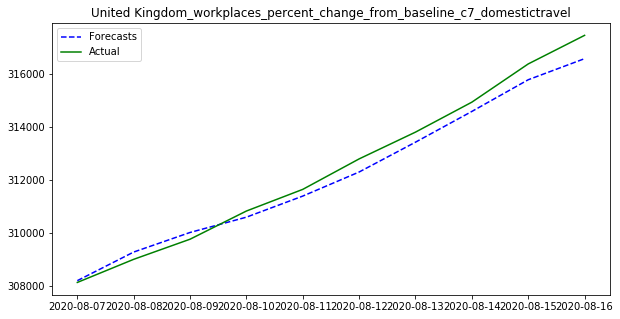

+++h3_contacttracing+++
Lag chosen: 9


/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/stat

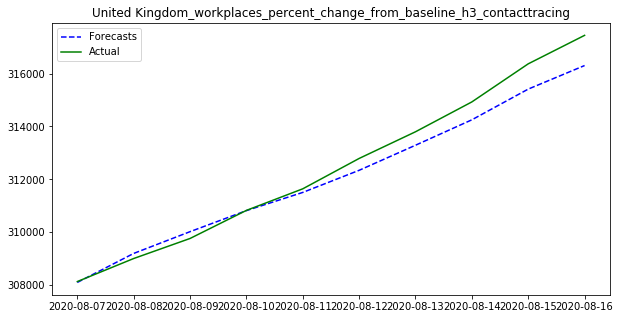

+++residential_percent_change_from_baseline+++
+++c2_workplaceclosing+++
Lag chosen: 9


/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/stat

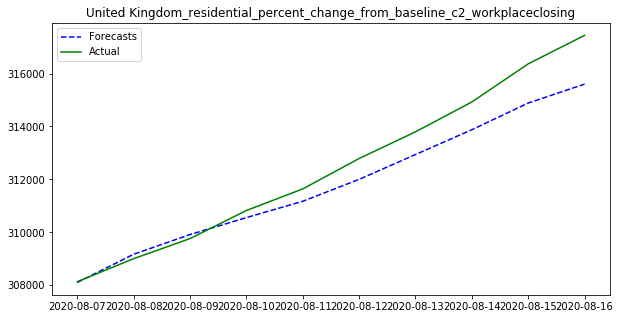

+++c3_cancelpublicevents+++
Lag chosen: 10


/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/stat

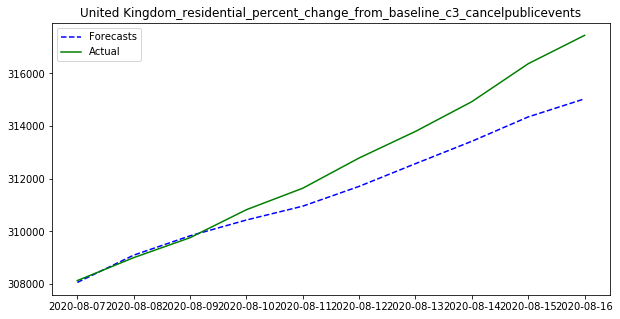

+++c6_stayathomerequirements+++
Lag chosen: 9


/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/stat

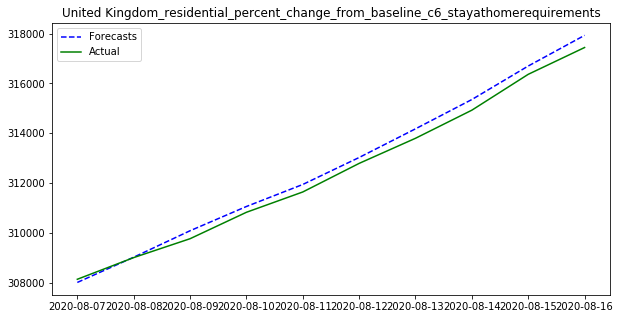

+++c7_domestictravel+++
Lag chosen: 9


/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/stat

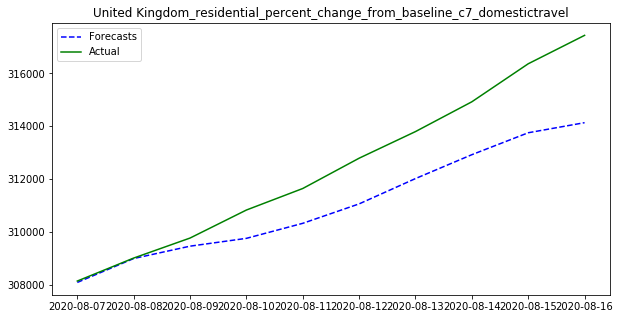

+++h3_contacttracing+++
Lag chosen: 10


/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/stat

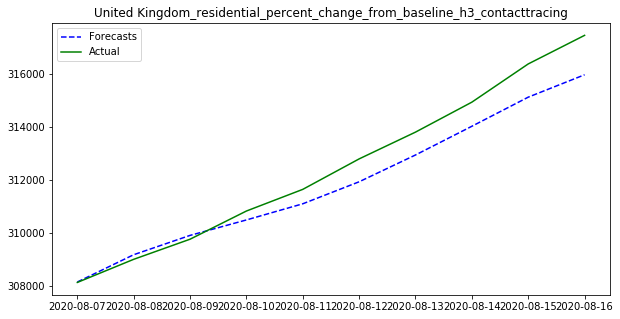

-------------------Russia-----------------------------------
cases 0
retail_and_recreation_percent_change_from_baseline 1
grocery_and_pharmacy_percent_change_from_baseline 1
parks_percent_change_from_baseline 1
transit_stations_percent_change_from_baseline 1
workplaces_percent_change_from_baseline 1
residential_percent_change_from_baseline 1
c1_schoolclosing 1
c2_workplaceclosing 1
c4_restrictionsongatherings 1
c6_stayathomerequirements 1
+++retail_and_recreation_percent_change_from_baseline+++
+++c1_schoolclosing+++
Lag chosen: 10


/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

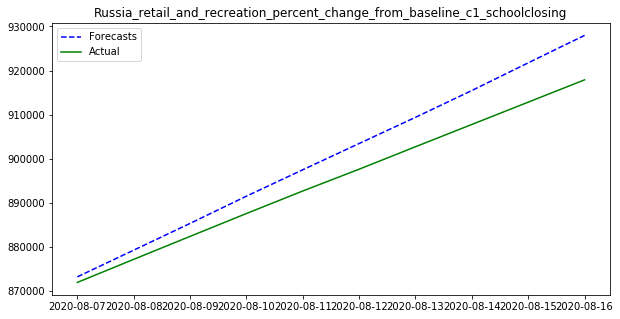

+++c2_workplaceclosing+++
Lag chosen: 10


/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/stat

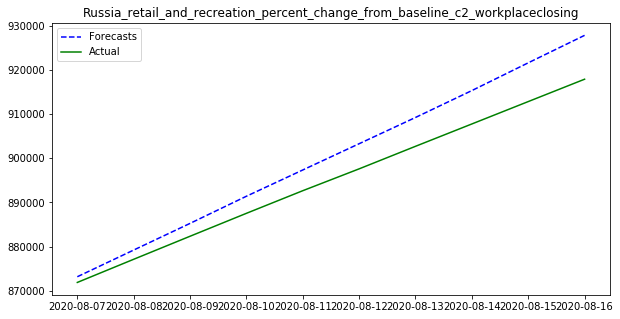

+++c4_restrictionsongatherings+++
Lag chosen: 6


/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/stat

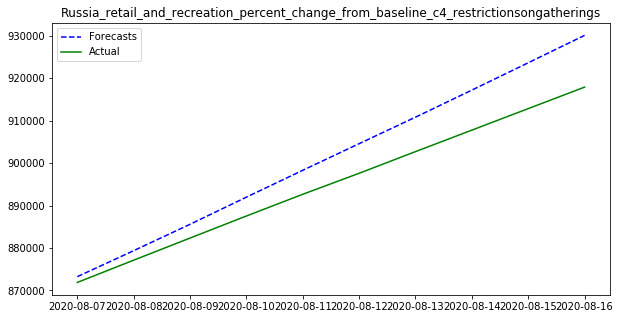

+++c6_stayathomerequirements+++
Lag chosen: 6


/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/stat

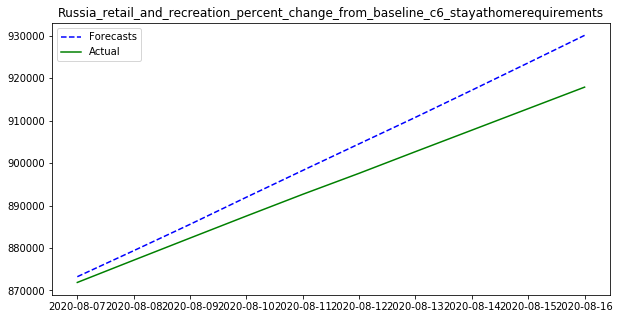

+++grocery_and_pharmacy_percent_change_from_baseline+++
+++c1_schoolclosing+++
Lag chosen: 4


/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/stat

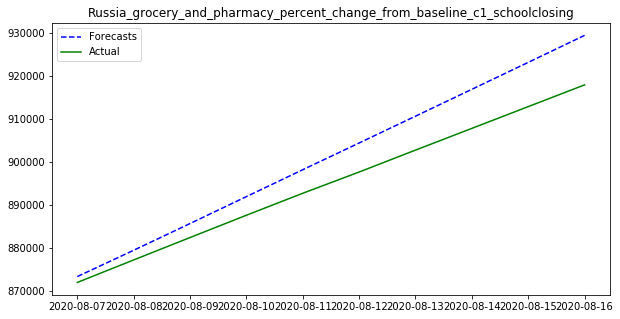

+++c2_workplaceclosing+++
Lag chosen: 4


/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/stat

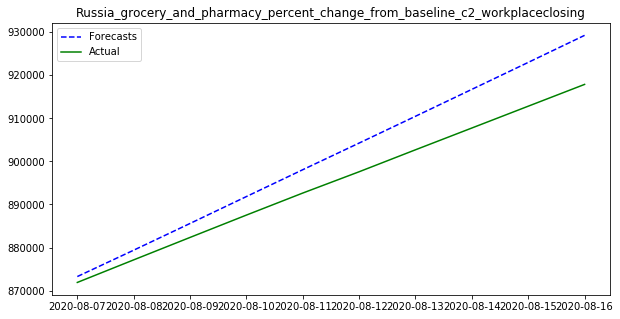

+++c4_restrictionsongatherings+++
Lag chosen: 6


/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/stat

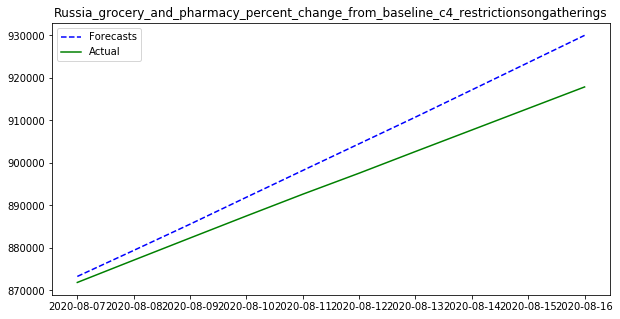

+++c6_stayathomerequirements+++
Lag chosen: 4


/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/stat

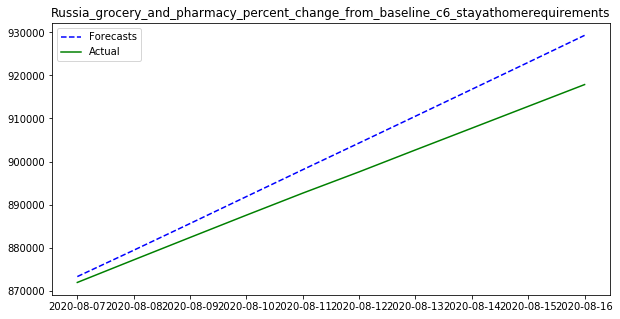

+++parks_percent_change_from_baseline+++
+++c1_schoolclosing+++
Lag chosen: 1


/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/stat

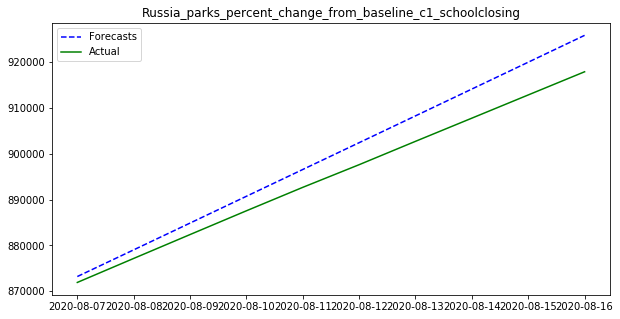

+++c2_workplaceclosing+++
Lag chosen: 1


/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/stat

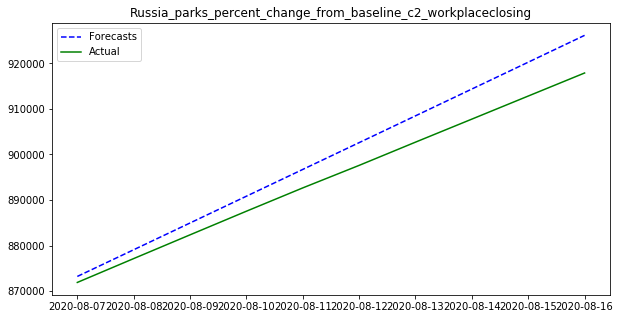

+++c4_restrictionsongatherings+++
Lag chosen: 5


/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/stat

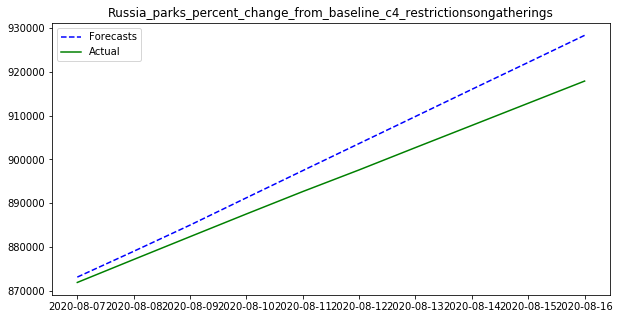

+++c6_stayathomerequirements+++
Lag chosen: 4


/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/stat

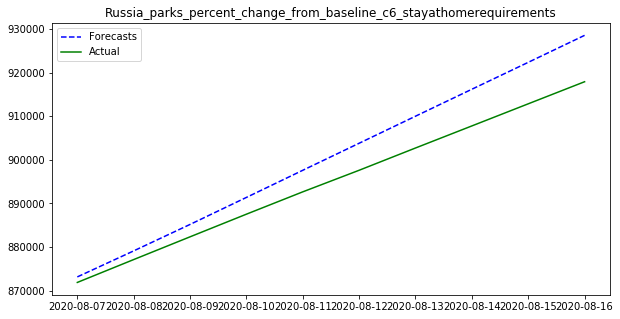

+++transit_stations_percent_change_from_baseline+++
+++c1_schoolclosing+++
Lag chosen: 1


/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/stat

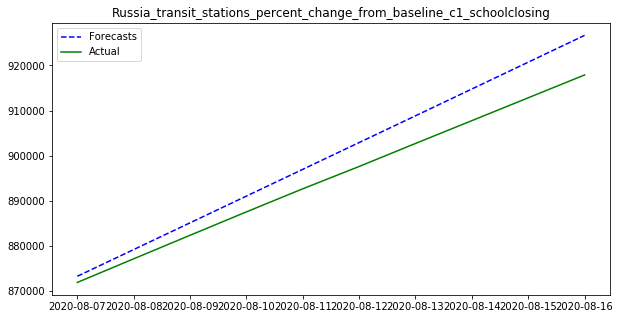

+++c2_workplaceclosing+++
Lag chosen: 1


/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/stat

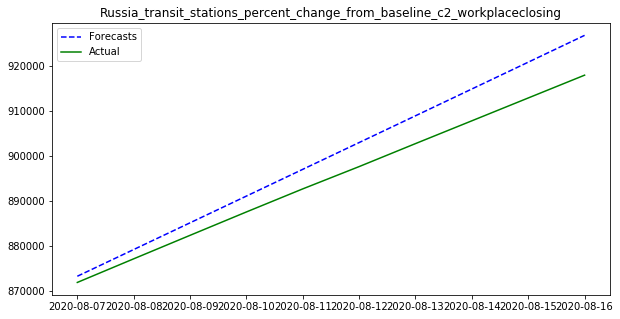

+++c4_restrictionsongatherings+++
Lag chosen: 1


/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/stat

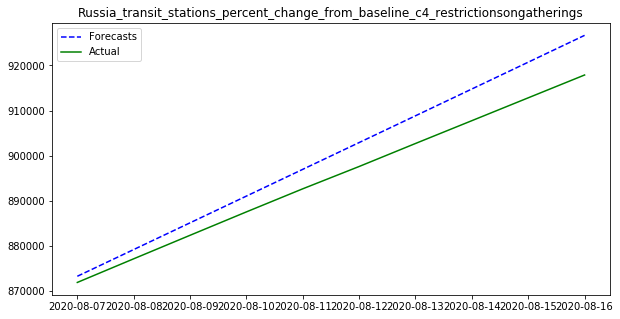

+++c6_stayathomerequirements+++
Lag chosen: 3


/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/klacka/opt/anaconda3/lib/python3.7/site-packages/stat

KeyboardInterrupt: 

In [22]:
for country in countries:
    print('-------------------' + country + '-----------------------------------') 
    country_cases = cases_cov[cases_cov['country_region'] == country]
    country_cases = country_cases.drop(['responsevalue','country_region'], axis = 1)
    
    m = 10 # days
    split = len(country_cases) - m
    country_cases_train = country_cases[:split]
    country_cases_test = country_cases[split:]
    
    diff_per_col = {}
    #df_country_cases = pd.DataFrame(columns = country_cases.columns, index = country_cases.index)
    
    for column_name, series in country_cases_train.iteritems():
        if np.all(statistics.variance(series) == 0) or len(set(series)) <= 2:
            country_cases_train = country_cases_train.drop(column_name, axis=1) #dropping constant time series
        else:
            country_cases_train[column_name], num = differencing(series)
            diff_per_col[column_name] = num
            print(column_name + " " + str(num))
    country_cases_train = country_cases_train.dropna()
    
    for mobility_type in mob_types:
        if (mobility_type in country_cases_train.columns):
            print('+++' + mobility_type + '+++')
            for policy_type in pol_types:
                if (policy_type in country_cases_train.columns):
                    #file = open('eval/var/' + country + "_" + mobility_type + "_" + policy_type + ".txt", "a+")
                    print('+++' + policy_type + '+++')
                    #forecasts_p0_c, forecasts_p2_c, forecasts_p0_m, forecasts_p2_m = sarima_cases(policy_type, mobility_type, country)
                    cols = ['cases', mobility_type, policy_type]
                    df = country_cases_train[cols]
                    #df_0 = country_cases_train[cols]
                    #df_2 = country_cases_train[cols]
                    
#                     for i in range(0,13):
#                         i += 1
#                         new_date = df_0.index[-1] + pd.Timedelta(days=1)
#                         df_0.loc[new_date, 'cases'] = forecasts_p0_c[i]
#                         df_0.loc[new_date, mobility_type] = forecasts_p0_m[i]
                        
#                         new_date = df_2.index[-1] + pd.Timedelta(days=1)
#                         df_2.loc[new_date, 'cases'] = forecasts_p2_c[i]
#                         df_2.loc[new_date, mobility_type] = forecasts_p2_m[i]
                        
#                     forecasts_p0_m = np.asarray(forecasts_p0_m).reshape(-1,1)
#                     forecasts_p2_m = np.asarray(forecasts_p2_m).reshape(-1,1)
                    
#                     df_0.loc[df_0.tail(m).index, policy_type] = [0.0] * m
#                     df_2.loc[df_2.tail(m).index, policy_type] = [2.0] * m
#                     df_0.index = pd.to_datetime(country_cases_train.index)
#                     df_2.index = pd.to_datetime(country_cases_train.index) 
                    
                    #lag_choosing_0 = select_order(df_0, maxlags=m, deterministic='nc')
                    #lag_choosing_2 = select_order(df_2, maxlags=m, deterministic='nc')
                    lag_choosing = select_order(df, maxlags=m, deterministic='nc')
                    model = VECM(df, missing='drop', k_ar_diff = lag_choosing.aic, deterministic='nc')
                    print("Lag chosen: " + str(lag_choosing.aic))
                    #model_0 = VECM(df_0, missing='drop', k_ar_diff = lag_choosing_0.aic, deterministic='nc')
                    #model_2 = VECM(df_2, missing='drop', k_ar_diff = lag_choosing_2.aic, deterministic='nc')
                    #fitted_0 = model_0.fit()
                    #fitted_2 = model_2.fit()
                    fitted = model.fit()
                    forecasts = fitted.predict(steps = m)
                    df_forecast = pd.DataFrame(forecasts, index = country_cases_test.index, columns = cols)
                    
#                   out = durbin_watson(fitted.resid)

#                   for col, val in zip(df.columns, out):
#                         print("Durbin Watson test for errors:", file = file)
#                         print(col, ':', round(val, 2), file = file)
                        
#                   lag_order_0 = fitted_0.k_ar
#                   lag_order_2 = fitted_2.k_ar
                    #lag_order = fitted.k_ar
                    #print("Lag order chosen: " + str(lag_order), file=file)
                    
                    #y=df.values[-(2*lag_order):]
                    #fitted.forecast(y=df.values[-lag_order:], steps=m)
#                     dates_list = [] 
#                     date_start = df_0.index[-1]
#                     for i in range(1, m+1):
#                         next_date = date_start + pd.Timedelta(days=i)
#                         dates_list.append(next_date)
                    
#                     forecast_0 = fitted_0.predict(steps = m) #chosing the number of prediction steps based on the lag
#                     forecast_2 = fitted_2.predict(steps = m)
#                     df_forecast_0 = pd.DataFrame(forecast_0, index = pd.DatetimeIndex(dates_list), columns = ["p0_" + col for col in cols])
#                     df_forecast_2 = pd.DataFrame(forecast_2, index = pd.DatetimeIndex(dates_list), columns = ["p2_" + col for col in cols])
            
                    #df_final = pd.concat([df_forecast_0, df_forecast_2], axis=1, sort=False)
                    
                    #df_final.to_csv('data/enfor_cases_predictions' + country + "_" + mobility_type + "_" + policy_type + '.csv', mode='a', header=True)
                    
                    df_forecast_rev = df_forecast.copy()
                    
                    for col in cols:
                        diff_num = diff_per_col[col] #get the number of diff needed for the column before
                        if diff_num == 2:
                            df_forecast_rev[col] = (country_cases[col].iloc[-1] - country_cases[col].iloc[-2]) + df_forecast_rev[col].cumsum()
                        if diff_num == 1:
                            df_forecast_rev[col] = country_cases[col].iloc[-1] + df_forecast_rev[col].cumsum()
                    #if (country=='Spain' and policy_type=='c7_domestictravel' and mobility_type=='grocery_and_pharmacy_percent_change_from_baseline'):
                    fig = plt.figure(figsize=(10,5))
                    plt.plot(df_forecast_rev.cases, '--', c='blue', label = "Forecasts")
                    plt.plot(country_cases_test.cases, c='green', label = "Actual")
                    #lab = policy_type + " " + "not enforced"
                    #plt.plot(df_forecast_0.p0_cases, '--', c='blue', label = lab)
                    country_cases_test.index = pd.to_datetime(country_cases_test.index)
                    #lab = policy_type + " " + "enforced"
                    #plt.plot(df_forecast_2.p2_cases, '--', c='green', label = lab)
                    plt.legend()
                    plt.title(country + "_" + mobility_type + "_" + policy_type)
                    plt.show()
#                     if (country == 'United Kingdom'):
#                         fig.savefig('plots/recommendations/vecm' + country + "_" + mobility_type + "_" + policy_type + ".pdf", format='pdf', bbox_inches = 'tight')
#                         plt.close(fig)